## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


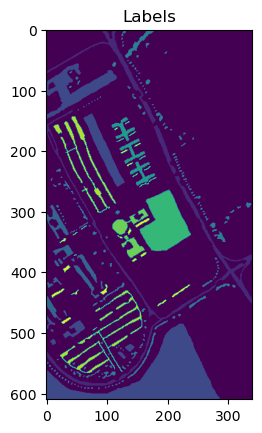

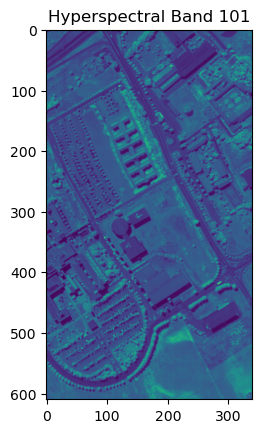

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 10 train


All datasets saved to the 'indices' folder.
(90, 5, 5, 103)
(45, 5, 5, 103)
(42641, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 90
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1189, PSNR: 7.4579


	 Training Batch [200/535], Loss: 0.0570, PSNR: 10.7902


	 Training Batch [400/535], Loss: 0.0288, PSNR: 13.6232


Epoch [1/50] Training Loss: 0.0550, PSNR: 11.2528
	[Val]   Batch [1/134] Loss: 0.0189, PSNR: 15.4354
	[Val]   Batch [10/134] Loss: 0.0167, PSNR: 17.7840
	[Val]   Batch [20/134] Loss: 0.0180, PSNR: 15.5601
	[Val]   Batch [30/134] Loss: 0.0194, PSNR: 15.0491
	[Val]   Batch [40/134] Loss: 0.0176, PSNR: 14.0772
	[Val]   Batch [50/134] Loss: 0.0187, PSNR: 15.2587
	[Val]   Batch [60/134] Loss: 0.0170, PSNR: 15.8888
	[Val]   Batch [70/134] Loss: 0.0162, PSNR: 16.0895


	[Val]   Batch [80/134] Loss: 0.0158, PSNR: 16.0761
	[Val]   Batch [90/134] Loss: 0.0165, PSNR: 16.0887
	[Val]   Batch [100/134] Loss: 0.0187, PSNR: 15.4835
	[Val]   Batch [110/134] Loss: 0.0189, PSNR: 14.0308
	[Val]   Batch [120/134] Loss: 0.0157, PSNR: 15.1517
	[Val]   Batch [130/134] Loss: 0.0173, PSNR: 13.1756
Epoch [1/50] Validation Loss: 0.0179, PSNR: 15.4394

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0181, PSNR: 17.4313


	 Training Batch [200/535], Loss: 0.0124, PSNR: 15.3248


	 Training Batch [400/535], Loss: 0.0086, PSNR: 18.7575


Epoch [2/50] Training Loss: 0.0118, PSNR: 17.3134
	[Val]   Batch [1/134] Loss: 0.0088, PSNR: 18.7704
	[Val]   Batch [10/134] Loss: 0.0071, PSNR: 21.5089
	[Val]   Batch [20/134] Loss: 0.0077, PSNR: 19.2387
	[Val]   Batch [30/134] Loss: 0.0087, PSNR: 18.5407
	[Val]   Batch [40/134] Loss: 0.0078, PSNR: 17.6037
	[Val]   Batch [50/134] Loss: 0.0081, PSNR: 18.8821
	[Val]   Batch [60/134] Loss: 0.0071, PSNR: 19.6735


	[Val]   Batch [70/134] Loss: 0.0069, PSNR: 19.7751
	[Val]   Batch [80/134] Loss: 0.0066, PSNR: 19.8427
	[Val]   Batch [90/134] Loss: 0.0070, PSNR: 19.8110
	[Val]   Batch [100/134] Loss: 0.0084, PSNR: 18.9778
	[Val]   Batch [110/134] Loss: 0.0079, PSNR: 17.8347
	[Val]   Batch [120/134] Loss: 0.0060, PSNR: 19.3162
	[Val]   Batch [130/134] Loss: 0.0072, PSNR: 16.9790
Epoch [2/50] Validation Loss: 0.0079, PSNR: 19.0005

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0074, PSNR: 18.0279


	 Training Batch [200/535], Loss: 0.0067, PSNR: 21.2921


	 Training Batch [400/535], Loss: 0.0075, PSNR: 20.7786


Epoch [3/50] Training Loss: 0.0069, PSNR: 19.5949
	[Val]   Batch [1/134] Loss: 0.0062, PSNR: 20.2959
	[Val]   Batch [10/134] Loss: 0.0049, PSNR: 23.1203
	[Val]   Batch [20/134] Loss: 0.0053, PSNR: 20.8729
	[Val]   Batch [30/134] Loss: 0.0060, PSNR: 20.1652
	[Val]   Batch [40/134] Loss: 0.0055, PSNR: 19.1644
	[Val]   Batch [50/134] Loss: 0.0055, PSNR: 20.5410
	[Val]   Batch [60/134] Loss: 0.0048, PSNR: 21.3832


	[Val]   Batch [70/134] Loss: 0.0048, PSNR: 21.3915
	[Val]   Batch [80/134] Loss: 0.0045, PSNR: 21.5185
	[Val]   Batch [90/134] Loss: 0.0048, PSNR: 21.4482
	[Val]   Batch [100/134] Loss: 0.0058, PSNR: 20.5440
	[Val]   Batch [110/134] Loss: 0.0052, PSNR: 19.6189
	[Val]   Batch [120/134] Loss: 0.0038, PSNR: 21.3153
	[Val]   Batch [130/134] Loss: 0.0048, PSNR: 18.7228
Epoch [3/50] Validation Loss: 0.0055, PSNR: 20.5856

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0067, PSNR: 19.8656


	 Training Batch [200/535], Loss: 0.0051, PSNR: 19.7859


	 Training Batch [400/535], Loss: 0.0050, PSNR: 21.1201


Epoch [4/50] Training Loss: 0.0051, PSNR: 20.9434
	[Val]   Batch [1/134] Loss: 0.0042, PSNR: 21.9202
	[Val]   Batch [10/134] Loss: 0.0034, PSNR: 24.6612
	[Val]   Batch [20/134] Loss: 0.0035, PSNR: 22.6639
	[Val]   Batch [30/134] Loss: 0.0040, PSNR: 21.9430
	[Val]   Batch [40/134] Loss: 0.0036, PSNR: 20.9539
	[Val]   Batch [50/134] Loss: 0.0036, PSNR: 22.4378


	[Val]   Batch [60/134] Loss: 0.0034, PSNR: 22.9172
	[Val]   Batch [70/134] Loss: 0.0033, PSNR: 22.9774
	[Val]   Batch [80/134] Loss: 0.0031, PSNR: 23.1180
	[Val]   Batch [90/134] Loss: 0.0033, PSNR: 23.0815
	[Val]   Batch [100/134] Loss: 0.0040, PSNR: 22.2074
	[Val]   Batch [110/134] Loss: 0.0034, PSNR: 21.5127
	[Val]   Batch [120/134] Loss: 0.0025, PSNR: 23.1344
	[Val]   Batch [130/134] Loss: 0.0031, PSNR: 20.6572
Epoch [4/50] Validation Loss: 0.0038, PSNR: 22.2432

LOG: Epoch [5/50]


	 Training Batch [1/535], Loss: 0.0038, PSNR: 21.9108


	 Training Batch [200/535], Loss: 0.0031, PSNR: 21.4529


	 Training Batch [400/535], Loss: 0.0040, PSNR: 22.1812


Epoch [5/50] Training Loss: 0.0036, PSNR: 22.4558
	[Val]   Batch [1/134] Loss: 0.0032, PSNR: 23.2042
	[Val]   Batch [10/134] Loss: 0.0025, PSNR: 25.9593
	[Val]   Batch [20/134] Loss: 0.0025, PSNR: 24.2122
	[Val]   Batch [30/134] Loss: 0.0028, PSNR: 23.4476
	[Val]   Batch [40/134] Loss: 0.0025, PSNR: 22.5374
	[Val]   Batch [50/134] Loss: 0.0025, PSNR: 24.0623
	[Val]   Batch [60/134] Loss: 0.0026, PSNR: 24.0312


	[Val]   Batch [70/134] Loss: 0.0025, PSNR: 24.2383
	[Val]   Batch [80/134] Loss: 0.0024, PSNR: 24.3590
	[Val]   Batch [90/134] Loss: 0.0025, PSNR: 24.3095
	[Val]   Batch [100/134] Loss: 0.0029, PSNR: 23.5945
	[Val]   Batch [110/134] Loss: 0.0023, PSNR: 23.2252
	[Val]   Batch [120/134] Loss: 0.0018, PSNR: 24.6145
	[Val]   Batch [130/134] Loss: 0.0022, PSNR: 22.1647
Epoch [5/50] Validation Loss: 0.0028, PSNR: 23.5995

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0033, PSNR: 23.0692


	 Training Batch [200/535], Loss: 0.0028, PSNR: 23.1501


	 Training Batch [400/535], Loss: 0.0020, PSNR: 23.2495


Epoch [6/50] Training Loss: 0.0028, PSNR: 23.4894
	[Val]   Batch [1/134] Loss: 0.0026, PSNR: 24.1114
	[Val]   Batch [10/134] Loss: 0.0020, PSNR: 26.9522
	[Val]   Batch [20/134] Loss: 0.0019, PSNR: 25.4073
	[Val]   Batch [30/134] Loss: 0.0022, PSNR: 24.5772
	[Val]   Batch [40/134] Loss: 0.0019, PSNR: 23.7176
	[Val]   Batch [50/134] Loss: 0.0019, PSNR: 25.2829
	[Val]   Batch [60/134] Loss: 0.0021, PSNR: 24.9440
	[Val]   Batch [70/134] Loss: 0.0020, PSNR: 25.1781


	[Val]   Batch [80/134] Loss: 0.0019, PSNR: 25.3341
	[Val]   Batch [90/134] Loss: 0.0020, PSNR: 25.2182
	[Val]   Batch [100/134] Loss: 0.0023, PSNR: 24.6535
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.6064
	[Val]   Batch [120/134] Loss: 0.0013, PSNR: 25.8431
	[Val]   Batch [130/134] Loss: 0.0017, PSNR: 23.3198
Epoch [6/50] Validation Loss: 0.0022, PSNR: 24.6329

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0026, PSNR: 23.9143


	 Training Batch [200/535], Loss: 0.0029, PSNR: 23.6538


	 Training Batch [400/535], Loss: 0.0018, PSNR: 24.0901


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.1396
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.6110
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.4656
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 26.1261
	[Val]   Batch [30/134] Loss: 0.0019, PSNR: 25.2195
	[Val]   Batch [40/134] Loss: 0.0016, PSNR: 24.3824
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 25.9320
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.4413


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.7000
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.8902
	[Val]   Batch [90/134] Loss: 0.0018, PSNR: 25.7040
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.2226
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.3662
	[Val]   Batch [120/134] Loss: 0.0011, PSNR: 26.5537
	[Val]   Batch [130/134] Loss: 0.0014, PSNR: 23.9397


Epoch [7/50] Validation Loss: 0.0019, PSNR: 25.2118

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0023, PSNR: 24.5133


	 Training Batch [200/535], Loss: 0.0028, PSNR: 23.5775


	 Training Batch [400/535], Loss: 0.0018, PSNR: 24.5042


Epoch [8/50] Training Loss: 0.0022, PSNR: 24.5834
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 24.9829
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 27.8864
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.6622
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.6899
	[Val]   Batch [40/134] Loss: 0.0014, PSNR: 24.9503
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.4483
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.8505


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.0799
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.3304
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 26.0928
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.6822
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.9257
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.0753
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.4094
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.6682

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0029, PSNR: 24.8617


	 Training Batch [200/535], Loss: 0.0031, PSNR: 23.3970


	 Training Batch [400/535], Loss: 0.0030, PSNR: 23.4747


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.9026
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.3905
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.3106
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.2471
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.2217
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.4980
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.9803
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.2596


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.4998
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.8046
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.5136
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.1437
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.5738
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.6726
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.9340
Epoch [9/50] Validation Loss: 0.0016, PSNR: 26.1557

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.5826


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.3373


	 Training Batch [400/535], Loss: 0.0018, PSNR: 25.6411


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.2092
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.6186
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.5652
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.6026
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.5224
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.8168
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.2617
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.5103


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.7505
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 27.0959
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.7703
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.4176
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.9217
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.0075
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.2315
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.4386

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0021, PSNR: 25.0135


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.0686


	 Training Batch [400/535], Loss: 0.0017, PSNR: 27.5717


Epoch [11/50] Training Loss: 0.0018, PSNR: 25.4980
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.8294
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.7817
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 27.9145
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.7816
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.0953
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.5203
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.7371


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.9452
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.3329
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.0023
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.6463
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.2084
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.2588
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.4844
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.6895

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.1567


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.5053


	 Training Batch [400/535], Loss: 0.0024, PSNR: 26.1981


Epoch [12/50] Training Loss: 0.0017, PSNR: 25.6608
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.0308
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 29.0143
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.2240
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.0459
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.3906
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.7752


	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9994
	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.1785
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.6117
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.2446
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.8800
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.5136
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.5842
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.7743
Epoch [12/50] Validation Loss: 0.0013, PSNR: 26.9496

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 25.5841


	 Training Batch [200/535], Loss: 0.0013, PSNR: 24.6037


	 Training Batch [400/535], Loss: 0.0027, PSNR: 25.7323


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.8388
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.2481
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2348
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.5207
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.3139
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.6642
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.0441
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.2351


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.4003
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 27.8790
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.4898
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.1207
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.8067
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.8385
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.0474
Epoch [13/50] Validation Loss: 0.0012, PSNR: 27.1996

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 26.8935


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.6232


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.9312


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.9717
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.3808
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.3530
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.6951
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.4678
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.8535
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1750
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.3856


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.5425
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.0457
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.6171
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.2545
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9647
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0041
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.2014
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.3567

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 24.9319


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.8723


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.8239


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1472
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.5431
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5165
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.9148
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.6340
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.0220
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.3389
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.5839


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.7203
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.2305
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.8063
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.4023
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.1147
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.1494
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.3843
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.5280

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.7447


	 Training Batch [200/535], Loss: 0.0014, PSNR: 25.0752


	 Training Batch [400/535], Loss: 0.0016, PSNR: 25.9383


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.3312
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.6921
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.6734
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.0838
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.8059
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.1996
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.5142
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.7604


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.8790
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.4224
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.9865
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5910
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.3195
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.3113
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.5641
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.7010

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.0053


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.2430


	 Training Batch [400/535], Loss: 0.0019, PSNR: 26.1711


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.4646
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8616
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.8516
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.4070
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0501
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.4809
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.7580
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.0061


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.0641
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6329
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.2203
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8394
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.6238
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.4776
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.7935
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.9340

LOG: Epoch [18/50]


	 Training Batch [1/535], Loss: 0.0013, PSNR: 27.0389


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.1443


	 Training Batch [400/535], Loss: 0.0022, PSNR: 24.7720


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.6366
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.1370
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0768
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.7377
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.3362
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.7827
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.0656
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.2976


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.3915
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.9353
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.4893
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.1038
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8334
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7638
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1230
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.2177

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.6717


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.1347


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.1167


Epoch [19/50] Training Loss: 0.0013, PSNR: 26.8087
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.3264
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.1737
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 29.9984
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.5677
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.9814
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.2178
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.5720
	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.5943


	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.0975
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.7002
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.3046
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.9568
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.8221
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.2970
Epoch [19/50] Validation Loss: 0.0009, PSNR: 28.3982

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.0206


	 Training Batch [200/535], Loss: 0.0015, PSNR: 25.6240


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.0878


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.9655
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.5262
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.3028
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.1829
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.7914
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.1795
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.3793
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.8424
	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 28.8855


	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.3418
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.9337
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.5302
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0358
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9730
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.5046
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.5978

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.8988


	 Training Batch [200/535], Loss: 0.0025, PSNR: 26.0947


	 Training Batch [400/535], Loss: 0.0012, PSNR: 29.1583


Epoch [21/50] Training Loss: 0.0012, PSNR: 27.1609
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.7866
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.4905
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.5067
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 29.0872
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.4717
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.6506
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.1386


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.1978
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.6185
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.2508
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.8309
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1586
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1130
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.7726
Epoch [21/50] Validation Loss: 0.0009, PSNR: 28.8552

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.2639


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.4366


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.5179


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.3969
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.0319
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.6174
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.6753
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.3306
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.6231
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 29.8768
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.3934


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.4527
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.7963
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.5411
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.1029
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.2512
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1796
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.9275
Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.0680

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.1374


	 Training Batch [200/535], Loss: 0.0013, PSNR: 27.1287


	 Training Batch [400/535], Loss: 0.0016, PSNR: 25.9609


Epoch [23/50] Training Loss: 0.0011, PSNR: 27.5159
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.4072
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.9674
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.1964
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 29.8235
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 29.0528
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.3280
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.8027


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.9167
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.2184
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.9782
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.5455
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.6092
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.4780
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.3381
Epoch [23/50] Validation Loss: 0.0007, PSNR: 29.4780

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.4285


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.4152


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.0826


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.6793
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.6281
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.1117
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.3170
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.0210
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.2102
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.4921
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.9757


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.1142
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.3611
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.1847
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.7853
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.6547
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.5141


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.4432
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.6572

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 27.6501


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.4639


	 Training Batch [400/535], Loss: 0.0008, PSNR: 27.3690


Epoch [25/50] Training Loss: 0.0010, PSNR: 27.9128
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 28.9904
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.4041
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.7049
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4148
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4449
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.8748
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2938


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.4482
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.6643
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5574
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.1416
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9686
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7643
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7151
Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.9926

LOG: Epoch [26/50]


	 Training Batch [1/535], Loss: 0.0010, PSNR: 27.8302


	 Training Batch [200/535], Loss: 0.0013, PSNR: 27.1628


	 Training Batch [400/535], Loss: 0.0009, PSNR: 27.6942


Epoch [26/50] Training Loss: 0.0010, PSNR: 28.0436
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.0845
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.4428
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6266
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4787
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4418
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.8471
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.3122
	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.4938


	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.6228
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5900
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.1874
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8298
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6185
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6796
Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.0308
Early stopping triggered at epoch 26. No improvement for 3 epochs.


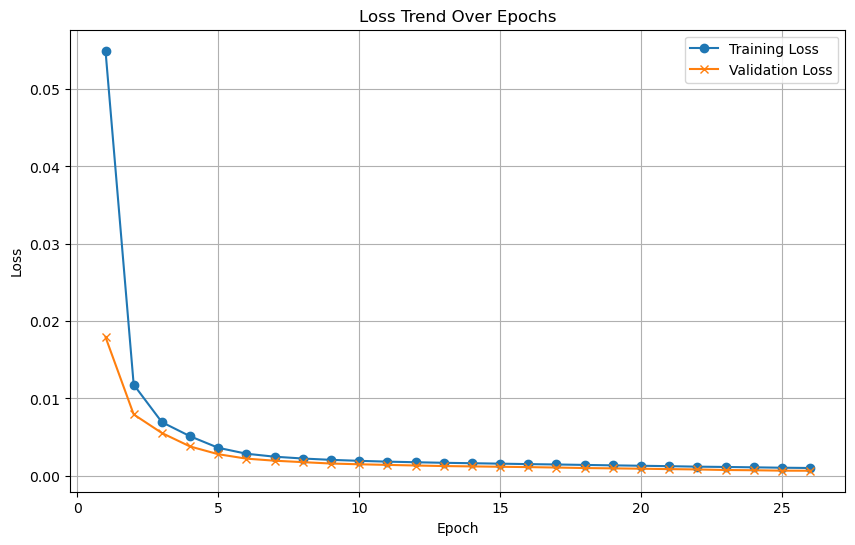

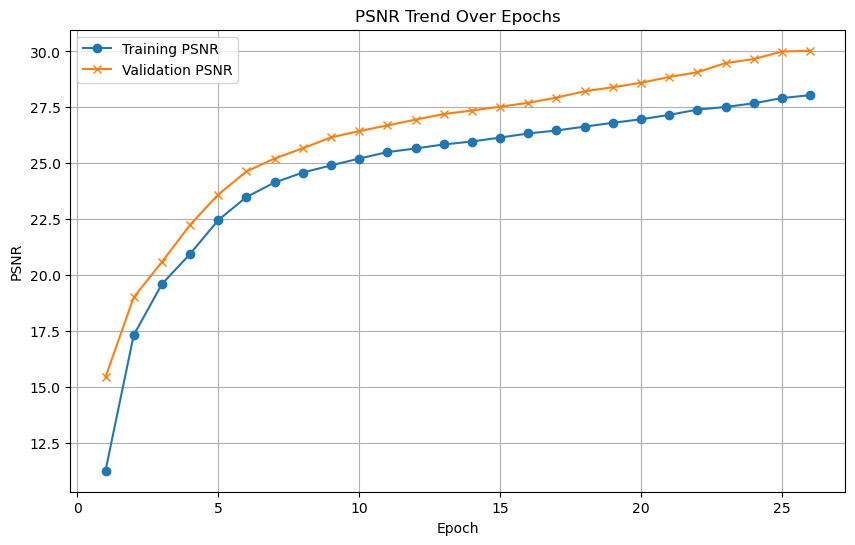

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2317
    Validation Batch [1/1], Loss: 2.2018
Validation Loss: 2.2018, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2018. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1637
    Validation Batch [1/1], Loss: 2.2018
Validation Loss: 2.2018, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1313
    Validation Batch [1/1], Loss: 2.2018
Validation Loss: 2.2018, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1054
    Validation Batch [1/1], Loss: 2.2018
Validation Loss: 2.2018, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Averag

Epoch [21/1000] completed, Average Training Loss: 1.8511
    Validation Batch [1/1], Loss: 2.1964
Validation Loss: 2.1964, Validation Accuracy: 11.11%
Validation loss improved from 2.1971 to 2.1964. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.8611
    Validation Batch [1/1], Loss: 2.1953
Validation Loss: 2.1953, Validation Accuracy: 11.11%
Validation loss improved from 2.1964 to 2.1953. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.8215
    Validation Batch [1/1], Loss: 2.1940
Validation Loss: 2.1940, Validation Accuracy: 11.11%
Validation loss improved from 2.1953 to 2.1940. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 1.8009
    Validation Batch [1/1], Loss: 2.1924
Validation Loss: 2.1924, Validation Accuracy: 11.11%
Validation loss improved from 2.1940 to 2.1924. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [2

Epoch [54/1000] completed, Average Training Loss: 1.5541
    Validation Batch [1/1], Loss: 1.8219
Validation Loss: 1.8219, Validation Accuracy: 71.11%
Validation loss improved from 1.8392 to 1.8219. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 1.4994
    Validation Batch [1/1], Loss: 1.8028
Validation Loss: 1.8028, Validation Accuracy: 71.11%
Validation loss improved from 1.8219 to 1.8028. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.5259
    Validation Batch [1/1], Loss: 1.7829
Validation Loss: 1.7829, Validation Accuracy: 71.11%
Validation loss improved from 1.8028 to 1.7829. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.4985
    Validation Batch [1/1], Loss: 1.7661
Validation Loss: 1.7661, Validation Accuracy: 71.11%
Validation loss improved from 1.7829 to 1.7661. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [5

Epoch [85/1000] completed, Average Training Loss: 1.2796
    Validation Batch [1/1], Loss: 1.4755
Validation Loss: 1.4755, Validation Accuracy: 68.89%
Validation loss improved from 1.4822 to 1.4755. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.3068
    Validation Batch [1/1], Loss: 1.4621
Validation Loss: 1.4621, Validation Accuracy: 68.89%
Validation loss improved from 1.4755 to 1.4621. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.2751
    Validation Batch [1/1], Loss: 1.4488
Validation Loss: 1.4488, Validation Accuracy: 66.67%
Validation loss improved from 1.4621 to 1.4488. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.2490
    Validation Batch [1/1], Loss: 1.4437
Validation Loss: 1.4437, Validation Accuracy: 68.89%
Validation loss improved from 1.4488 to 1.4437. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [8

Epoch [119/1000] completed, Average Training Loss: 1.0429
    Validation Batch [1/1], Loss: 1.2718
Validation Loss: 1.2718, Validation Accuracy: 73.33%
Validation loss improved from 1.2811 to 1.2718. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.0272
    Validation Batch [1/1], Loss: 1.2805
Validation Loss: 1.2805, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 0.9788
    Validation Batch [1/1], Loss: 1.2829
Validation Loss: 1.2829, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 0.9835
    Validation Batch [1/1], Loss: 1.2758
Validation Loss: 1.2758, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training 

Epoch [151/1000] completed, Average Training Loss: 0.7718
    Validation Batch [1/1], Loss: 1.1255
Validation Loss: 1.1255, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.7275
    Validation Batch [1/1], Loss: 1.1166
Validation Loss: 1.1166, Validation Accuracy: 80.00%
Validation loss improved from 1.1225 to 1.1166. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.7471
    Validation Batch [1/1], Loss: 1.1062
Validation Loss: 1.1062, Validation Accuracy: 77.78%
Validation loss improved from 1.1166 to 1.1062. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.7613
    Validation Batch [1/1], Loss: 1.0994
Validation Loss: 1.0994, Validation Accuracy: 80.00%
Validation loss improved from 1.1062 to 1.0994. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000

Epoch [185/1000] completed, Average Training Loss: 0.5258
    Validation Batch [1/1], Loss: 0.9573
Validation Loss: 0.9573, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.5277
    Validation Batch [1/1], Loss: 0.9731
Validation Loss: 0.9731, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.5318
    Validation Batch [1/1], Loss: 0.9548
Validation Loss: 0.9548, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.5010
    Validation Batch [1/1], Loss: 0.9483
Validation Loss: 0.9483, Validation Accuracy: 84.44%
Validation loss improved from 0.9485 to 0.9483. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.8529
Validation Loss: 0.8529, Validation Accuracy: 84.44%
Validation loss improved from 0.8557 to 0.8529. Saving model...

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.3602
    Validation Batch [1/1], Loss: 0.8455
Validation Loss: 0.8455, Validation Accuracy: 84.44%
Validation loss improved from 0.8529 to 0.8455. Saving model...

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.3540
    Validation Batch [1/1], Loss: 0.8450
Validation Loss: 0.8450, Validation Accuracy: 84.44%
Validation loss improved from 0.8455 to 0.8450. Saving model...

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.3723
    Validation Batch [1/1], Loss: 0.8458
Validation Loss: 0.8458, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.3523
    Validation 

Epoch [248/1000] completed, Average Training Loss: 0.2565
    Validation Batch [1/1], Loss: 0.8024
Validation Loss: 0.8024, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.2476
    Validation Batch [1/1], Loss: 0.8061
Validation Loss: 0.8061, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.2711
    Validation Batch [1/1], Loss: 0.8118
Validation Loss: 0.8118, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.2709
    Validation Batch [1/1], Loss: 0.8060
Validation Loss: 0.8060, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.2550

Epoch [279/1000] completed, Average Training Loss: 0.1866
    Validation Batch [1/1], Loss: 0.7725
Validation Loss: 0.7725, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.2046
    Validation Batch [1/1], Loss: 0.7713
Validation Loss: 0.7713, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.1921
    Validation Batch [1/1], Loss: 0.7433
Validation Loss: 0.7433, Validation Accuracy: 80.00%
Validation loss improved from 0.7543 to 0.7433. Saving model...

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.1684
    Validation Batch [1/1], Loss: 0.7217
Validation Loss: 0.7217, Validation Accuracy: 80.00%
Validation loss improved from 0.7433 to 0.7217. Saving model...

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Av

Epoch [311/1000] completed, Average Training Loss: 0.1347
    Validation Batch [1/1], Loss: 0.7956
Validation Loss: 0.7956, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.1343
    Validation Batch [1/1], Loss: 0.7852
Validation Loss: 0.7852, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.1491
    Validation Batch [1/1], Loss: 0.7720
Validation Loss: 0.7720, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.1313
    Validation Batch [1/1], Loss: 0.7693
Validation Loss: 0.7693, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.126

    Validation Batch [1/1], Loss: 0.7022
Validation Loss: 0.7022, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.0935
    Validation Batch [1/1], Loss: 0.6892
Validation Loss: 0.6892, Validation Accuracy: 86.67%
Validation loss improved from 0.6955 to 0.6892. Saving model...

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.0805
    Validation Batch [1/1], Loss: 0.6978
Validation Loss: 0.6978, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.0946
    Validation Batch [1/1], Loss: 0.7140
Validation Loss: 0.7140, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.1257
    Validation Batch [1/1], Loss: 0.7255
Val

Epoch [378/1000] completed, Average Training Loss: 0.0985
    Validation Batch [1/1], Loss: 0.7134
Validation Loss: 0.7134, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.0762
    Validation Batch [1/1], Loss: 0.7210
Validation Loss: 0.7210, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.0771
    Validation Batch [1/1], Loss: 0.7382
Validation Loss: 0.7382, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.0854
    Validation Batch [1/1], Loss: 0.7494
Validation Loss: 0.7494, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.078

    Validation Batch [1/1], Loss: 0.7249
Validation Loss: 0.7249, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.0648
    Validation Batch [1/1], Loss: 0.7383
Validation Loss: 0.7383, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.0579
    Validation Batch [1/1], Loss: 0.7481
Validation Loss: 0.7481, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.0582
    Validation Batch [1/1], Loss: 0.7506
Validation Loss: 0.7506, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.0662
    Validation Batch [1/1], Loss: 0.7563
Validation Loss

Epoch [444/1000] completed, Average Training Loss: 0.0577
    Validation Batch [1/1], Loss: 0.8334
Validation Loss: 0.8334, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.0611
    Validation Batch [1/1], Loss: 0.8501
Validation Loss: 0.8501, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.0492
    Validation Batch [1/1], Loss: 0.8325
Validation Loss: 0.8325, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.0450
    Validation Batch [1/1], Loss: 0.7861
Validation Loss: 0.7861, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.040

    Validation Batch [1/1], Loss: 0.6878
Validation Loss: 0.6878, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.0465
    Validation Batch [1/1], Loss: 0.6871
Validation Loss: 0.6871, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.0432
    Validation Batch [1/1], Loss: 0.6855
Validation Loss: 0.6855, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.0427
    Validation Batch [1/1], Loss: 0.7087
Validation Loss: 0.7087, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.0419
    Validation Batch [1/1], Loss: 0.7491
Validation Loss

Epoch [510/1000] completed, Average Training Loss: 0.0488
    Validation Batch [1/1], Loss: 0.7565
Validation Loss: 0.7565, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.0348
    Validation Batch [1/1], Loss: 0.7490
Validation Loss: 0.7490, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.0281
    Validation Batch [1/1], Loss: 0.7577
Validation Loss: 0.7577, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [513/1000] - Training
Epoch [513/1000] completed, Average Training Loss: 0.0341
    Validation Batch [1/1], Loss: 0.7577
Validation Loss: 0.7577, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.034

Epoch [543/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.6640
Validation Loss: 0.6640, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0354
    Validation Batch [1/1], Loss: 0.6729
Validation Loss: 0.6729, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0299
    Validation Batch [1/1], Loss: 0.6991
Validation Loss: 0.6991, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.7323
Validation Loss: 0.7323, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0308
  

Epoch [576/1000] completed, Average Training Loss: 0.0283
    Validation Batch [1/1], Loss: 0.8196
Validation Loss: 0.8196, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [577/1000] - Training
Epoch [577/1000] completed, Average Training Loss: 0.0352
    Validation Batch [1/1], Loss: 0.8576
Validation Loss: 0.8576, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [578/1000] - Training
Epoch [578/1000] completed, Average Training Loss: 0.0309
    Validation Batch [1/1], Loss: 0.8664
Validation Loss: 0.8664, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [579/1000] - Training
Epoch [579/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.8443
Validation Loss: 0.8443, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [580/1000] - Training
Epoch [580/1000] completed, Average Training Loss: 0.026

    Validation Batch [1/1], Loss: 0.8704
Validation Loss: 0.8704, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0220
    Validation Batch [1/1], Loss: 0.8282
Validation Loss: 0.8282, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.0301
    Validation Batch [1/1], Loss: 0.7817
Validation Loss: 0.7817, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0.0257
    Validation Batch [1/1], Loss: 0.7302
Validation Loss: 0.7302, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.0161
    Validation Batch [1/1], Loss: 0.7057
Validation Loss

Epoch [639/1000] completed, Average Training Loss: 0.0180
    Validation Batch [1/1], Loss: 0.8489
Validation Loss: 0.8489, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0186
    Validation Batch [1/1], Loss: 0.8056
Validation Loss: 0.8056, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0212
    Validation Batch [1/1], Loss: 0.7522
Validation Loss: 0.7522, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0216
    Validation Batch [1/1], Loss: 0.7240
Validation Loss: 0.7240, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.035

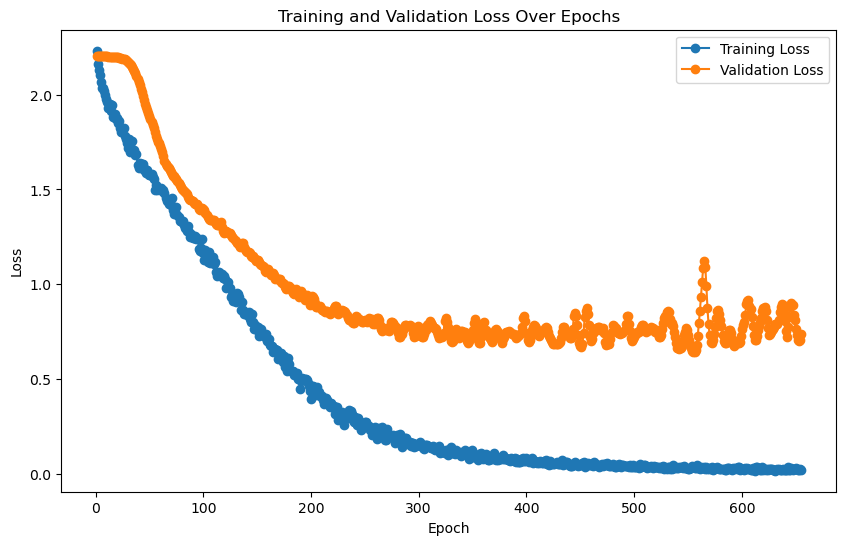

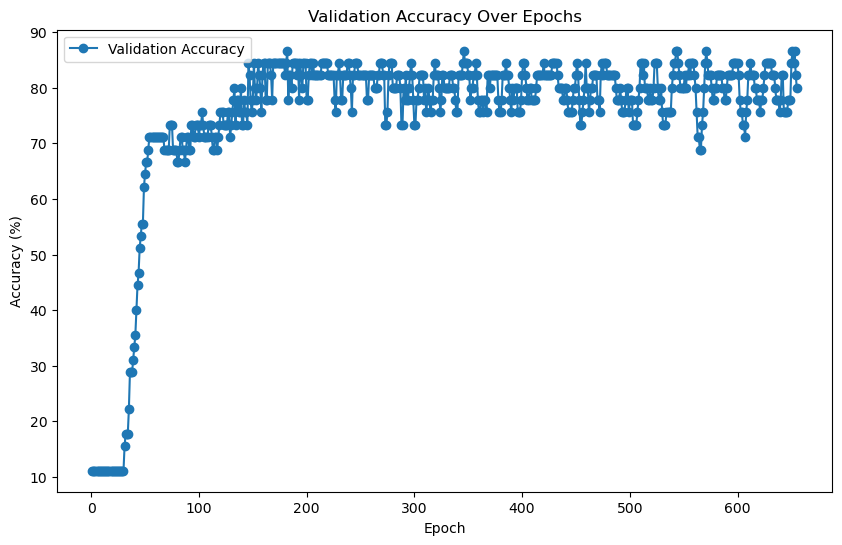


Evaluating on the test set...
    Test Batch [1/167], Loss: 1.7239



Final Test Loss: 0.8983, Test Accuracy: 72.57%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.


  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.


  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)

LOG: Training features shape: (90, 64), Training labels shape: (90,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42641, 64), Test labels shape: (42641,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 73.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.43      0.60      0.50         5
           2       0.80      0.80      0.80         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       0.33      0.20      0.25         5
           6       0.57      0.80      0.67         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)
Train reps shape: (90, 64)
Train labels shape: (90,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42641, 64)
Test labels shape: (42641,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5727  |  Val Loss: 2.3196
Validation loss improved from inf to 2.3196.
[Epoch 2/1000] Train Loss: 2.2673  |  Val Loss: 2.1634
Validation loss improved from 2.3196 to 2.1634.
[Epoch 3/1000] Train Loss: 2.1184  |  Val Loss: 2.0592
Validation loss improved from 2.1634 to 2.0592.
[Epoch 4/1000] Train Loss: 2.0070  |  Val Loss: 1.9826
Validation loss improved from 2.0592 to 1.9826.
[Epoch 5/1000] Train Loss: 1.9293  |  Val Loss: 1.9258
Validation loss improved from 1.9826 to 1.9258.
[Epoch 6/1000] Train Loss: 1.8673  |  Val Loss: 1.8779
Validation loss improved from 1.9258 to 1.8779.
[Epoch 7/1000] Train Loss: 1.8202  |  Val Loss: 1.8338
Validation loss improved from 1.8779 to 1.8338.
[Epoch 8/1000] Train Loss: 1.7709  |  Val Loss: 1.7881
Validation loss improved from 1.8338 to 1.7881.


[Epoch 9/1000] Train Loss: 1.7185  |  Val Loss: 1.7426
Validation loss improved from 1.7881 to 1.7426.
[Epoch 10/1000] Train Loss: 1.6668  |  Val Loss: 1.6966
Validation loss improved from 1.7426 to 1.6966.
[Epoch 11/1000] Train Loss: 1.6153  |  Val Loss: 1.6478
Validation loss improved from 1.6966 to 1.6478.
[Epoch 12/1000] Train Loss: 1.5642  |  Val Loss: 1.6003
Validation loss improved from 1.6478 to 1.6003.
[Epoch 13/1000] Train Loss: 1.5122  |  Val Loss: 1.5548
Validation loss improved from 1.6003 to 1.5548.
[Epoch 14/1000] Train Loss: 1.4622  |  Val Loss: 1.5112
Validation loss improved from 1.5548 to 1.5112.
[Epoch 15/1000] Train Loss: 1.4094  |  Val Loss: 1.4699
Validation loss improved from 1.5112 to 1.4699.
[Epoch 16/1000] Train Loss: 1.3586  |  Val Loss: 1.4315
Validation loss improved from 1.4699 to 1.4315.
[Epoch 17/1000] Train Loss: 1.3076  |  Val Loss: 1.3937
Validation loss improved from 1.4315 to 1.3937.
[Epoch 18/1000] Train Loss: 1.2579  |  Val Loss: 1.3547
Validatio

[Epoch 32/1000] Train Loss: 0.7238  |  Val Loss: 0.8665
Validation loss improved from 0.8937 to 0.8665.
[Epoch 33/1000] Train Loss: 0.6983  |  Val Loss: 0.8461
Validation loss improved from 0.8665 to 0.8461.
[Epoch 34/1000] Train Loss: 0.6764  |  Val Loss: 0.8297
Validation loss improved from 0.8461 to 0.8297.
[Epoch 35/1000] Train Loss: 0.6515  |  Val Loss: 0.8194
Validation loss improved from 0.8297 to 0.8194.
[Epoch 36/1000] Train Loss: 0.6336  |  Val Loss: 0.8076
Validation loss improved from 0.8194 to 0.8076.
[Epoch 37/1000] Train Loss: 0.6134  |  Val Loss: 0.7867
Validation loss improved from 0.8076 to 0.7867.
[Epoch 38/1000] Train Loss: 0.5964  |  Val Loss: 0.7645
Validation loss improved from 0.7867 to 0.7645.
[Epoch 39/1000] Train Loss: 0.5764  |  Val Loss: 0.7530
Validation loss improved from 0.7645 to 0.7530.
[Epoch 40/1000] Train Loss: 0.5593  |  Val Loss: 0.7517
Validation loss improved from 0.7530 to 0.7517.
[Epoch 41/1000] Train Loss: 0.5426  |  Val Loss: 0.7505
Validati

[Epoch 50/1000] Train Loss: 0.4246  |  Val Loss: 0.6555
Validation loss improved from 0.6712 to 0.6555.
[Epoch 51/1000] Train Loss: 0.4142  |  Val Loss: 0.6513
Validation loss improved from 0.6555 to 0.6513.
[Epoch 52/1000] Train Loss: 0.4061  |  Val Loss: 0.6555
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 53/1000] Train Loss: 0.4036  |  Val Loss: 0.6530
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 54/1000] Train Loss: 0.3891  |  Val Loss: 0.6445
Validation loss improved from 0.6513 to 0.6445.
[Epoch 55/1000] Train Loss: 0.3855  |  Val Loss: 0.6380
Validation loss improved from 0.6445 to 0.6380.
[Epoch 56/1000] Train Loss: 0.3780  |  Val Loss: 0.6356
Validation loss improved from 0.6380 to 0.6356.
[Epoch 57/1000] Train Loss: 0.3669  |  Val Loss: 0.6346
Validation loss improved from 0.6356 to 0.6346.
[Epoch 58/1000] Train Loss: 0.3572  |  Val Loss: 0.6398
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 0.3492  |  Val Los

[Epoch 80/1000] Train Loss: 0.2603  |  Val Loss: 0.6301
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 81/1000] Train Loss: 0.2580  |  Val Loss: 0.6182
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 82/1000] Train Loss: 0.2583  |  Val Loss: 0.6104
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 83/1000] Train Loss: 0.2597  |  Val Loss: 0.6126
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 84/1000] Train Loss: 0.2525  |  Val Loss: 0.6236
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 85/1000] Train Loss: 0.2443  |  Val Loss: 0.6542
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 86/1000] Train Loss: 0.2434  |  Val Loss: 0.6679
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 87/1000] Train Loss: 0.2429  |  Val Loss: 0.6481
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 88/1000] Train Loss: 0.2324  |  Val Loss: 0.6249
!! Validation loss did NOT improve !! Patience: 22/100
[

[Epoch 97/1000] Train Loss: 0.2129  |  Val Loss: 0.6305
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 98/1000] Train Loss: 0.2120  |  Val Loss: 0.6349
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 99/1000] Train Loss: 0.2082  |  Val Loss: 0.6410
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 100/1000] Train Loss: 0.2009  |  Val Loss: 0.6507
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 101/1000] Train Loss: 0.1999  |  Val Loss: 0.6586
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 102/1000] Train Loss: 0.1969  |  Val Loss: 0.6688
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 103/1000] Train Loss: 0.1977  |  Val Loss: 0.6773
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 104/1000] Train Loss: 0.1941  |  Val Loss: 0.6839
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 105/1000] Train Loss: 0.1917  |  Val Loss: 0.6885
!! Validation loss did NOT improve !! Patience: 39

[Epoch 125/1000] Train Loss: 0.1443  |  Val Loss: 0.7258
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 126/1000] Train Loss: 0.1462  |  Val Loss: 0.7553
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 127/1000] Train Loss: 0.1599  |  Val Loss: 0.7471
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 128/1000] Train Loss: 0.1465  |  Val Loss: 0.7231
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 129/1000] Train Loss: 0.1412  |  Val Loss: 0.7395
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 130/1000] Train Loss: 0.1524  |  Val Loss: 0.7451
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 131/1000] Train Loss: 0.1470  |  Val Loss: 0.7434
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 132/1000] Train Loss: 0.1354  |  Val Loss: 0.7640
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 133/1000] Train Loss: 0.1374  |  Val Loss: 0.7862
!! Validation loss did NOT improve !! Patience:

[Epoch 146/1000] Train Loss: 0.1182  |  Val Loss: 0.7984
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 147/1000] Train Loss: 0.1109  |  Val Loss: 0.8209
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 148/1000] Train Loss: 0.1095  |  Val Loss: 0.8239
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 149/1000] Train Loss: 0.1092  |  Val Loss: 0.8011
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 150/1000] Train Loss: 0.1092  |  Val Loss: 0.8057
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 151/1000] Train Loss: 0.1071  |  Val Loss: 0.8344
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 152/1000] Train Loss: 0.1062  |  Val Loss: 0.8566
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 153/1000] Train Loss: 0.1094  |  Val Loss: 0.8355
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 154/1000] Train Loss: 0.1041  |  Val Loss: 0.8233
!! Validation loss did NOT improve !! Patience:

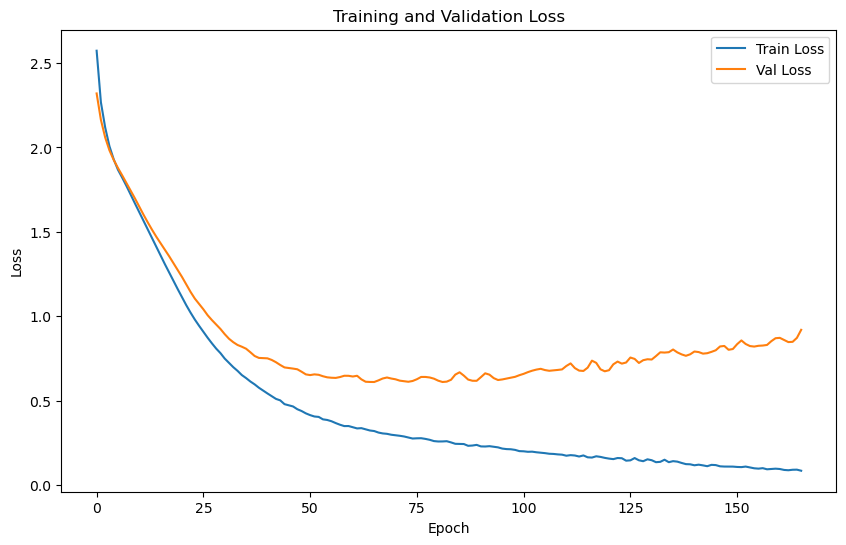

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.8937 | Test Accuracy: 70.98%


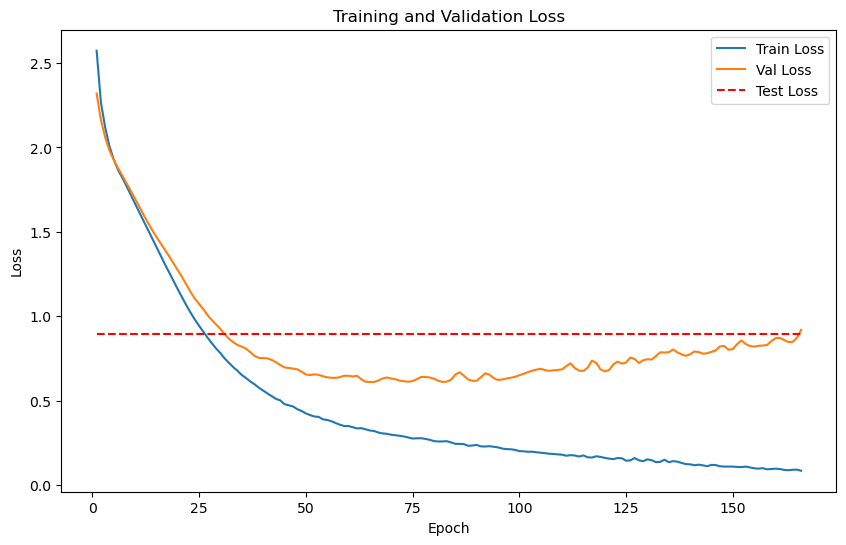

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42641, 64), 
Test labels shape: (42641,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 7.9887
Epoch [1/2000], Avg Train Loss: 7.9887
Epoch [1/2000], Avg Val Loss: 3.6475
Validation loss improved from inf to 3.6475. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.9032
Epoch [2/2000], Avg Train Loss: 7.9032
Epoch [2/2000], Avg Val Loss: 3.6195
Validation loss improved from 3.6475 to 3.6195. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.9653
Epoch [3/2000], Avg Train Loss: 7.9653
Epoch [3/2000], Avg Val Loss: 3.5920
Validation loss improved from 3.6195 to 3.5920. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.7175
Epoch [4/2000], Avg Train Loss: 7.7175
Epoch [4/2000], Avg Val Loss: 3.5652
Validation loss improved from 3.5920 to 3.5652. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.9988
Epoch [5/2000], Avg Train Loss: 7.9988
Epoch [5/2000], Avg Val Loss: 3.5393
Validation loss improved fr

    Batch [1/1], Train Loss: 7.4076
Epoch [10/2000], Avg Train Loss: 7.4076
Epoch [10/2000], Avg Val Loss: 3.4200
Validation loss improved from 3.4425 to 3.4200. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 7.4064
Epoch [11/2000], Avg Train Loss: 7.4064
Epoch [11/2000], Avg Val Loss: 3.3979
Validation loss improved from 3.4200 to 3.3979. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 7.3574
Epoch [12/2000], Avg Train Loss: 7.3574
Epoch [12/2000], Avg Val Loss: 3.3765
Validation loss improved from 3.3979 to 3.3765. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.4010
Epoch [13/2000], Avg Train Loss: 7.4010
Epoch [13/2000], Avg Val Loss: 3.3559
Validation loss improved from 3.3765 to 3.3559. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.1234
Epoch [14/2000], Avg Train Loss: 7.1234
Epoch [14/2000], Avg Val Loss: 3.3357
Validation loss improved from 3.3559 to 3.

Epoch [21/2000], Avg Val Loss: 3.2103
Validation loss improved from 3.2267 to 3.2103. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.5371
Epoch [22/2000], Avg Train Loss: 6.5371
Epoch [22/2000], Avg Val Loss: 3.1946
Validation loss improved from 3.2103 to 3.1946. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.7169
Epoch [23/2000], Avg Train Loss: 6.7169
Epoch [23/2000], Avg Val Loss: 3.1793
Validation loss improved from 3.1946 to 3.1793. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.1247
Epoch [24/2000], Avg Train Loss: 6.1247
Epoch [24/2000], Avg Val Loss: 3.1645
Validation loss improved from 3.1793 to 3.1645. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.7075
Epoch [25/2000], Avg Train Loss: 6.7075
Epoch [25/2000], Avg Val Loss: 3.1500
Validation loss improved from 3.1645 to 3.1500. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.4114
Epoch [30/2000], Avg Train Loss: 6.4114
Epoch [30/2000], Avg Val Loss: 3.0841
Validation loss improved from 3.0964 to 3.0841. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.2559
Epoch [31/2000], Avg Train Loss: 6.2559
Epoch [31/2000], Avg Val Loss: 3.0723
Validation loss improved from 3.0841 to 3.0723. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.3942
Epoch [32/2000], Avg Train Loss: 6.3942
Epoch [32/2000], Avg Val Loss: 3.0609
Validation loss improved from 3.0723 to 3.0609. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.0429
Epoch [33/2000], Avg Train Loss: 6.0429
Epoch [33/2000], Avg Val Loss: 3.0498
Validation loss improved from 3.0609 to 3.0498. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.0664
Epoch [34/2000], Avg Train Loss: 6.0664
Epoch [34/2000], Avg Val Loss: 3.0392
Validation loss improved from 3.0498 to 3.

    Batch [1/1], Train Loss: 4.9184
Epoch [63/2000], Avg Train Loss: 4.9184
Epoch [63/2000], Avg Val Loss: 2.8541
Validation loss improved from 2.8577 to 2.8541. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.0997
Epoch [64/2000], Avg Train Loss: 5.0997
Epoch [64/2000], Avg Val Loss: 2.8506
Validation loss improved from 2.8541 to 2.8506. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 4.9805
Epoch [65/2000], Avg Train Loss: 4.9805
Epoch [65/2000], Avg Val Loss: 2.8473
Validation loss improved from 2.8506 to 2.8473. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 4.9594
Epoch [66/2000], Avg Train Loss: 4.9594
Epoch [66/2000], Avg Val Loss: 2.8442
Validation loss improved from 2.8473 to 2.8442. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 5.0613
Epoch [67/2000], Avg Train Loss: 5.0613
Epoch [67/2000], Avg Val Loss: 2.8412
Validation loss improved from 2.8442 to 2.

    Batch [1/1], Train Loss: 4.9606
Epoch [73/2000], Avg Train Loss: 4.9606


Epoch [73/2000], Avg Val Loss: 2.8251
Validation loss improved from 2.8275 to 2.8251. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 4.9346
Epoch [74/2000], Avg Train Loss: 4.9346
Epoch [74/2000], Avg Val Loss: 2.8227
Validation loss improved from 2.8251 to 2.8227. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 4.8860
Epoch [75/2000], Avg Train Loss: 4.8860
Epoch [75/2000], Avg Val Loss: 2.8203
Validation loss improved from 2.8227 to 2.8203. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 4.8653
Epoch [76/2000], Avg Train Loss: 4.8653
Epoch [76/2000], Avg Val Loss: 2.8180
Validation loss improved from 2.8203 to 2.8180. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 4.8332
Epoch [77/2000], Avg Train Loss: 4.8332
Epoch [77/2000], Avg Val Loss: 2.8158
Validation loss improved from 2.8180 to 2.8158. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.3357
Epoch [107/2000], Avg Train Loss: 4.3357
Epoch [107/2000], Avg Val Loss: 2.7716
Validation loss improved from 2.7727 to 2.7716. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.4436
Epoch [108/2000], Avg Train Loss: 4.4436
Epoch [108/2000], Avg Val Loss: 2.7705
Validation loss improved from 2.7716 to 2.7705. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.4423
Epoch [109/2000], Avg Train Loss: 4.4423
Epoch [109/2000], Avg Val Loss: 2.7694
Validation loss improved from 2.7705 to 2.7694. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.3403
Epoch [110/2000], Avg Train Loss: 4.3403
Epoch [110/2000], Avg Val Loss: 2.7684
Validation loss improved from 2.7694 to 2.7684. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.3289
Epoch [111/2000], Avg Train Loss: 4.3289
Epoch [111/2000], Avg Val Loss: 2.7673
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2545
Epoch [123/2000], Avg Train Loss: 4.2545
Epoch [123/2000], Avg Val Loss: 2.7551
Validation loss improved from 2.7561 to 2.7551. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 4.2375
Epoch [124/2000], Avg Train Loss: 4.2375
Epoch [124/2000], Avg Val Loss: 2.7540
Validation loss improved from 2.7551 to 2.7540. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 4.2643
Epoch [125/2000], Avg Train Loss: 4.2643
Epoch [125/2000], Avg Val Loss: 2.7529
Validation loss improved from 2.7540 to 2.7529. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.1671
Epoch [126/2000], Avg Train Loss: 4.1671
Epoch [126/2000], Avg Val Loss: 2.7519
Validation loss improved from 2.7529 to 2.7519. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.2470
Epoch [127/2000], Avg Train Loss: 4.2470
Epoch [127/2000], Avg Val Loss: 2.7508
Validation loss improved fro

Epoch [155/2000], Avg Val Loss: 2.7223
Validation loss improved from 2.7233 to 2.7223. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 3.9975
Epoch [156/2000], Avg Train Loss: 3.9975
Epoch [156/2000], Avg Val Loss: 2.7213
Validation loss improved from 2.7223 to 2.7213. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.0856
Epoch [157/2000], Avg Train Loss: 4.0856
Epoch [157/2000], Avg Val Loss: 2.7204
Validation loss improved from 2.7213 to 2.7204. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.0908
Epoch [158/2000], Avg Train Loss: 4.0908
Epoch [158/2000], Avg Val Loss: 2.7194
Validation loss improved from 2.7204 to 2.7194. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.0607
Epoch [159/2000], Avg Train Loss: 4.0607
Epoch [159/2000], Avg Val Loss: 2.7184
Validation loss improved from 2.7194 to 2.7184. Saving model...

LOG: Epoch [160/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9887
Epoch [171/2000], Avg Train Loss: 3.9887
Epoch [171/2000], Avg Val Loss: 2.7062
Validation loss improved from 2.7073 to 2.7062. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 3.9472
Epoch [172/2000], Avg Train Loss: 3.9472
Epoch [172/2000], Avg Val Loss: 2.7051
Validation loss improved from 2.7062 to 2.7051. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 4.0941
Epoch [173/2000], Avg Train Loss: 4.0941
Epoch [173/2000], Avg Val Loss: 2.7041
Validation loss improved from 2.7051 to 2.7041. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.0427
Epoch [174/2000], Avg Train Loss: 4.0427
Epoch [174/2000], Avg Val Loss: 2.7031
Validation loss improved from 2.7041 to 2.7031. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 3.9197
Epoch [175/2000], Avg Train Loss: 3.9197
Epoch [175/2000], Avg Val Loss: 2.7020
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8285
Epoch [202/2000], Avg Train Loss: 3.8285
Epoch [202/2000], Avg Val Loss: 2.6727
Validation loss improved from 2.6738 to 2.6727. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 3.8320
Epoch [203/2000], Avg Train Loss: 3.8320
Epoch [203/2000], Avg Val Loss: 2.6716
Validation loss improved from 2.6727 to 2.6716. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 3.8780
Epoch [204/2000], Avg Train Loss: 3.8780
Epoch [204/2000], Avg Val Loss: 2.6705
Validation loss improved from 2.6716 to 2.6705. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 3.8961
Epoch [205/2000], Avg Train Loss: 3.8961
Epoch [205/2000], Avg Val Loss: 2.6695
Validation loss improved from 2.6705 to 2.6695. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 3.7972
Epoch [206/2000], Avg Train Loss: 3.7972
Epoch [206/2000], Avg Val Loss: 2.6684
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8468
Epoch [217/2000], Avg Train Loss: 3.8468
Epoch [217/2000], Avg Val Loss: 2.6568
Validation loss improved from 2.6578 to 2.6568. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 3.8103
Epoch [218/2000], Avg Train Loss: 3.8103
Epoch [218/2000], Avg Val Loss: 2.6557
Validation loss improved from 2.6568 to 2.6557. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 3.8294
Epoch [219/2000], Avg Train Loss: 3.8294
Epoch [219/2000], Avg Val Loss: 2.6547
Validation loss improved from 2.6557 to 2.6547. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 3.8925
Epoch [220/2000], Avg Train Loss: 3.8925
Epoch [220/2000], Avg Val Loss: 2.6537
Validation loss improved from 2.6547 to 2.6537. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 3.8226
Epoch [221/2000], Avg Train Loss: 3.8226
Epoch [221/2000], Avg Val Loss: 2.6528
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8149
Epoch [242/2000], Avg Train Loss: 3.8149
Epoch [242/2000], Avg Val Loss: 2.6318
Validation loss improved from 2.6328 to 2.6318. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 3.7810
Epoch [243/2000], Avg Train Loss: 3.7810
Epoch [243/2000], Avg Val Loss: 2.6308
Validation loss improved from 2.6318 to 2.6308. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 3.7925
Epoch [244/2000], Avg Train Loss: 3.7925
Epoch [244/2000], Avg Val Loss: 2.6298
Validation loss improved from 2.6308 to 2.6298. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 3.7572
Epoch [245/2000], Avg Train Loss: 3.7572
Epoch [245/2000], Avg Val Loss: 2.6288
Validation loss improved from 2.6298 to 2.6288. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 3.7780
Epoch [246/2000], Avg Train Loss: 3.7780
Epoch [246/2000], Avg Val Loss: 2.6278
Validation loss improved fro

Epoch [259/2000], Avg Val Loss: 2.6148
Validation loss improved from 2.6158 to 2.6148. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 3.7001
Epoch [260/2000], Avg Train Loss: 3.7001
Epoch [260/2000], Avg Val Loss: 2.6138
Validation loss improved from 2.6148 to 2.6138. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 3.6653
Epoch [261/2000], Avg Train Loss: 3.6653
Epoch [261/2000], Avg Val Loss: 2.6128
Validation loss improved from 2.6138 to 2.6128. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 3.8151
Epoch [262/2000], Avg Train Loss: 3.8151
Epoch [262/2000], Avg Val Loss: 2.6119
Validation loss improved from 2.6128 to 2.6119. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 3.6945
Epoch [263/2000], Avg Train Loss: 3.6945
Epoch [263/2000], Avg Val Loss: 2.6109
Validation loss improved from 2.6119 to 2.6109. Saving model...

LOG: Epoch [264/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6578
Epoch [285/2000], Avg Train Loss: 3.6578
Epoch [285/2000], Avg Val Loss: 2.5894
Validation loss improved from 2.5903 to 2.5894. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 3.6098
Epoch [286/2000], Avg Train Loss: 3.6098
Epoch [286/2000], Avg Val Loss: 2.5885
Validation loss improved from 2.5894 to 2.5885. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 3.6204
Epoch [287/2000], Avg Train Loss: 3.6204
Epoch [287/2000], Avg Val Loss: 2.5875
Validation loss improved from 2.5885 to 2.5875. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 3.6466
Epoch [288/2000], Avg Train Loss: 3.6466
Epoch [288/2000], Avg Val Loss: 2.5866
Validation loss improved from 2.5875 to 2.5866. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 3.6335
Epoch [289/2000], Avg Train Loss: 3.6335
Epoch [289/2000], Avg Val Loss: 2.5857
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6373
Epoch [307/2000], Avg Train Loss: 3.6373
Epoch [307/2000], Avg Val Loss: 2.5706
Validation loss improved from 2.5714 to 2.5706. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 3.5812
Epoch [308/2000], Avg Train Loss: 3.5812
Epoch [308/2000], Avg Val Loss: 2.5698
Validation loss improved from 2.5706 to 2.5698. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 3.6548
Epoch [309/2000], Avg Train Loss: 3.6548
Epoch [309/2000], Avg Val Loss: 2.5690
Validation loss improved from 2.5698 to 2.5690. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 3.6612
Epoch [310/2000], Avg Train Loss: 3.6612
Epoch [310/2000], Avg Val Loss: 2.5681
Validation loss improved from 2.5690 to 2.5681. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 3.5635
Epoch [311/2000], Avg Train Loss: 3.5635
Epoch [311/2000], Avg Val Loss: 2.5673
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5675
Epoch [329/2000], Avg Train Loss: 3.5675
Epoch [329/2000], Avg Val Loss: 2.5532
Validation loss improved from 2.5539 to 2.5532. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 3.5811
Epoch [330/2000], Avg Train Loss: 3.5811
Epoch [330/2000], Avg Val Loss: 2.5524
Validation loss improved from 2.5532 to 2.5524. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 3.5645
Epoch [331/2000], Avg Train Loss: 3.5645
Epoch [331/2000], Avg Val Loss: 2.5517
Validation loss improved from 2.5524 to 2.5517. Saving model...

LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 3.5686
Epoch [332/2000], Avg Train Loss: 3.5686
Epoch [332/2000], Avg Val Loss: 2.5510
Validation loss improved from 2.5517 to 2.5510. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 3.6068
Epoch [333/2000], Avg Train Loss: 3.6068
Epoch [333/2000], Avg Val Loss: 2.5502
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5617
Epoch [352/2000], Avg Train Loss: 3.5617
Epoch [352/2000], Avg Val Loss: 2.5362
Validation loss improved from 2.5369 to 2.5362. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 3.5765
Epoch [353/2000], Avg Train Loss: 3.5765
Epoch [353/2000], Avg Val Loss: 2.5355
Validation loss improved from 2.5362 to 2.5355. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 3.5428
Epoch [354/2000], Avg Train Loss: 3.5428
Epoch [354/2000], Avg Val Loss: 2.5347
Validation loss improved from 2.5355 to 2.5347. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 3.5018
Epoch [355/2000], Avg Train Loss: 3.5018
Epoch [355/2000], Avg Val Loss: 2.5340
Validation loss improved from 2.5347 to 2.5340. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 3.5454
Epoch [356/2000], Avg Train Loss: 3.5454
Epoch [356/2000], Avg Val Loss: 2.5333
Validation loss improved fro

Epoch [378/2000], Avg Val Loss: 2.5177
Validation loss improved from 2.5183 to 2.5177. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 3.5152
Epoch [379/2000], Avg Train Loss: 3.5152
Epoch [379/2000], Avg Val Loss: 2.5170
Validation loss improved from 2.5177 to 2.5170. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 3.4907
Epoch [380/2000], Avg Train Loss: 3.4907
Epoch [380/2000], Avg Val Loss: 2.5163
Validation loss improved from 2.5170 to 2.5163. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 3.4597
Epoch [381/2000], Avg Train Loss: 3.4597
Epoch [381/2000], Avg Val Loss: 2.5157
Validation loss improved from 2.5163 to 2.5157. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 3.4770
Epoch [382/2000], Avg Train Loss: 3.4770
Epoch [382/2000], Avg Val Loss: 2.5150
Validation loss improved from 2.5157 to 2.5150. Saving model...

LOG: Epoch [383/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4966
Epoch [401/2000], Avg Train Loss: 3.4966
Epoch [401/2000], Avg Val Loss: 2.5031
Validation loss improved from 2.5037 to 2.5031. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 3.5034
Epoch [402/2000], Avg Train Loss: 3.5034
Epoch [402/2000], Avg Val Loss: 2.5025
Validation loss improved from 2.5031 to 2.5025. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 3.4718
Epoch [403/2000], Avg Train Loss: 3.4718
Epoch [403/2000], Avg Val Loss: 2.5019
Validation loss improved from 2.5025 to 2.5019. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 3.4774
Epoch [404/2000], Avg Train Loss: 3.4774
Epoch [404/2000], Avg Val Loss: 2.5013
Validation loss improved from 2.5019 to 2.5013. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 3.4510
Epoch [405/2000], Avg Train Loss: 3.4510
Epoch [405/2000], Avg Val Loss: 2.5007
Validation loss improved fro

Epoch [427/2000], Avg Val Loss: 2.4885
Validation loss improved from 2.4891 to 2.4885. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 3.4564
Epoch [428/2000], Avg Train Loss: 3.4564
Epoch [428/2000], Avg Val Loss: 2.4880
Validation loss improved from 2.4885 to 2.4880. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 3.4133
Epoch [429/2000], Avg Train Loss: 3.4133
Epoch [429/2000], Avg Val Loss: 2.4874
Validation loss improved from 2.4880 to 2.4874. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 3.4265
Epoch [430/2000], Avg Train Loss: 3.4265
Epoch [430/2000], Avg Val Loss: 2.4869
Validation loss improved from 2.4874 to 2.4869. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 3.4317
Epoch [431/2000], Avg Train Loss: 3.4317
Epoch [431/2000], Avg Val Loss: 2.4863
Validation loss improved from 2.4869 to 2.4863. Saving model...

LOG: Epoch [432/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3904
Epoch [446/2000], Avg Train Loss: 3.3904
Epoch [446/2000], Avg Val Loss: 2.4787
Validation loss improved from 2.4792 to 2.4787. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 3.4119
Epoch [447/2000], Avg Train Loss: 3.4119
Epoch [447/2000], Avg Val Loss: 2.4782
Validation loss improved from 2.4787 to 2.4782. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 3.4048
Epoch [448/2000], Avg Train Loss: 3.4048
Epoch [448/2000], Avg Val Loss: 2.4777
Validation loss improved from 2.4782 to 2.4777. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 3.4370
Epoch [449/2000], Avg Train Loss: 3.4370
Epoch [449/2000], Avg Val Loss: 2.4772
Validation loss improved from 2.4777 to 2.4772. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 3.3804
Epoch [450/2000], Avg Train Loss: 3.3804
Epoch [450/2000], Avg Val Loss: 2.4768
Validation loss improved fro

Epoch [470/2000], Avg Val Loss: 2.4670
Validation loss improved from 2.4675 to 2.4670. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 3.3587
Epoch [471/2000], Avg Train Loss: 3.3587
Epoch [471/2000], Avg Val Loss: 2.4665
Validation loss improved from 2.4670 to 2.4665. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 3.3912
Epoch [472/2000], Avg Train Loss: 3.3912
Epoch [472/2000], Avg Val Loss: 2.4660
Validation loss improved from 2.4665 to 2.4660. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 3.4240
Epoch [473/2000], Avg Train Loss: 3.4240
Epoch [473/2000], Avg Val Loss: 2.4655
Validation loss improved from 2.4660 to 2.4655. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 3.4244
Epoch [474/2000], Avg Train Loss: 3.4244
Epoch [474/2000], Avg Val Loss: 2.4651
Validation loss improved from 2.4655 to 2.4651. Saving model...

LOG: Epoch [475/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3540
Epoch [498/2000], Avg Train Loss: 3.3540
Epoch [498/2000], Avg Val Loss: 2.4563
Validation loss improved from 2.4567 to 2.4563. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 3.3359
Epoch [499/2000], Avg Train Loss: 3.3359
Epoch [499/2000], Avg Val Loss: 2.4559
Validation loss improved from 2.4563 to 2.4559. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 3.3563
Epoch [500/2000], Avg Train Loss: 3.3563
Epoch [500/2000], Avg Val Loss: 2.4556
Validation loss improved from 2.4559 to 2.4556. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 3.3302
Epoch [501/2000], Avg Train Loss: 3.3302
Epoch [501/2000], Avg Val Loss: 2.4552
Validation loss improved from 2.4556 to 2.4552. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 3.4065
Epoch [502/2000], Avg Train Loss: 3.4065
Epoch [502/2000], Avg Val Loss: 2.4549
Validation loss improved fro

Epoch [521/2000], Avg Val Loss: 2.4449
Validation loss improved from 2.4455 to 2.4449. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 3.2968
Epoch [522/2000], Avg Train Loss: 3.2968
Epoch [522/2000], Avg Val Loss: 2.4444
Validation loss improved from 2.4449 to 2.4444. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 3.3692
Epoch [523/2000], Avg Train Loss: 3.3692
Epoch [523/2000], Avg Val Loss: 2.4439
Validation loss improved from 2.4444 to 2.4439. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 3.3321
Epoch [524/2000], Avg Train Loss: 3.3321
Epoch [524/2000], Avg Val Loss: 2.4434
Validation loss improved from 2.4439 to 2.4434. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 3.4233
Epoch [525/2000], Avg Train Loss: 3.4233
Epoch [525/2000], Avg Val Loss: 2.4429
Validation loss improved from 2.4434 to 2.4429. Saving model...

LOG: Epoch [526/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2585
Epoch [543/2000], Avg Train Loss: 3.2585
Epoch [543/2000], Avg Val Loss: 2.4350
Validation loss improved from 2.4354 to 2.4350. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 3.3225
Epoch [544/2000], Avg Train Loss: 3.3225
Epoch [544/2000], Avg Val Loss: 2.4345
Validation loss improved from 2.4350 to 2.4345. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 3.3417
Epoch [545/2000], Avg Train Loss: 3.3417
Epoch [545/2000], Avg Val Loss: 2.4341
Validation loss improved from 2.4345 to 2.4341. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 3.2912
Epoch [546/2000], Avg Train Loss: 3.2912
Epoch [546/2000], Avg Val Loss: 2.4337
Validation loss improved from 2.4341 to 2.4337. Saving model...

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 3.2894
Epoch [547/2000], Avg Train Loss: 3.2894
Epoch [547/2000], Avg Val Loss: 2.4333
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3139
Epoch [569/2000], Avg Train Loss: 3.3139
Epoch [569/2000], Avg Val Loss: 2.4260
Validation loss improved from 2.4263 to 2.4260. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 3.3039
Epoch [570/2000], Avg Train Loss: 3.3039
Epoch [570/2000], Avg Val Loss: 2.4256
Validation loss improved from 2.4260 to 2.4256. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 3.3407
Epoch [571/2000], Avg Train Loss: 3.3407
Epoch [571/2000], Avg Val Loss: 2.4253
Validation loss improved from 2.4256 to 2.4253. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 3.3068
Epoch [572/2000], Avg Train Loss: 3.3068
Epoch [572/2000], Avg Val Loss: 2.4250
Validation loss improved from 2.4253 to 2.4250. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 3.2625
Epoch [573/2000], Avg Train Loss: 3.2625
Epoch [573/2000], Avg Val Loss: 2.4247
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2970
Epoch [591/2000], Avg Train Loss: 3.2970
Epoch [591/2000], Avg Val Loss: 2.4182
Validation loss improved from 2.4185 to 2.4182. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 3.3015
Epoch [592/2000], Avg Train Loss: 3.3015
Epoch [592/2000], Avg Val Loss: 2.4178
Validation loss improved from 2.4182 to 2.4178. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 3.2799
Epoch [593/2000], Avg Train Loss: 3.2799
Epoch [593/2000], Avg Val Loss: 2.4175
Validation loss improved from 2.4178 to 2.4175. Saving model...

LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 3.2291
Epoch [594/2000], Avg Train Loss: 3.2291
Epoch [594/2000], Avg Val Loss: 2.4171
Validation loss improved from 2.4175 to 2.4171. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 3.2994
Epoch [595/2000], Avg Train Loss: 3.2994
Epoch [595/2000], Avg Val Loss: 2.4168
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2960
Epoch [620/2000], Avg Train Loss: 3.2960
Epoch [620/2000], Avg Val Loss: 2.4080
Validation loss improved from 2.4084 to 2.4080. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 3.2276
Epoch [621/2000], Avg Train Loss: 3.2276
Epoch [621/2000], Avg Val Loss: 2.4076
Validation loss improved from 2.4080 to 2.4076. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 3.3363
Epoch [622/2000], Avg Train Loss: 3.3363
Epoch [622/2000], Avg Val Loss: 2.4073
Validation loss improved from 2.4076 to 2.4073. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 3.2434
Epoch [623/2000], Avg Train Loss: 3.2434
Epoch [623/2000], Avg Val Loss: 2.4070
Validation loss improved from 2.4073 to 2.4070. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 3.3161
Epoch [624/2000], Avg Train Loss: 3.3161
Epoch [624/2000], Avg Val Loss: 2.4067
Validation loss improved fro

Epoch [640/2000], Avg Val Loss: 2.4026
Validation loss improved from 2.4028 to 2.4026. Saving model...

LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 3.2688
Epoch [641/2000], Avg Train Loss: 3.2688
Epoch [641/2000], Avg Val Loss: 2.4023
Validation loss improved from 2.4026 to 2.4023. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 3.2438
Epoch [642/2000], Avg Train Loss: 3.2438
Epoch [642/2000], Avg Val Loss: 2.4021
Validation loss improved from 2.4023 to 2.4021. Saving model...

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 3.2206
Epoch [643/2000], Avg Train Loss: 3.2206
Epoch [643/2000], Avg Val Loss: 2.4018
Validation loss improved from 2.4021 to 2.4018. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 3.2462
Epoch [644/2000], Avg Train Loss: 3.2462
Epoch [644/2000], Avg Val Loss: 2.4015
Validation loss improved from 2.4018 to 2.4015. Saving model...

LOG: Epoch [645/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2620
Epoch [667/2000], Avg Train Loss: 3.2620
Epoch [667/2000], Avg Val Loss: 2.3959
Validation loss improved from 2.3961 to 2.3959. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 3.1985
Epoch [668/2000], Avg Train Loss: 3.1985
Epoch [668/2000], Avg Val Loss: 2.3957
Validation loss improved from 2.3959 to 2.3957. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 3.2468
Epoch [669/2000], Avg Train Loss: 3.2468
Epoch [669/2000], Avg Val Loss: 2.3955
Validation loss improved from 2.3957 to 2.3955. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 3.2436
Epoch [670/2000], Avg Train Loss: 3.2436
Epoch [670/2000], Avg Val Loss: 2.3952
Validation loss improved from 2.3955 to 2.3952. Saving model...

LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 3.1783
Epoch [671/2000], Avg Train Loss: 3.1783
Epoch [671/2000], Avg Val Loss: 2.3950
Validation loss improved fro

Epoch [685/2000], Avg Val Loss: 2.3914
Validation loss improved from 2.3916 to 2.3914. Saving model...

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 3.2028
Epoch [686/2000], Avg Train Loss: 3.2028
Epoch [686/2000], Avg Val Loss: 2.3912
Validation loss improved from 2.3914 to 2.3912. Saving model...

LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 3.1786
Epoch [687/2000], Avg Train Loss: 3.1786
Epoch [687/2000], Avg Val Loss: 2.3910
Validation loss improved from 2.3912 to 2.3910. Saving model...

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 3.2167
Epoch [688/2000], Avg Train Loss: 3.2167
Epoch [688/2000], Avg Val Loss: 2.3907
Validation loss improved from 2.3910 to 2.3907. Saving model...

LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 3.2120
Epoch [689/2000], Avg Train Loss: 3.2120
Epoch [689/2000], Avg Val Loss: 2.3905
Validation loss improved from 2.3907 to 2.3905. Saving model...

LOG: Epoch [690/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2967
Epoch [712/2000], Avg Train Loss: 3.2967
Epoch [712/2000], Avg Val Loss: 2.3863
Validation loss improved from 2.3864 to 2.3863. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 3.1604
Epoch [713/2000], Avg Train Loss: 3.1604
Epoch [713/2000], Avg Val Loss: 2.3861
Validation loss improved from 2.3863 to 2.3861. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 3.1897
Epoch [714/2000], Avg Train Loss: 3.1897
Epoch [714/2000], Avg Val Loss: 2.3860
Validation loss improved from 2.3861 to 2.3860. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 3.1794
Epoch [715/2000], Avg Train Loss: 3.1794
Epoch [715/2000], Avg Val Loss: 2.3858
Validation loss improved from 2.3860 to 2.3858. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 3.1828
Epoch [716/2000], Avg Train Loss: 3.1828
Epoch [716/2000], Avg Val Loss: 2.3857
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2313
Epoch [726/2000], Avg Train Loss: 3.2313
Epoch [726/2000], Avg Val Loss: 2.3838
Validation loss improved from 2.3841 to 2.3838. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 3.2101
Epoch [727/2000], Avg Train Loss: 3.2101
Epoch [727/2000], Avg Val Loss: 2.3836
Validation loss improved from 2.3838 to 2.3836. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 3.1719
Epoch [728/2000], Avg Train Loss: 3.1719
Epoch [728/2000], Avg Val Loss: 2.3834
Validation loss improved from 2.3836 to 2.3834. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 3.1531
Epoch [729/2000], Avg Train Loss: 3.1531
Epoch [729/2000], Avg Val Loss: 2.3831
Validation loss improved from 2.3834 to 2.3831. Saving model...

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 3.1715
Epoch [730/2000], Avg Train Loss: 3.1715
Epoch [730/2000], Avg Val Loss: 2.3829
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1559
Epoch [757/2000], Avg Train Loss: 3.1559
Epoch [757/2000], Avg Val Loss: 2.3803
Validation loss improved from 2.3804 to 2.3803. Saving model...

LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 3.1891
Epoch [758/2000], Avg Train Loss: 3.1891
Epoch [758/2000], Avg Val Loss: 2.3802
Validation loss improved from 2.3803 to 2.3802. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 3.1587
Epoch [759/2000], Avg Train Loss: 3.1587
Epoch [759/2000], Avg Val Loss: 2.3802
Validation loss improved from 2.3802 to 2.3802. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 3.1565
Epoch [760/2000], Avg Train Loss: 3.1565
Epoch [760/2000], Avg Val Loss: 2.3801
Validation loss improved from 2.3802 to 2.3801. Saving model...

LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 3.2011
Epoch [761/2000], Avg Train Loss: 3.2011
Epoch [761/2000], Avg Val Loss: 2.3801
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1548
Epoch [771/2000], Avg Train Loss: 3.1548
Epoch [771/2000], Avg Val Loss: 2.3795
Validation loss improved from 2.3795 to 2.3795. Saving model...

LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 3.1391
Epoch [772/2000], Avg Train Loss: 3.1391
Epoch [772/2000], Avg Val Loss: 2.3794
Validation loss improved from 2.3795 to 2.3794. Saving model...

LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 3.1579
Epoch [773/2000], Avg Train Loss: 3.1579
Epoch [773/2000], Avg Val Loss: 2.3793
Validation loss improved from 2.3794 to 2.3793. Saving model...

LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 3.1604
Epoch [774/2000], Avg Train Loss: 3.1604
Epoch [774/2000], Avg Val Loss: 2.3792
Validation loss improved from 2.3793 to 2.3792. Saving model...

LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 3.1904
Epoch [775/2000], Avg Train Loss: 3.1904
Epoch [775/2000], Avg Val Loss: 2.3791
Validation loss improved fro

Epoch [801/2000], Avg Val Loss: 2.3742
Validation loss improved from 2.3743 to 2.3742. Saving model...

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 3.0854
Epoch [802/2000], Avg Train Loss: 3.0854
Epoch [802/2000], Avg Val Loss: 2.3742
Validation loss improved from 2.3742 to 2.3742. Saving model...

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 3.1436
Epoch [803/2000], Avg Train Loss: 3.1436
Epoch [803/2000], Avg Val Loss: 2.3741
Validation loss improved from 2.3742 to 2.3741. Saving model...

LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 3.1107
Epoch [804/2000], Avg Train Loss: 3.1107
Epoch [804/2000], Avg Val Loss: 2.3741
Validation loss improved from 2.3741 to 2.3741. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 3.1264
Epoch [805/2000], Avg Train Loss: 3.1264
Epoch [805/2000], Avg Val Loss: 2.3740
Validation loss improved from 2.3741 to 2.3740. Saving model...

LOG: Epoch [806/2000] - Training
    Bat

Epoch [817/2000], Avg Val Loss: 2.3716
Validation loss improved from 2.3719 to 2.3716. Saving model...

LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 3.0717
Epoch [818/2000], Avg Train Loss: 3.0717
Epoch [818/2000], Avg Val Loss: 2.3713
Validation loss improved from 2.3716 to 2.3713. Saving model...

LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 3.1322
Epoch [819/2000], Avg Train Loss: 3.1322
Epoch [819/2000], Avg Val Loss: 2.3711
Validation loss improved from 2.3713 to 2.3711. Saving model...

LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 3.1374
Epoch [820/2000], Avg Train Loss: 3.1374
Epoch [820/2000], Avg Val Loss: 2.3708
Validation loss improved from 2.3711 to 2.3708. Saving model...

LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 3.1621
Epoch [821/2000], Avg Train Loss: 3.1621
Epoch [821/2000], Avg Val Loss: 2.3706
Validation loss improved from 2.3708 to 2.3706. Saving model...

LOG: Epoch [822/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0659
Epoch [848/2000], Avg Train Loss: 3.0659
Epoch [848/2000], Avg Val Loss: 2.3662
Validation loss improved from 2.3663 to 2.3662. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.1181
Epoch [849/2000], Avg Train Loss: 3.1181
Epoch [849/2000], Avg Val Loss: 2.3660
Validation loss improved from 2.3662 to 2.3660. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 3.0574
Epoch [850/2000], Avg Train Loss: 3.0574
Epoch [850/2000], Avg Val Loss: 2.3658
Validation loss improved from 2.3660 to 2.3658. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 3.0981
Epoch [851/2000], Avg Train Loss: 3.0981
Epoch [851/2000], Avg Val Loss: 2.3657
Validation loss improved from 2.3658 to 2.3657. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 3.1444
Epoch [852/2000], Avg Train Loss: 3.1444
Epoch [852/2000], Avg Val Loss: 2.3656
Validation loss improved fro

Epoch [862/2000], Avg Val Loss: 2.3650
Validation loss did not improve. Patience: 2/100

LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 3.1065
Epoch [863/2000], Avg Train Loss: 3.1065
Epoch [863/2000], Avg Val Loss: 2.3650
Validation loss did not improve. Patience: 3/100

LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 3.0741
Epoch [864/2000], Avg Train Loss: 3.0741
Epoch [864/2000], Avg Val Loss: 2.3650
Validation loss did not improve. Patience: 4/100

LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 3.0417
Epoch [865/2000], Avg Train Loss: 3.0417
Epoch [865/2000], Avg Val Loss: 2.3650
Validation loss did not improve. Patience: 5/100

LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 3.1289
Epoch [866/2000], Avg Train Loss: 3.1289
Epoch [866/2000], Avg Val Loss: 2.3650
Validation loss did not improve. Patience: 6/100

LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 3.0636
Epoch [867/2000], Avg Train Loss: 3.0636
Epoch

    Batch [1/1], Train Loss: 3.0934
Epoch [893/2000], Avg Train Loss: 3.0934
Epoch [893/2000], Avg Val Loss: 2.3631
Validation loss improved from 2.3631 to 2.3631. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 3.0765
Epoch [894/2000], Avg Train Loss: 3.0765
Epoch [894/2000], Avg Val Loss: 2.3630
Validation loss improved from 2.3631 to 2.3630. Saving model...

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 3.0743
Epoch [895/2000], Avg Train Loss: 3.0743
Epoch [895/2000], Avg Val Loss: 2.3630
Validation loss improved from 2.3630 to 2.3630. Saving model...

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 3.0605
Epoch [896/2000], Avg Train Loss: 3.0605
Epoch [896/2000], Avg Val Loss: 2.3629
Validation loss improved from 2.3630 to 2.3629. Saving model...

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 3.1120
Epoch [897/2000], Avg Train Loss: 3.1120
Epoch [897/2000], Avg Val Loss: 2.3629
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1110
Epoch [911/2000], Avg Train Loss: 3.1110
Epoch [911/2000], Avg Val Loss: 2.3626
Validation loss did not improve. Patience: 6/100

LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 3.1062
Epoch [912/2000], Avg Train Loss: 3.1062
Epoch [912/2000], Avg Val Loss: 2.3626
Validation loss did not improve. Patience: 7/100

LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 3.0963
Epoch [913/2000], Avg Train Loss: 3.0963
Epoch [913/2000], Avg Val Loss: 2.3625
Validation loss improved from 2.3625 to 2.3625. Saving model...

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 3.0912
Epoch [914/2000], Avg Train Loss: 3.0912
Epoch [914/2000], Avg Val Loss: 2.3625
Validation loss did not improve. Patience: 1/100

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 3.0734
Epoch [915/2000], Avg Train Loss: 3.0734
Epoch [915/2000], Avg Val Loss: 2.3625
Validation loss did not improve. Patience: 2/100

LOG: Epoch [916/2000] -

Epoch [941/2000], Avg Val Loss: 2.3628
Validation loss did not improve. Patience: 28/100

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 3.0502
Epoch [942/2000], Avg Train Loss: 3.0502
Epoch [942/2000], Avg Val Loss: 2.3628
Validation loss did not improve. Patience: 29/100

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 3.0726
Epoch [943/2000], Avg Train Loss: 3.0726
Epoch [943/2000], Avg Val Loss: 2.3629
Validation loss did not improve. Patience: 30/100

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 3.0175
Epoch [944/2000], Avg Train Loss: 3.0175
Epoch [944/2000], Avg Val Loss: 2.3628
Validation loss did not improve. Patience: 31/100

LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 3.0755
Epoch [945/2000], Avg Train Loss: 3.0755
Epoch [945/2000], Avg Val Loss: 2.3627
Validation loss did not improve. Patience: 32/100

LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 3.0303
Epoch [946/2000], Avg Train Loss: 3.0303


    Batch [1/1], Train Loss: 3.0556
Epoch [956/2000], Avg Train Loss: 3.0556
Epoch [956/2000], Avg Val Loss: 2.3619
Validation loss improved from 2.3619 to 2.3619. Saving model...

LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 3.0583
Epoch [957/2000], Avg Train Loss: 3.0583
Epoch [957/2000], Avg Val Loss: 2.3619
Validation loss did not improve. Patience: 1/100

LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 3.0675
Epoch [958/2000], Avg Train Loss: 3.0675
Epoch [958/2000], Avg Val Loss: 2.3619
Validation loss did not improve. Patience: 2/100

LOG: Epoch [959/2000] - Training
    Batch [1/1], Train Loss: 3.0900
Epoch [959/2000], Avg Train Loss: 3.0900
Epoch [959/2000], Avg Val Loss: 2.3619
Validation loss did not improve. Patience: 3/100

LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 3.0611
Epoch [960/2000], Avg Train Loss: 3.0611
Epoch [960/2000], Avg Val Loss: 2.3620
Validation loss did not improve. Patience: 4/100

LOG: Epoch [961/2000] -

Epoch [992/2000], Avg Val Loss: 2.3607
Validation loss improved from 2.3607 to 2.3607. Saving model...

LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 3.0087
Epoch [993/2000], Avg Train Loss: 3.0087
Epoch [993/2000], Avg Val Loss: 2.3607
Validation loss did not improve. Patience: 1/100

LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 3.0048
Epoch [994/2000], Avg Train Loss: 3.0048
Epoch [994/2000], Avg Val Loss: 2.3607
Validation loss did not improve. Patience: 2/100

LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 3.0111
Epoch [995/2000], Avg Train Loss: 3.0111
Epoch [995/2000], Avg Val Loss: 2.3607
Validation loss improved from 2.3607 to 2.3607. Saving model...

LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 2.9976
Epoch [996/2000], Avg Train Loss: 2.9976
Epoch [996/2000], Avg Val Loss: 2.3606
Validation loss improved from 2.3607 to 2.3606. Saving model...

LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 2.9775
E

    Batch [1/1], Train Loss: 3.0004
Epoch [1007/2000], Avg Train Loss: 3.0004
Epoch [1007/2000], Avg Val Loss: 2.3606
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 3.0373
Epoch [1008/2000], Avg Train Loss: 3.0373
Epoch [1008/2000], Avg Val Loss: 2.3606
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 3.0468
Epoch [1009/2000], Avg Train Loss: 3.0468
Epoch [1009/2000], Avg Val Loss: 2.3606
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 3.0034
Epoch [1010/2000], Avg Train Loss: 3.0034
Epoch [1010/2000], Avg Val Loss: 2.3606
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 3.0094
Epoch [1011/2000], Avg Train Loss: 3.0094
Epoch [1011/2000], Avg Val Loss: 2.3607
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1012/2000]

    Batch [1/1], Train Loss: 2.9922
Epoch [1043/2000], Avg Train Loss: 2.9922
Epoch [1043/2000], Avg Val Loss: 2.3641
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 3.0106
Epoch [1044/2000], Avg Train Loss: 3.0106
Epoch [1044/2000], Avg Val Loss: 2.3641
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 2.9436
Epoch [1045/2000], Avg Train Loss: 2.9436
Epoch [1045/2000], Avg Val Loss: 2.3642
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 2.9391
Epoch [1046/2000], Avg Train Loss: 2.9391
Epoch [1046/2000], Avg Val Loss: 2.3643
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 3.0129
Epoch [1047/2000], Avg Train Loss: 3.0129
Epoch [1047/2000], Avg Val Loss: 2.3643
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1048/20

    Batch [1/1], Train Loss: 3.0386
Epoch [1056/2000], Avg Train Loss: 3.0386
Epoch [1056/2000], Avg Val Loss: 2.3646
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 2.9607
Epoch [1057/2000], Avg Train Loss: 2.9607
Epoch [1057/2000], Avg Val Loss: 2.3648
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 3.0045
Epoch [1058/2000], Avg Train Loss: 3.0045
Epoch [1058/2000], Avg Val Loss: 2.3649
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 2.9540
Epoch [1059/2000], Avg Train Loss: 2.9540
Epoch [1059/2000], Avg Val Loss: 2.3650
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 2.9703
Epoch [1060/2000], Avg Train Loss: 2.9703
Epoch [1060/2000], Avg Val Loss: 2.3652
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1061/20

    Batch [1/1], Train Loss: 2.9563
Epoch [1091/2000], Avg Train Loss: 2.9563
Epoch [1091/2000], Avg Val Loss: 2.3654
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 2.9893
Epoch [1092/2000], Avg Train Loss: 2.9893
Epoch [1092/2000], Avg Val Loss: 2.3656
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 2.9873
Epoch [1093/2000], Avg Train Loss: 2.9873
Epoch [1093/2000], Avg Val Loss: 2.3658
Validation loss did not improve. Patience: 93/100

LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 2.9542
Epoch [1094/2000], Avg Train Loss: 2.9542
Epoch [1094/2000], Avg Val Loss: 2.3659
Validation loss did not improve. Patience: 94/100

LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 2.9627
Epoch [1095/2000], Avg Train Loss: 2.9627
Epoch [1095/2000], Avg Val Loss: 2.3660
Validation loss did not improve. Patience: 95/100

LOG: Epoch [1096/20

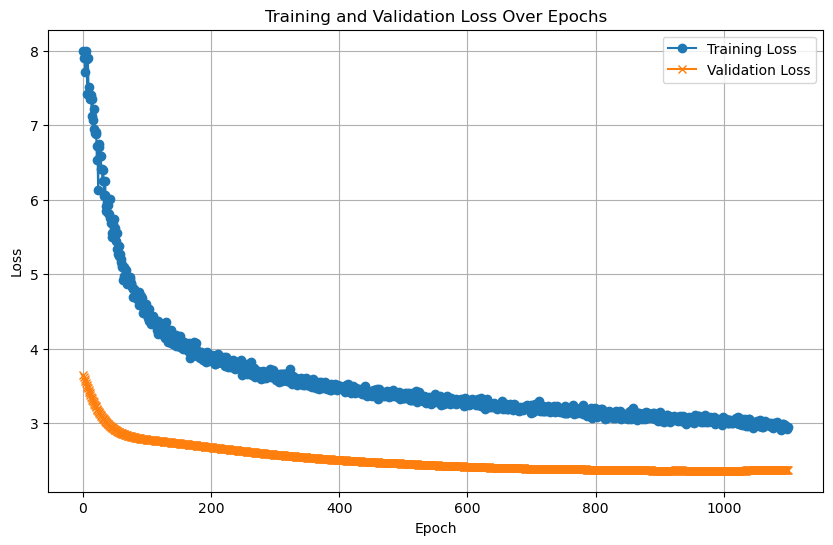

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 5.6725
Test Batch [20/167], Loss: 5.6839
Test Batch [30/167], Loss: 5.6699
Test Batch [40/167], Loss: 5.7038
Test Batch [50/167], Loss: 5.6267


Test Batch [60/167], Loss: 5.7290
Test Batch [70/167], Loss: 5.7275
Test Batch [80/167], Loss: 5.6217
Test Batch [90/167], Loss: 5.6744
Test Batch [100/167], Loss: 5.8172
Test Batch [110/167], Loss: 5.4352
Test Batch [120/167], Loss: 5.5366
Test Batch [130/167], Loss: 5.5049
Test Batch [140/167], Loss: 5.6496
Test Batch [150/167], Loss: 5.3817


Test Batch [160/167], Loss: 6.3285

Test Loss: 5.6335


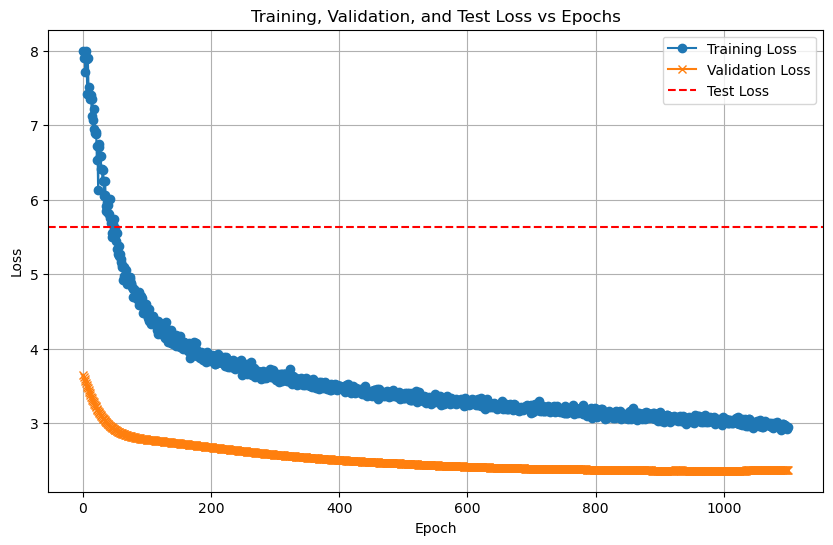

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.


  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.


  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.


  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 77.78%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.60      0.60      0.60         5
           2       0.80      0.80      0.80         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       0.60      0.60      0.60         5
           6       0.75      0.60      0.67         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00      1.00         5

    accuracy                           0.78        45
   macro avg       0.79      0.78      0.78        45
weighted avg       0.79      0.78      0.78        45


LOG: Evaluating on the test set...
Test Accuracy: 65.41%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4659  |  Val Loss: 2.4228
Validation loss improved from inf to 2.4228.
[Epoch 2/1000] Train Loss: 2.4304  |  Val Loss: 2.3944
Validation loss improved from 2.4228 to 2.3944.
[Epoch 3/1000] Train Loss: 2.3995  |  Val Loss: 2.3674
Validation loss improved from 2.3944 to 2.3674.
[Epoch 4/1000] Train Loss: 2.3683  |  Val Loss: 2.3426
Validation loss improved from 2.3674 to 2.3426.
[Epoch 5/1000] Train Loss: 2.3423  |  Val Loss: 2.3180
Validation loss improved from 2.3426 to 2.3180.
[Epoch 6/1000] Train Loss: 2.3141  |  Val Loss: 2.2943
Validation loss improved from 2.3180 to 2.2943.
[Epoch 7/1000] Train Loss: 2.2899  |  Val Loss: 2.2709
Validation loss improved from 2.2943 to 2.2709.
[Epoch 8/1000] Train Loss: 2.2617  |  Val Loss: 2.2479
Validation loss improved from 2.2709 to 2.2479.
[Epoch 9/1000] Train Loss: 2.2377  |  Val Loss: 2.2247
Validation loss improved from 2.2479 to 2.2247.


[Epoch 10/1000] Train Loss: 2.2154  |  Val Loss: 2.2014
Validation loss improved from 2.2247 to 2.2014.
[Epoch 11/1000] Train Loss: 2.1904  |  Val Loss: 2.1788
Validation loss improved from 2.2014 to 2.1788.
[Epoch 12/1000] Train Loss: 2.1658  |  Val Loss: 2.1566
Validation loss improved from 2.1788 to 2.1566.
[Epoch 13/1000] Train Loss: 2.1427  |  Val Loss: 2.1345
Validation loss improved from 2.1566 to 2.1345.
[Epoch 14/1000] Train Loss: 2.1221  |  Val Loss: 2.1127
Validation loss improved from 2.1345 to 2.1127.
[Epoch 15/1000] Train Loss: 2.0988  |  Val Loss: 2.0915
Validation loss improved from 2.1127 to 2.0915.
[Epoch 16/1000] Train Loss: 2.0769  |  Val Loss: 2.0707
Validation loss improved from 2.0915 to 2.0707.
[Epoch 17/1000] Train Loss: 2.0547  |  Val Loss: 2.0504
Validation loss improved from 2.0707 to 2.0504.
[Epoch 18/1000] Train Loss: 2.0328  |  Val Loss: 2.0302
Validation loss improved from 2.0504 to 2.0302.
[Epoch 19/1000] Train Loss: 2.0135  |  Val Loss: 2.0104
Validati

[Epoch 42/1000] Train Loss: 1.6881  |  Val Loss: 1.7207
Validation loss improved from 1.7308 to 1.7207.
[Epoch 43/1000] Train Loss: 1.6777  |  Val Loss: 1.7109
Validation loss improved from 1.7207 to 1.7109.
[Epoch 44/1000] Train Loss: 1.6672  |  Val Loss: 1.7011
Validation loss improved from 1.7109 to 1.7011.
[Epoch 45/1000] Train Loss: 1.6557  |  Val Loss: 1.6915
Validation loss improved from 1.7011 to 1.6915.
[Epoch 46/1000] Train Loss: 1.6464  |  Val Loss: 1.6818
Validation loss improved from 1.6915 to 1.6818.
[Epoch 47/1000] Train Loss: 1.6348  |  Val Loss: 1.6723
Validation loss improved from 1.6818 to 1.6723.
[Epoch 48/1000] Train Loss: 1.6246  |  Val Loss: 1.6627
Validation loss improved from 1.6723 to 1.6627.
[Epoch 49/1000] Train Loss: 1.6147  |  Val Loss: 1.6532
Validation loss improved from 1.6627 to 1.6532.
[Epoch 50/1000] Train Loss: 1.6040  |  Val Loss: 1.6437
Validation loss improved from 1.6532 to 1.6437.
[Epoch 51/1000] Train Loss: 1.5946  |  Val Loss: 1.6344
Validati

[Epoch 56/1000] Train Loss: 1.5455  |  Val Loss: 1.5901
Validation loss improved from 1.5985 to 1.5901.
[Epoch 57/1000] Train Loss: 1.5360  |  Val Loss: 1.5819
Validation loss improved from 1.5901 to 1.5819.
[Epoch 58/1000] Train Loss: 1.5272  |  Val Loss: 1.5739
Validation loss improved from 1.5819 to 1.5739.
[Epoch 59/1000] Train Loss: 1.5181  |  Val Loss: 1.5661
Validation loss improved from 1.5739 to 1.5661.
[Epoch 60/1000] Train Loss: 1.5096  |  Val Loss: 1.5585
Validation loss improved from 1.5661 to 1.5585.
[Epoch 61/1000] Train Loss: 1.5012  |  Val Loss: 1.5510
Validation loss improved from 1.5585 to 1.5510.
[Epoch 62/1000] Train Loss: 1.4930  |  Val Loss: 1.5437
Validation loss improved from 1.5510 to 1.5437.
[Epoch 63/1000] Train Loss: 1.4844  |  Val Loss: 1.5366
Validation loss improved from 1.5437 to 1.5366.
[Epoch 64/1000] Train Loss: 1.4765  |  Val Loss: 1.5296
Validation loss improved from 1.5366 to 1.5296.
[Epoch 65/1000] Train Loss: 1.4687  |  Val Loss: 1.5227
Validati

[Epoch 86/1000] Train Loss: 1.3174  |  Val Loss: 1.3918
Validation loss improved from 1.3975 to 1.3918.
[Epoch 87/1000] Train Loss: 1.3108  |  Val Loss: 1.3863
Validation loss improved from 1.3918 to 1.3863.
[Epoch 88/1000] Train Loss: 1.3042  |  Val Loss: 1.3810
Validation loss improved from 1.3863 to 1.3810.
[Epoch 89/1000] Train Loss: 1.2978  |  Val Loss: 1.3756
Validation loss improved from 1.3810 to 1.3756.
[Epoch 90/1000] Train Loss: 1.2914  |  Val Loss: 1.3703
Validation loss improved from 1.3756 to 1.3703.
[Epoch 91/1000] Train Loss: 1.2849  |  Val Loss: 1.3650
Validation loss improved from 1.3703 to 1.3650.
[Epoch 92/1000] Train Loss: 1.2786  |  Val Loss: 1.3596
Validation loss improved from 1.3650 to 1.3596.
[Epoch 93/1000] Train Loss: 1.2723  |  Val Loss: 1.3543
Validation loss improved from 1.3596 to 1.3543.
[Epoch 94/1000] Train Loss: 1.2658  |  Val Loss: 1.3490
Validation loss improved from 1.3543 to 1.3490.
[Epoch 95/1000] Train Loss: 1.2595  |  Val Loss: 1.3436
Validati

[Epoch 100/1000] Train Loss: 1.2285  |  Val Loss: 1.3167
Validation loss improved from 1.3221 to 1.3167.
[Epoch 101/1000] Train Loss: 1.2224  |  Val Loss: 1.3113
Validation loss improved from 1.3167 to 1.3113.
[Epoch 102/1000] Train Loss: 1.2162  |  Val Loss: 1.3058
Validation loss improved from 1.3113 to 1.3058.
[Epoch 103/1000] Train Loss: 1.2101  |  Val Loss: 1.3004
Validation loss improved from 1.3058 to 1.3004.
[Epoch 104/1000] Train Loss: 1.2039  |  Val Loss: 1.2948
Validation loss improved from 1.3004 to 1.2948.
[Epoch 105/1000] Train Loss: 1.1977  |  Val Loss: 1.2892
Validation loss improved from 1.2948 to 1.2892.
[Epoch 106/1000] Train Loss: 1.1915  |  Val Loss: 1.2836
Validation loss improved from 1.2892 to 1.2836.
[Epoch 107/1000] Train Loss: 1.1852  |  Val Loss: 1.2780
Validation loss improved from 1.2836 to 1.2780.
[Epoch 108/1000] Train Loss: 1.1790  |  Val Loss: 1.2724
Validation loss improved from 1.2780 to 1.2724.
[Epoch 109/1000] Train Loss: 1.1727  |  Val Loss: 1.266

[Epoch 138/1000] Train Loss: 0.9968  |  Val Loss: 1.1143
Validation loss improved from 1.1195 to 1.1143.
[Epoch 139/1000] Train Loss: 0.9908  |  Val Loss: 1.1091
Validation loss improved from 1.1143 to 1.1091.
[Epoch 140/1000] Train Loss: 0.9847  |  Val Loss: 1.1039
Validation loss improved from 1.1091 to 1.1039.
[Epoch 141/1000] Train Loss: 0.9788  |  Val Loss: 1.0986
Validation loss improved from 1.1039 to 1.0986.
[Epoch 142/1000] Train Loss: 0.9731  |  Val Loss: 1.0934
Validation loss improved from 1.0986 to 1.0934.
[Epoch 143/1000] Train Loss: 0.9669  |  Val Loss: 1.0882
Validation loss improved from 1.0934 to 1.0882.
[Epoch 144/1000] Train Loss: 0.9614  |  Val Loss: 1.0832
Validation loss improved from 1.0882 to 1.0832.


[Epoch 145/1000] Train Loss: 0.9553  |  Val Loss: 1.0782
Validation loss improved from 1.0832 to 1.0782.
[Epoch 146/1000] Train Loss: 0.9494  |  Val Loss: 1.0733
Validation loss improved from 1.0782 to 1.0733.
[Epoch 147/1000] Train Loss: 0.9436  |  Val Loss: 1.0684
Validation loss improved from 1.0733 to 1.0684.
[Epoch 148/1000] Train Loss: 0.9379  |  Val Loss: 1.0634
Validation loss improved from 1.0684 to 1.0634.
[Epoch 149/1000] Train Loss: 0.9323  |  Val Loss: 1.0584
Validation loss improved from 1.0634 to 1.0584.
[Epoch 150/1000] Train Loss: 0.9262  |  Val Loss: 1.0534
Validation loss improved from 1.0584 to 1.0534.
[Epoch 151/1000] Train Loss: 0.9208  |  Val Loss: 1.0484
Validation loss improved from 1.0534 to 1.0484.
[Epoch 152/1000] Train Loss: 0.9150  |  Val Loss: 1.0435
Validation loss improved from 1.0484 to 1.0435.
[Epoch 153/1000] Train Loss: 0.9093  |  Val Loss: 1.0386
Validation loss improved from 1.0435 to 1.0386.
[Epoch 154/1000] Train Loss: 0.9037  |  Val Loss: 1.033

[Epoch 186/1000] Train Loss: 0.7272  |  Val Loss: 0.8842
Validation loss improved from 0.8885 to 0.8842.
[Epoch 187/1000] Train Loss: 0.7221  |  Val Loss: 0.8799
Validation loss improved from 0.8842 to 0.8799.
[Epoch 188/1000] Train Loss: 0.7169  |  Val Loss: 0.8756
Validation loss improved from 0.8799 to 0.8756.
[Epoch 189/1000] Train Loss: 0.7116  |  Val Loss: 0.8714
Validation loss improved from 0.8756 to 0.8714.
[Epoch 190/1000] Train Loss: 0.7066  |  Val Loss: 0.8670
Validation loss improved from 0.8714 to 0.8670.
[Epoch 191/1000] Train Loss: 0.7014  |  Val Loss: 0.8626
Validation loss improved from 0.8670 to 0.8626.
[Epoch 192/1000] Train Loss: 0.6961  |  Val Loss: 0.8583
Validation loss improved from 0.8626 to 0.8583.
[Epoch 193/1000] Train Loss: 0.6911  |  Val Loss: 0.8541
Validation loss improved from 0.8583 to 0.8541.
[Epoch 194/1000] Train Loss: 0.6861  |  Val Loss: 0.8499
Validation loss improved from 0.8541 to 0.8499.


[Epoch 195/1000] Train Loss: 0.6811  |  Val Loss: 0.8459
Validation loss improved from 0.8499 to 0.8459.
[Epoch 196/1000] Train Loss: 0.6759  |  Val Loss: 0.8417
Validation loss improved from 0.8459 to 0.8417.
[Epoch 197/1000] Train Loss: 0.6712  |  Val Loss: 0.8376
Validation loss improved from 0.8417 to 0.8376.
[Epoch 198/1000] Train Loss: 0.6660  |  Val Loss: 0.8335
Validation loss improved from 0.8376 to 0.8335.
[Epoch 199/1000] Train Loss: 0.6613  |  Val Loss: 0.8295
Validation loss improved from 0.8335 to 0.8295.
[Epoch 200/1000] Train Loss: 0.6564  |  Val Loss: 0.8254
Validation loss improved from 0.8295 to 0.8254.
[Epoch 201/1000] Train Loss: 0.6516  |  Val Loss: 0.8215
Validation loss improved from 0.8254 to 0.8215.
[Epoch 202/1000] Train Loss: 0.6467  |  Val Loss: 0.8175
Validation loss improved from 0.8215 to 0.8175.
[Epoch 203/1000] Train Loss: 0.6422  |  Val Loss: 0.8136
Validation loss improved from 0.8175 to 0.8136.
[Epoch 204/1000] Train Loss: 0.6373  |  Val Loss: 0.809

[Epoch 229/1000] Train Loss: 0.5333  |  Val Loss: 0.7254
Validation loss improved from 0.7287 to 0.7254.
[Epoch 230/1000] Train Loss: 0.5297  |  Val Loss: 0.7222
Validation loss improved from 0.7254 to 0.7222.
[Epoch 231/1000] Train Loss: 0.5258  |  Val Loss: 0.7191
Validation loss improved from 0.7222 to 0.7191.
[Epoch 232/1000] Train Loss: 0.5221  |  Val Loss: 0.7161
Validation loss improved from 0.7191 to 0.7161.
[Epoch 233/1000] Train Loss: 0.5185  |  Val Loss: 0.7132
Validation loss improved from 0.7161 to 0.7132.
[Epoch 234/1000] Train Loss: 0.5147  |  Val Loss: 0.7104
Validation loss improved from 0.7132 to 0.7104.
[Epoch 235/1000] Train Loss: 0.5112  |  Val Loss: 0.7076
Validation loss improved from 0.7104 to 0.7076.
[Epoch 236/1000] Train Loss: 0.5076  |  Val Loss: 0.7048
Validation loss improved from 0.7076 to 0.7048.
[Epoch 237/1000] Train Loss: 0.5044  |  Val Loss: 0.7022
Validation loss improved from 0.7048 to 0.7022.
[Epoch 238/1000] Train Loss: 0.5008  |  Val Loss: 0.699

[Epoch 241/1000] Train Loss: 0.4904  |  Val Loss: 0.6917
Validation loss improved from 0.6942 to 0.6917.
[Epoch 242/1000] Train Loss: 0.4869  |  Val Loss: 0.6892
Validation loss improved from 0.6917 to 0.6892.
[Epoch 243/1000] Train Loss: 0.4836  |  Val Loss: 0.6868
Validation loss improved from 0.6892 to 0.6868.
[Epoch 244/1000] Train Loss: 0.4802  |  Val Loss: 0.6845
Validation loss improved from 0.6868 to 0.6845.
[Epoch 245/1000] Train Loss: 0.4769  |  Val Loss: 0.6822
Validation loss improved from 0.6845 to 0.6822.
[Epoch 246/1000] Train Loss: 0.4738  |  Val Loss: 0.6800
Validation loss improved from 0.6822 to 0.6800.
[Epoch 247/1000] Train Loss: 0.4708  |  Val Loss: 0.6779
Validation loss improved from 0.6800 to 0.6779.
[Epoch 248/1000] Train Loss: 0.4676  |  Val Loss: 0.6756
Validation loss improved from 0.6779 to 0.6756.
[Epoch 249/1000] Train Loss: 0.4643  |  Val Loss: 0.6733
Validation loss improved from 0.6756 to 0.6733.
[Epoch 250/1000] Train Loss: 0.4614  |  Val Loss: 0.670

[Epoch 275/1000] Train Loss: 0.3935  |  Val Loss: 0.6224
Validation loss improved from 0.6240 to 0.6224.
[Epoch 276/1000] Train Loss: 0.3912  |  Val Loss: 0.6209
Validation loss improved from 0.6224 to 0.6209.
[Epoch 277/1000] Train Loss: 0.3892  |  Val Loss: 0.6193
Validation loss improved from 0.6209 to 0.6193.
[Epoch 278/1000] Train Loss: 0.3867  |  Val Loss: 0.6176
Validation loss improved from 0.6193 to 0.6176.
[Epoch 279/1000] Train Loss: 0.3842  |  Val Loss: 0.6159
Validation loss improved from 0.6176 to 0.6159.
[Epoch 280/1000] Train Loss: 0.3818  |  Val Loss: 0.6144
Validation loss improved from 0.6159 to 0.6144.


[Epoch 281/1000] Train Loss: 0.3794  |  Val Loss: 0.6129
Validation loss improved from 0.6144 to 0.6129.
[Epoch 282/1000] Train Loss: 0.3771  |  Val Loss: 0.6115
Validation loss improved from 0.6129 to 0.6115.
[Epoch 283/1000] Train Loss: 0.3748  |  Val Loss: 0.6101
Validation loss improved from 0.6115 to 0.6101.
[Epoch 284/1000] Train Loss: 0.3725  |  Val Loss: 0.6087
Validation loss improved from 0.6101 to 0.6087.
[Epoch 285/1000] Train Loss: 0.3703  |  Val Loss: 0.6073
Validation loss improved from 0.6087 to 0.6073.
[Epoch 286/1000] Train Loss: 0.3680  |  Val Loss: 0.6059
Validation loss improved from 0.6073 to 0.6059.
[Epoch 287/1000] Train Loss: 0.3661  |  Val Loss: 0.6046
Validation loss improved from 0.6059 to 0.6046.
[Epoch 288/1000] Train Loss: 0.3641  |  Val Loss: 0.6032
Validation loss improved from 0.6046 to 0.6032.
[Epoch 289/1000] Train Loss: 0.3619  |  Val Loss: 0.6018
Validation loss improved from 0.6032 to 0.6018.
[Epoch 290/1000] Train Loss: 0.3597  |  Val Loss: 0.600

[Epoch 319/1000] Train Loss: 0.3072  |  Val Loss: 0.5706
Validation loss improved from 0.5713 to 0.5706.
[Epoch 320/1000] Train Loss: 0.3057  |  Val Loss: 0.5699
Validation loss improved from 0.5706 to 0.5699.
[Epoch 321/1000] Train Loss: 0.3042  |  Val Loss: 0.5692
Validation loss improved from 0.5699 to 0.5692.
[Epoch 322/1000] Train Loss: 0.3025  |  Val Loss: 0.5683
Validation loss improved from 0.5692 to 0.5683.
[Epoch 323/1000] Train Loss: 0.3009  |  Val Loss: 0.5676
Validation loss improved from 0.5683 to 0.5676.
[Epoch 324/1000] Train Loss: 0.2997  |  Val Loss: 0.5670
Validation loss improved from 0.5676 to 0.5670.
[Epoch 325/1000] Train Loss: 0.2982  |  Val Loss: 0.5664
Validation loss improved from 0.5670 to 0.5664.
[Epoch 326/1000] Train Loss: 0.2969  |  Val Loss: 0.5658
Validation loss improved from 0.5664 to 0.5658.
[Epoch 327/1000] Train Loss: 0.2953  |  Val Loss: 0.5652
Validation loss improved from 0.5658 to 0.5652.
[Epoch 328/1000] Train Loss: 0.2942  |  Val Loss: 0.564

[Epoch 366/1000] Train Loss: 0.2485  |  Val Loss: 0.5482
Validation loss improved from 0.5485 to 0.5482.
[Epoch 367/1000] Train Loss: 0.2479  |  Val Loss: 0.5478
Validation loss improved from 0.5482 to 0.5478.
[Epoch 368/1000] Train Loss: 0.2465  |  Val Loss: 0.5473
Validation loss improved from 0.5478 to 0.5473.
[Epoch 369/1000] Train Loss: 0.2459  |  Val Loss: 0.5468
Validation loss improved from 0.5473 to 0.5468.
[Epoch 370/1000] Train Loss: 0.2443  |  Val Loss: 0.5463
Validation loss improved from 0.5468 to 0.5463.
[Epoch 371/1000] Train Loss: 0.2435  |  Val Loss: 0.5460
Validation loss improved from 0.5463 to 0.5460.
[Epoch 372/1000] Train Loss: 0.2422  |  Val Loss: 0.5458
Validation loss improved from 0.5460 to 0.5458.
[Epoch 373/1000] Train Loss: 0.2415  |  Val Loss: 0.5457
Validation loss improved from 0.5458 to 0.5457.
[Epoch 374/1000] Train Loss: 0.2410  |  Val Loss: 0.5456
Validation loss improved from 0.5457 to 0.5456.
[Epoch 375/1000] Train Loss: 0.2401  |  Val Loss: 0.545

[Epoch 414/1000] Train Loss: 0.2104  |  Val Loss: 0.5426
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 415/1000] Train Loss: 0.2098  |  Val Loss: 0.5428
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 416/1000] Train Loss: 0.2092  |  Val Loss: 0.5429
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 417/1000] Train Loss: 0.2085  |  Val Loss: 0.5429
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 418/1000] Train Loss: 0.2078  |  Val Loss: 0.5429
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 419/1000] Train Loss: 0.2073  |  Val Loss: 0.5430
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 420/1000] Train Loss: 0.2067  |  Val Loss: 0.5431
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 421/1000] Train Loss: 0.2060  |  Val Loss: 0.5433
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 422/1000] Train Loss: 0.2055  |  Val Loss: 0.5434
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 463/1000] Train Loss: 0.1851  |  Val Loss: 0.5474
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 464/1000] Train Loss: 0.1846  |  Val Loss: 0.5475
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 465/1000] Train Loss: 0.1841  |  Val Loss: 0.5475
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 466/1000] Train Loss: 0.1836  |  Val Loss: 0.5477
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 467/1000] Train Loss: 0.1831  |  Val Loss: 0.5480
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 468/1000] Train Loss: 0.1825  |  Val Loss: 0.5484
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 469/1000] Train Loss: 0.1824  |  Val Loss: 0.5488
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 470/1000] Train Loss: 0.1820  |  Val Loss: 0.5491
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 471/1000] Train Loss: 0.1814  |  Val Loss: 0.5496
!! Validation loss did NOT improve !! Patience:

[Epoch 505/1000] Train Loss: 0.1687  |  Val Loss: 0.5546
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 506/1000] Train Loss: 0.1687  |  Val Loss: 0.5548
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 507/1000] Train Loss: 0.1680  |  Val Loss: 0.5552
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 508/1000] Train Loss: 0.1678  |  Val Loss: 0.5556
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 509/1000] Train Loss: 0.1674  |  Val Loss: 0.5560
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 510/1000] Train Loss: 0.1671  |  Val Loss: 0.5563
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 511/1000] Train Loss: 0.1669  |  Val Loss: 0.5565
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 511 !!
No improvement for 100 epochs.


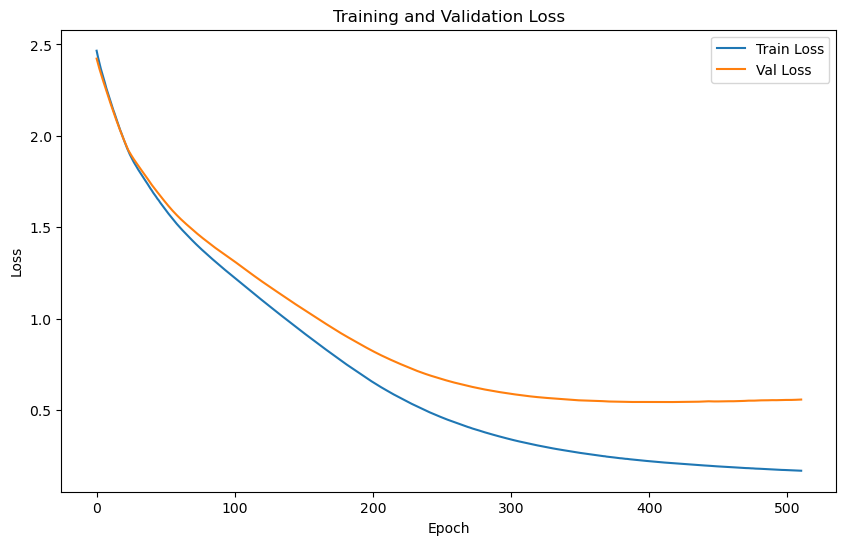

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.8867 | Test Accuracy: 67.54%


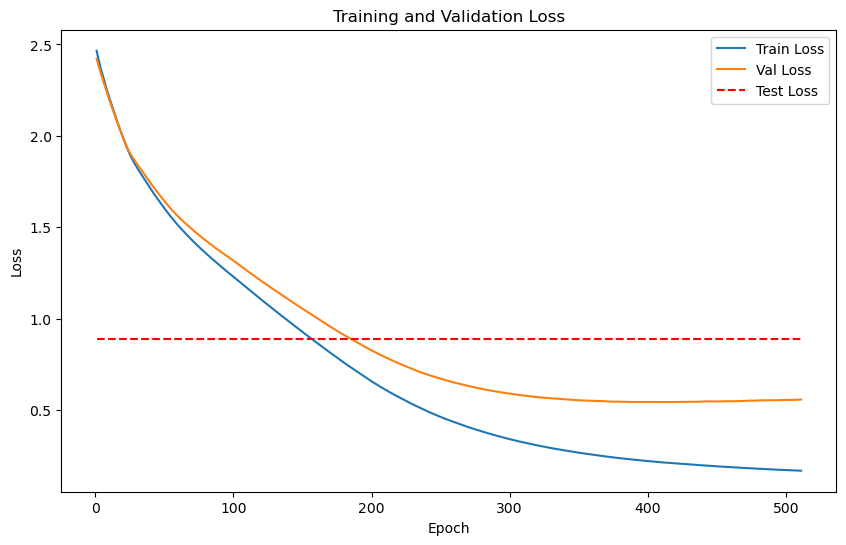

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42641, 64), 
Test labels shape: (42641,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4448
Epoch [1/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4448

Validation loss improved from inf to 0.4448. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4419
Epoch [2/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4419

Validation loss improved from 0.4448 to 0.4419. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4383
Epoch [3/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.4383

Validation loss improved from 0.4419 to 0.4383. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4345
Epoch [4/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4345

Validation loss improved from 0.4383 to 0.4345. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [5/2000] - Validation


    Batch [1/1], Val Loss: 0.4313
Epoch [5/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.4313

Validation loss improved from 0.4345 to 0.4313. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [6/2000] - Validation


    Batch [1/1], Val Loss: 0.4282
Epoch [6/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4282

Validation loss improved from 0.4313 to 0.4282. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.4251
Epoch [7/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.4251

Validation loss improved from 0.4282 to 0.4251. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4231
Epoch [8/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4231

Validation loss improved from 0.4251 to 0.4231. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.4215
Epoch [9/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.4215

Validation loss improved from 0.4231 to 0.4215. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4206
Epoch [10/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4206

Validation loss improved from 0.4215 to 0.4206. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [11/2000] - Validation


    Batch [1/1], Val Loss: 0.4195
Epoch [11/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4195

Validation loss improved from 0.4206 to 0.4195. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4184
Epoch [12/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4184

Validation loss improved from 0.4195 to 0.4184. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4173
Epoch [13/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4173

Validation loss improved from 0.4184 to 0.4173. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4163
Epoch [14/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4163

Validation loss improved from 0.4173 to 0.4163. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4154
Epoch [15/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4154

Validation loss improved from 0.4163 to 0.4154. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4144
Epoch [16/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4144

Validation loss improved from 0.4154 to 0.4144. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4133
Epoch [17/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.4133

Validation loss improved from 0.4144 to 0.4133. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4123
Epoch [18/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4123

Validation loss improved from 0.4133 to 0.4123. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4114
Epoch [19/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4114

Validation loss improved from 0.4123 to 0.4114. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4105
Epoch [20/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.4105

Validation loss improved from 0.4114 to 0.4105. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4098
Epoch [21/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4098

Validation loss improved from 0.4105 to 0.4098. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [22/2000] - Validation


    Batch [1/1], Val Loss: 0.4090
Epoch [22/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.4090

Validation loss improved from 0.4098 to 0.4090. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4083
Epoch [23/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.4083

Validation loss improved from 0.4090 to 0.4083. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4077
Epoch [24/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4077

Validation loss improved from 0.4083 to 0.4077. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4071
Epoch [25/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.4071

Validation loss improved from 0.4077 to 0.4071. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [26/2000] - Validation


    Batch [1/1], Val Loss: 0.4064
Epoch [26/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.4064

Validation loss improved from 0.4071 to 0.4064. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.4057
Epoch [27/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.4057

Validation loss improved from 0.4064 to 0.4057. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4050
Epoch [28/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.4050

Validation loss improved from 0.4057 to 0.4050. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4044
Epoch [29/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.4044

Validation loss improved from 0.4050 to 0.4044. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.4037
Epoch [30/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.4037

Validation loss improved from 0.4044 to 0.4037. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [31/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.4031

Validation loss improved from 0.4037 to 0.4031. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.4024
Epoch [32/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4024

Validation loss improved from 0.4031 to 0.4024. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [33/2000] - Validation


    Batch [1/1], Val Loss: 0.4018
Epoch [33/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.4018

Validation loss improved from 0.4024 to 0.4018. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4011
Epoch [34/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.4011

Validation loss improved from 0.4018 to 0.4011. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.4005
Epoch [35/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.4005

Validation loss improved from 0.4011 to 0.4005. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3998
Epoch [36/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.3998

Validation loss improved from 0.4005 to 0.3998. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3992
Epoch [37/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.3992

Validation loss improved from 0.3998 to 0.3992. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [38/2000] - Validation


    Batch [1/1], Val Loss: 0.3985
Epoch [38/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.3985

Validation loss improved from 0.3992 to 0.3985. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3979
Epoch [39/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.3979

Validation loss improved from 0.3985 to 0.3979. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3973
Epoch [40/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.3973

Validation loss improved from 0.3979 to 0.3973. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3967
Epoch [41/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.3967

Validation loss improved from 0.3973 to 0.3967. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3961
Epoch [42/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.3961

Validation loss improved from 0.3967 to 0.3961. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3956
Epoch [43/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.3956

Validation loss improved from 0.3961 to 0.3956. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [44/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.3949

Validation loss improved from 0.3956 to 0.3949. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3944
Epoch [45/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.3944

Validation loss improved from 0.3949 to 0.3944. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [46/2000] - Validation


    Batch [1/1], Val Loss: 0.3938
Epoch [46/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.3938

Validation loss improved from 0.3944 to 0.3938. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3932
Epoch [47/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.3932

Validation loss improved from 0.3938 to 0.3932. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3927
Epoch [48/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3927

Validation loss improved from 0.3932 to 0.3927. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3921
Epoch [49/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.3921

Validation loss improved from 0.3927 to 0.3921. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3916
Epoch [50/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.3916

Validation loss improved from 0.3921 to 0.3916. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3910
Epoch [51/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.3910

Validation loss improved from 0.3916 to 0.3910. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [52/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.3905

Validation loss improved from 0.3910 to 0.3905. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [53/2000] - Validation


    Batch [1/1], Val Loss: 0.3899
Epoch [53/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.3899

Validation loss improved from 0.3905 to 0.3899. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3894
Epoch [54/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.3894

Validation loss improved from 0.3899 to 0.3894. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3889
Epoch [55/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.3889

Validation loss improved from 0.3894 to 0.3889. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [56/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.3883

Validation loss improved from 0.3889 to 0.3883. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3878
Epoch [57/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.3878

Validation loss improved from 0.3883 to 0.3878. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3873
Epoch [58/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.3873

Validation loss improved from 0.3878 to 0.3873. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3868
Epoch [59/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.3868

Validation loss improved from 0.3873 to 0.3868. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3862
Epoch [60/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.3862

Validation loss improved from 0.3868 to 0.3862. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [61/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.3857

Validation loss improved from 0.3862 to 0.3857. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3852
Epoch [62/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.3852

Validation loss improved from 0.3857 to 0.3852. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [63/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.3847

Validation loss improved from 0.3852 to 0.3847. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3843
Epoch [64/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3843

Validation loss improved from 0.3847 to 0.3843. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3838
Epoch [65/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.3838

Validation loss improved from 0.3843 to 0.3838. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3833
Epoch [66/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.3833

Validation loss improved from 0.3838 to 0.3833. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3828
Epoch [67/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.3828

Validation loss improved from 0.3833 to 0.3828. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [68/2000] - Validation


    Batch [1/1], Val Loss: 0.3824
Epoch [68/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.3824

Validation loss improved from 0.3828 to 0.3824. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3819
Epoch [69/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3819

Validation loss improved from 0.3824 to 0.3819. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.3814
Epoch [70/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.3814

Validation loss improved from 0.3819 to 0.3814. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3809
Epoch [71/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.3809

Validation loss improved from 0.3814 to 0.3809. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3805
Epoch [72/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3805

Validation loss improved from 0.3809 to 0.3805. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3800
Epoch [73/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.3800

Validation loss improved from 0.3805 to 0.3800. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3796
Epoch [74/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.3796

Validation loss improved from 0.3800 to 0.3796. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3792
Epoch [75/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.3792

Validation loss improved from 0.3796 to 0.3792. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3788
Epoch [76/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3788

Validation loss improved from 0.3792 to 0.3788. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [77/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3785

Validation loss improved from 0.3788 to 0.3785. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [78/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.3781

Validation loss improved from 0.3785 to 0.3781. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3778
Epoch [79/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3778

Validation loss improved from 0.3781 to 0.3778. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [80/2000] - Validation


    Batch [1/1], Val Loss: 0.3774
Epoch [80/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3774

Validation loss improved from 0.3778 to 0.3774. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3771
Epoch [81/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3771

Validation loss improved from 0.3774 to 0.3771. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [82/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.3768

Validation loss improved from 0.3771 to 0.3768. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3766
Epoch [83/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3766

Validation loss improved from 0.3768 to 0.3766. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3763
Epoch [84/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3763

Validation loss improved from 0.3766 to 0.3763. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3761
Epoch [85/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3761

Validation loss improved from 0.3763 to 0.3761. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3758
Epoch [86/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3758

Validation loss improved from 0.3761 to 0.3758. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [87/2000] - Validation


    Batch [1/1], Val Loss: 0.3756
Epoch [87/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3756

Validation loss improved from 0.3758 to 0.3756. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3753
Epoch [88/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3753

Validation loss improved from 0.3756 to 0.3753. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [89/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3750

Validation loss improved from 0.3753 to 0.3750. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [90/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3747

Validation loss improved from 0.3750 to 0.3747. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3744
Epoch [91/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3744

Validation loss improved from 0.3747 to 0.3744. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3742
Epoch [92/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3742

Validation loss improved from 0.3744 to 0.3742. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3738
Epoch [93/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.3738

Validation loss improved from 0.3742 to 0.3738. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [94/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.3736

Validation loss improved from 0.3738 to 0.3736. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [95/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3733

Validation loss improved from 0.3736 to 0.3733. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3730
Epoch [96/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3730

Validation loss improved from 0.3733 to 0.3730. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [97/2000] - Validation


    Batch [1/1], Val Loss: 0.3727
Epoch [97/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.3727

Validation loss improved from 0.3730 to 0.3727. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3724
Epoch [98/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.3724

Validation loss improved from 0.3727 to 0.3724. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3722
Epoch [99/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3722

Validation loss improved from 0.3724 to 0.3722. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3719
Epoch [100/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3719

Validation loss improved from 0.3722 to 0.3719. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3716
Epoch [101/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3716

Validation loss improved from 0.3719 to 0.3716. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3713
Epoch [102/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.3713

Validation loss improved from 0.3716 to 0.3713. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3711
Epoch [103/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3711

Validation loss improved from 0.3713 to 0.3711. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3708
Epoch [104/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3708

Validation loss improved from 0.3711 to 0.3708. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3705
Epoch [105/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3705

Validation loss improved from 0.3708 to 0.3705. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3702
Epoch [106/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.3702

Validation loss improved from 0.3705 to 0.3702. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [107/2000] - Validation


    Batch [1/1], Val Loss: 0.3700
Epoch [107/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.3700

Validation loss improved from 0.3702 to 0.3700. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3697
Epoch [108/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.3697

Validation loss improved from 0.3700 to 0.3697. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3695
Epoch [109/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.3695

Validation loss improved from 0.3697 to 0.3695. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3692
Epoch [110/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.3692

Validation loss improved from 0.3695 to 0.3692. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3690
Epoch [111/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3690

Validation loss improved from 0.3692 to 0.3690. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [112/2000] - Validation


    Batch [1/1], Val Loss: 0.3688
Epoch [112/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.3688

Validation loss improved from 0.3690 to 0.3688. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3686
Epoch [113/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.3686

Validation loss improved from 0.3688 to 0.3686. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3683
Epoch [114/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.3683

Validation loss improved from 0.3686 to 0.3683. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [115/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.3681

Validation loss improved from 0.3683 to 0.3681. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3679
Epoch [116/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.3679

Validation loss improved from 0.3681 to 0.3679. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [117/2000] - Validation


    Batch [1/1], Val Loss: 0.3676
Epoch [117/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.3676

Validation loss improved from 0.3679 to 0.3676. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3674
Epoch [118/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.3674

Validation loss improved from 0.3676 to 0.3674. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3671
Epoch [119/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3671

Validation loss improved from 0.3674 to 0.3671. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3669
Epoch [120/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.3669

Validation loss improved from 0.3671 to 0.3669. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3666
Epoch [121/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.3666

Validation loss improved from 0.3669 to 0.3666. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [122/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.3663

Validation loss improved from 0.3666 to 0.3663. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3661
Epoch [123/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3661

Validation loss improved from 0.3663 to 0.3661. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [124/2000] - Validation


    Batch [1/1], Val Loss: 0.3658
Epoch [124/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.3658

Validation loss improved from 0.3661 to 0.3658. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3656
Epoch [125/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3656

Validation loss improved from 0.3658 to 0.3656. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [126/2000] - Validation


    Batch [1/1], Val Loss: 0.3654
Epoch [126/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.3654

Validation loss improved from 0.3656 to 0.3654. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [127/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3651

Validation loss improved from 0.3654 to 0.3651. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3649
Epoch [128/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.3649

Validation loss improved from 0.3651 to 0.3649. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [129/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.3647

Validation loss improved from 0.3649 to 0.3647. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [130/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.3645

Validation loss improved from 0.3647 to 0.3645. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [131/2000] - Validation


    Batch [1/1], Val Loss: 0.3643
Epoch [131/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3643

Validation loss improved from 0.3645 to 0.3643. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [132/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.3641

Validation loss improved from 0.3643 to 0.3641. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3639
Epoch [133/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.3639

Validation loss improved from 0.3641 to 0.3639. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3637
Epoch [134/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.3637

Validation loss improved from 0.3639 to 0.3637. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [135/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.3635

Validation loss improved from 0.3637 to 0.3635. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3633
Epoch [136/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3633

Validation loss improved from 0.3635 to 0.3633. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [137/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.3631

Validation loss improved from 0.3633 to 0.3631. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [138/2000] - Validation


    Batch [1/1], Val Loss: 0.3629
Epoch [138/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.3629

Validation loss improved from 0.3631 to 0.3629. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3627
Epoch [139/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.3627

Validation loss improved from 0.3629 to 0.3627. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3625
Epoch [140/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.3625

Validation loss improved from 0.3627 to 0.3625. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3622
Epoch [141/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3622

Validation loss improved from 0.3625 to 0.3622. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3620
Epoch [142/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.3620

Validation loss improved from 0.3622 to 0.3620. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3618
Epoch [143/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.3618

Validation loss improved from 0.3620 to 0.3618. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [144/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.3615

Validation loss improved from 0.3618 to 0.3615. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3612
Epoch [145/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.3612

Validation loss improved from 0.3615 to 0.3612. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [146/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3610

Validation loss improved from 0.3612 to 0.3610. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3607
Epoch [147/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.3607

Validation loss improved from 0.3610 to 0.3607. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [148/2000] - Validation


    Batch [1/1], Val Loss: 0.3604
Epoch [148/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.3604

Validation loss improved from 0.3607 to 0.3604. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [149/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3602

Validation loss improved from 0.3604 to 0.3602. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [150/2000] - Validation


    Batch [1/1], Val Loss: 0.3599
Epoch [150/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3599

Validation loss improved from 0.3602 to 0.3599. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3597
Epoch [151/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3597

Validation loss improved from 0.3599 to 0.3597. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3594
Epoch [152/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.3594

Validation loss improved from 0.3597 to 0.3594. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3592
Epoch [153/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.3592

Validation loss improved from 0.3594 to 0.3592. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3590
Epoch [154/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3590

Validation loss improved from 0.3592 to 0.3590. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3587
Epoch [155/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.3587

Validation loss improved from 0.3590 to 0.3587. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3585
Epoch [156/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3585

Validation loss improved from 0.3587 to 0.3585. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [157/2000] - Validation


    Batch [1/1], Val Loss: 0.3583
Epoch [157/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.3583

Validation loss improved from 0.3585 to 0.3583. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3581
Epoch [158/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.3581

Validation loss improved from 0.3583 to 0.3581. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [159/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.3579

Validation loss improved from 0.3581 to 0.3579. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3577
Epoch [160/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.3577

Validation loss improved from 0.3579 to 0.3577. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3575
Epoch [161/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.3575

Validation loss improved from 0.3577 to 0.3575. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [162/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.3573

Validation loss improved from 0.3575 to 0.3573. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3571
Epoch [163/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.3571

Validation loss improved from 0.3573 to 0.3571. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [164/2000] - Validation


    Batch [1/1], Val Loss: 0.3569
Epoch [164/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.3569

Validation loss improved from 0.3571 to 0.3569. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [165/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.3568

Validation loss improved from 0.3569 to 0.3568. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [166/2000] - Validation


    Batch [1/1], Val Loss: 0.3566
Epoch [166/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.3566

Validation loss improved from 0.3568 to 0.3566. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3564
Epoch [167/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.3564

Validation loss improved from 0.3566 to 0.3564. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3562
Epoch [168/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.3562

Validation loss improved from 0.3564 to 0.3562. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [169/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.3560

Validation loss improved from 0.3562 to 0.3560. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [170/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.3558

Validation loss improved from 0.3560 to 0.3558. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [171/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [171/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.3557

Validation loss improved from 0.3558 to 0.3557. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [172/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.3555

Validation loss improved from 0.3557 to 0.3555. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [173/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.3554

Validation loss improved from 0.3555 to 0.3554. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3552
Epoch [174/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.3552

Validation loss improved from 0.3554 to 0.3552. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3381
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [175/2000], Avg Train Loss: 0.3381, Avg Val Loss: 0.3550

Validation loss improved from 0.3552 to 0.3550. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [176/2000] - Validation


    Batch [1/1], Val Loss: 0.3548
Epoch [176/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.3548

Validation loss improved from 0.3550 to 0.3548. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [177/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.3547

Validation loss improved from 0.3548 to 0.3547. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [178/2000] - Validation


    Batch [1/1], Val Loss: 0.3545
Epoch [178/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.3545

Validation loss improved from 0.3547 to 0.3545. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [179/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.3543

Validation loss improved from 0.3545 to 0.3543. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [180/2000] - Validation


    Batch [1/1], Val Loss: 0.3541
Epoch [180/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3541

Validation loss improved from 0.3543 to 0.3541. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3393
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3539
Epoch [181/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.3539

Validation loss improved from 0.3541 to 0.3539. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3537
Epoch [182/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.3537

Validation loss improved from 0.3539 to 0.3537. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3536
Epoch [183/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.3536

Validation loss improved from 0.3537 to 0.3536. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3534
Epoch [184/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.3534

Validation loss improved from 0.3536 to 0.3534. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3533
Epoch [185/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.3533

Validation loss improved from 0.3534 to 0.3533. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3531
Epoch [186/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.3531

Validation loss improved from 0.3533 to 0.3531. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [187/2000] - Validation


    Batch [1/1], Val Loss: 0.3530
Epoch [187/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.3530

Validation loss improved from 0.3531 to 0.3530. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3528
Epoch [188/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.3528

Validation loss improved from 0.3530 to 0.3528. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [189/2000] - Validation


    Batch [1/1], Val Loss: 0.3527
Epoch [189/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.3527

Validation loss improved from 0.3528 to 0.3527. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3525
Epoch [190/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.3525

Validation loss improved from 0.3527 to 0.3525. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.3276
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3523
Epoch [191/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.3523

Validation loss improved from 0.3525 to 0.3523. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [192/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3522

Validation loss improved from 0.3523 to 0.3522. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.3367
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3520
Epoch [193/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.3520

Validation loss improved from 0.3522 to 0.3520. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3519
Epoch [194/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.3519

Validation loss improved from 0.3520 to 0.3519. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.3351
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3517
Epoch [195/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.3517

Validation loss improved from 0.3519 to 0.3517. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [196/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.3515

Validation loss improved from 0.3517 to 0.3515. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3371
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [197/2000], Avg Train Loss: 0.3371, Avg Val Loss: 0.3513

Validation loss improved from 0.3515 to 0.3513. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [198/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.3511

Validation loss improved from 0.3513 to 0.3511. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3509
Epoch [199/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.3509

Validation loss improved from 0.3511 to 0.3509. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3507
Epoch [200/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.3507

Validation loss improved from 0.3509 to 0.3507. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3506
Epoch [201/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.3506

Validation loss improved from 0.3507 to 0.3506. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3504
Epoch [202/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.3504

Validation loss improved from 0.3506 to 0.3504. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3501
Epoch [203/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.3501

Validation loss improved from 0.3504 to 0.3501. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3366
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3500
Epoch [204/2000], Avg Train Loss: 0.3366, Avg Val Loss: 0.3500

Validation loss improved from 0.3501 to 0.3500. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3498
Epoch [205/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.3498

Validation loss improved from 0.3500 to 0.3498. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.3337
LOG: Epoch [206/2000] - Validation


    Batch [1/1], Val Loss: 0.3496
Epoch [206/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.3496

Validation loss improved from 0.3498 to 0.3496. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3494
Epoch [207/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.3494

Validation loss improved from 0.3496 to 0.3494. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [208/2000] - Validation


    Batch [1/1], Val Loss: 0.3492
Epoch [208/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.3492

Validation loss improved from 0.3494 to 0.3492. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3490
Epoch [209/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.3490

Validation loss improved from 0.3492 to 0.3490. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3488
Epoch [210/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.3488

Validation loss improved from 0.3490 to 0.3488. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3289
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3487
Epoch [211/2000], Avg Train Loss: 0.3289, Avg Val Loss: 0.3487

Validation loss improved from 0.3488 to 0.3487. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [212/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.3485

Validation loss improved from 0.3487 to 0.3485. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.3297
LOG: Epoch [213/2000] - Validation


    Batch [1/1], Val Loss: 0.3484
Epoch [213/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.3484

Validation loss improved from 0.3485 to 0.3484. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3483
Epoch [214/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.3483

Validation loss improved from 0.3484 to 0.3483. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3482
Epoch [215/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.3482

Validation loss improved from 0.3483 to 0.3482. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3480
Epoch [216/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.3480

Validation loss improved from 0.3482 to 0.3480. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3479
Epoch [217/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.3479

Validation loss improved from 0.3480 to 0.3479. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [218/2000] - Validation


    Batch [1/1], Val Loss: 0.3478
Epoch [218/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.3478

Validation loss improved from 0.3479 to 0.3478. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.3296
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3477
Epoch [219/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.3477

Validation loss improved from 0.3478 to 0.3477. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.3210
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3476
Epoch [220/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.3476

Validation loss improved from 0.3477 to 0.3476. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3475
Epoch [221/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.3475

Validation loss improved from 0.3476 to 0.3475. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [222/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.3473

Validation loss improved from 0.3475 to 0.3473. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3472
Epoch [223/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.3472

Validation loss improved from 0.3473 to 0.3472. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3470
Epoch [224/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.3470

Validation loss improved from 0.3472 to 0.3470. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3468
Epoch [225/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.3468

Validation loss improved from 0.3470 to 0.3468. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3188
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3466
Epoch [226/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.3466

Validation loss improved from 0.3468 to 0.3466. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.3174
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3465
Epoch [227/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.3465

Validation loss improved from 0.3466 to 0.3465. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3159
LOG: Epoch [228/2000] - Validation


    Batch [1/1], Val Loss: 0.3462
Epoch [228/2000], Avg Train Loss: 0.3159, Avg Val Loss: 0.3462

Validation loss improved from 0.3465 to 0.3462. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.3297
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [229/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.3461

Validation loss improved from 0.3462 to 0.3461. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3177
LOG: Epoch [230/2000] - Validation


    Batch [1/1], Val Loss: 0.3459
Epoch [230/2000], Avg Train Loss: 0.3177, Avg Val Loss: 0.3459

Validation loss improved from 0.3461 to 0.3459. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3458
Epoch [231/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.3458

Validation loss improved from 0.3459 to 0.3458. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [232/2000] - Validation


    Batch [1/1], Val Loss: 0.3457
Epoch [232/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.3457

Validation loss improved from 0.3458 to 0.3457. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.3122
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [233/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.3455

Validation loss improved from 0.3457 to 0.3455. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.3159
LOG: Epoch [234/2000] - Validation


    Batch [1/1], Val Loss: 0.3454
Epoch [234/2000], Avg Train Loss: 0.3159, Avg Val Loss: 0.3454

Validation loss improved from 0.3455 to 0.3454. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.3167
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3453
Epoch [235/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.3453

Validation loss improved from 0.3454 to 0.3453. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [236/2000] - Validation


    Batch [1/1], Val Loss: 0.3452
Epoch [236/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.3452

Validation loss improved from 0.3453 to 0.3452. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.3124
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3451
Epoch [237/2000], Avg Train Loss: 0.3124, Avg Val Loss: 0.3451

Validation loss improved from 0.3452 to 0.3451. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3450
Epoch [238/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.3450

Validation loss improved from 0.3451 to 0.3450. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3133
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3449
Epoch [239/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.3449

Validation loss improved from 0.3450 to 0.3449. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.3143
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3448
Epoch [240/2000], Avg Train Loss: 0.3143, Avg Val Loss: 0.3448

Validation loss improved from 0.3449 to 0.3448. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3144
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3447
Epoch [241/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.3447

Validation loss improved from 0.3448 to 0.3447. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.3218
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3447
Epoch [242/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.3447

Validation loss improved from 0.3447 to 0.3447. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.3132
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3447
Epoch [243/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.3447

Validation loss improved from 0.3447 to 0.3447. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3090
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3446
Epoch [244/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.3446

Validation loss improved from 0.3447 to 0.3446. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.3122
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3445
Epoch [245/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.3445

Validation loss improved from 0.3446 to 0.3445. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.3091
LOG: Epoch [246/2000] - Validation


    Batch [1/1], Val Loss: 0.3444
Epoch [246/2000], Avg Train Loss: 0.3091, Avg Val Loss: 0.3444

Validation loss improved from 0.3445 to 0.3444. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.3079
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3443
Epoch [247/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.3443

Validation loss improved from 0.3444 to 0.3443. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3442
Epoch [248/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.3442

Validation loss improved from 0.3443 to 0.3442. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3169
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [249/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.3441

Validation loss improved from 0.3442 to 0.3441. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.3074
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [250/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.3440

Validation loss improved from 0.3441 to 0.3440. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.3073
LOG: Epoch [251/2000] - Validation


    Batch [1/1], Val Loss: 0.3438
Epoch [251/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.3438

Validation loss improved from 0.3440 to 0.3438. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [252/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.3437

Validation loss improved from 0.3438 to 0.3437. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3436
Epoch [253/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3436

Validation loss improved from 0.3437 to 0.3436. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [254/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.3434

Validation loss improved from 0.3436 to 0.3434. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3433
Epoch [255/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.3433

Validation loss improved from 0.3434 to 0.3433. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.3129
LOG: Epoch [256/2000] - Validation


    Batch [1/1], Val Loss: 0.3432
Epoch [256/2000], Avg Train Loss: 0.3129, Avg Val Loss: 0.3432

Validation loss improved from 0.3433 to 0.3432. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.3088
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3431
Epoch [257/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.3431

Validation loss improved from 0.3432 to 0.3431. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [258/2000] - Validation


    Batch [1/1], Val Loss: 0.3430
Epoch [258/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.3430

Validation loss improved from 0.3431 to 0.3430. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3429
Epoch [259/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.3429

Validation loss improved from 0.3430 to 0.3429. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.3109
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3428
Epoch [260/2000], Avg Train Loss: 0.3109, Avg Val Loss: 0.3428

Validation loss improved from 0.3429 to 0.3428. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3427
Epoch [261/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3427

Validation loss improved from 0.3428 to 0.3427. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.3129
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3426
Epoch [262/2000], Avg Train Loss: 0.3129, Avg Val Loss: 0.3426

Validation loss improved from 0.3427 to 0.3426. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2950
LOG: Epoch [263/2000] - Validation


    Batch [1/1], Val Loss: 0.3425
Epoch [263/2000], Avg Train Loss: 0.2950, Avg Val Loss: 0.3425

Validation loss improved from 0.3426 to 0.3425. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3425
Epoch [264/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.3425

Validation loss improved from 0.3425 to 0.3425. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.3054
LOG: Epoch [265/2000] - Validation


    Batch [1/1], Val Loss: 0.3424
Epoch [265/2000], Avg Train Loss: 0.3054, Avg Val Loss: 0.3424

Validation loss improved from 0.3425 to 0.3424. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3424
Epoch [266/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.3424

Validation loss improved from 0.3424 to 0.3424. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2977
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3424
Epoch [267/2000], Avg Train Loss: 0.2977, Avg Val Loss: 0.3424

Validation loss improved from 0.3424 to 0.3424. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3424
Epoch [268/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.3424

Validation loss improved from 0.3424 to 0.3424. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2903
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3424
Epoch [269/2000], Avg Train Loss: 0.2903, Avg Val Loss: 0.3424

Validation loss improved from 0.3424 to 0.3424. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [270/2000] - Validation


    Batch [1/1], Val Loss: 0.3424
Epoch [270/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3424

Validation loss improved from 0.3424 to 0.3424. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.3142
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3424
Epoch [271/2000], Avg Train Loss: 0.3142, Avg Val Loss: 0.3424

Validation loss improved from 0.3424 to 0.3424. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.3030
LOG: Epoch [272/2000] - Validation


    Batch [1/1], Val Loss: 0.3423
Epoch [272/2000], Avg Train Loss: 0.3030, Avg Val Loss: 0.3423

Validation loss improved from 0.3424 to 0.3423. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [273/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.3423

Validation loss improved from 0.3423 to 0.3423. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2998
LOG: Epoch [274/2000] - Validation


    Batch [1/1], Val Loss: 0.3422
Epoch [274/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.3422

Validation loss improved from 0.3423 to 0.3422. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2958
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [275/2000], Avg Train Loss: 0.2958, Avg Val Loss: 0.3421

Validation loss improved from 0.3422 to 0.3421. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.3024
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [276/2000], Avg Train Loss: 0.3024, Avg Val Loss: 0.3422

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [277/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.3422

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [278/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.3422

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3098
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [279/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.3422

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [280/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.3421

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [281/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.3421

Validation loss improved from 0.3421 to 0.3421. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3420
Epoch [282/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.3420

Validation loss improved from 0.3421 to 0.3420. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [283/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.3419

Validation loss improved from 0.3420 to 0.3419. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.3129
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [284/2000], Avg Train Loss: 0.3129, Avg Val Loss: 0.3419

Validation loss improved from 0.3419 to 0.3419. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2972
LOG: Epoch [285/2000] - Validation


    Batch [1/1], Val Loss: 0.3418
Epoch [285/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.3418

Validation loss improved from 0.3419 to 0.3418. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3417
Epoch [286/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.3417

Validation loss improved from 0.3418 to 0.3417. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3416
Epoch [287/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.3416

Validation loss improved from 0.3417 to 0.3416. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.2919
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3416
Epoch [288/2000], Avg Train Loss: 0.2919, Avg Val Loss: 0.3416

Validation loss improved from 0.3416 to 0.3416. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3416
Epoch [289/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3416

Validation loss improved from 0.3416 to 0.3416. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.3004
LOG: Epoch [290/2000] - Validation


    Batch [1/1], Val Loss: 0.3415
Epoch [290/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.3415

Validation loss improved from 0.3416 to 0.3415. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3415
Epoch [291/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.3415

Validation loss improved from 0.3415 to 0.3415. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2869
LOG: Epoch [292/2000] - Validation


    Batch [1/1], Val Loss: 0.3414
Epoch [292/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.3414

Validation loss improved from 0.3415 to 0.3414. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3413
Epoch [293/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.3413

Validation loss improved from 0.3414 to 0.3413. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3411
Epoch [294/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3411

Validation loss improved from 0.3413 to 0.3411. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [295/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3410

Validation loss improved from 0.3411 to 0.3410. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [296/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.3410

Validation loss improved from 0.3410 to 0.3410. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [297/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.3410

Validation loss improved from 0.3410 to 0.3410. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.2921
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [298/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3409
Epoch [299/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.3409

Validation loss improved from 0.3410 to 0.3409. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2940
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3409
Epoch [300/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.3409

Validation loss improved from 0.3409 to 0.3409. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3408
Epoch [301/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.3408

Validation loss improved from 0.3409 to 0.3408. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3407
Epoch [302/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.3407

Validation loss improved from 0.3408 to 0.3407. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [303/2000] - Validation


    Batch [1/1], Val Loss: 0.3406
Epoch [303/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.3406

Validation loss improved from 0.3407 to 0.3406. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [304/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3405

Validation loss improved from 0.3406 to 0.3405. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3404
Epoch [305/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.3404

Validation loss improved from 0.3405 to 0.3404. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3403
Epoch [306/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3403

Validation loss improved from 0.3404 to 0.3403. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3402
Epoch [307/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3402

Validation loss improved from 0.3403 to 0.3402. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3401
Epoch [308/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.3401

Validation loss improved from 0.3402 to 0.3401. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3400
Epoch [309/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.3400

Validation loss improved from 0.3401 to 0.3400. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3399
Epoch [310/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.3399

Validation loss improved from 0.3400 to 0.3399. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [311/2000] - Validation


    Batch [1/1], Val Loss: 0.3398
Epoch [311/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.3398

Validation loss improved from 0.3399 to 0.3398. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3397
Epoch [312/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.3397

Validation loss improved from 0.3398 to 0.3397. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3396
Epoch [313/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3396

Validation loss improved from 0.3397 to 0.3396. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [314/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.3395

Validation loss improved from 0.3396 to 0.3395. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3393
Epoch [315/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.3393

Validation loss improved from 0.3395 to 0.3393. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.3392
Epoch [316/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.3392

Validation loss improved from 0.3393 to 0.3392. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3391
Epoch [317/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.3391

Validation loss improved from 0.3392 to 0.3391. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [318/2000] - Validation


    Batch [1/1], Val Loss: 0.3391
Epoch [318/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3391

Validation loss improved from 0.3391 to 0.3391. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [319/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.3390

Validation loss improved from 0.3391 to 0.3390. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [320/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.3388

Validation loss improved from 0.3390 to 0.3388. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [321/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.3387

Validation loss improved from 0.3388 to 0.3387. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [322/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.3386

Validation loss improved from 0.3387 to 0.3386. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [323/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.3385

Validation loss improved from 0.3386 to 0.3385. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [324/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3385

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [325/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.3386

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [326/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.3386

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.2906
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [327/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.3386

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [328/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.3386

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [329/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.3386

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [330/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.3386

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [331/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.3385

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [332/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3384

Validation loss improved from 0.3385 to 0.3384. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [333/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.3384

Validation loss improved from 0.3384 to 0.3384. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [334/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.3383

Validation loss improved from 0.3384 to 0.3383. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [335/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.3383

Validation loss improved from 0.3383 to 0.3383. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [336/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.3383

Validation loss improved from 0.3383 to 0.3383. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [337/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.3382

Validation loss improved from 0.3383 to 0.3382. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [338/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [339/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.3382

Validation loss improved from 0.3382 to 0.3382. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [340/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.3381

Validation loss improved from 0.3382 to 0.3381. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [341/2000] - Validation


    Batch [1/1], Val Loss: 0.3380
Epoch [341/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.3380

Validation loss improved from 0.3381 to 0.3380. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [342/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.3379

Validation loss improved from 0.3380 to 0.3379. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3377
Epoch [343/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.3377

Validation loss improved from 0.3379 to 0.3377. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [344/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3376

Validation loss improved from 0.3377 to 0.3376. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3374
Epoch [345/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.3374

Validation loss improved from 0.3376 to 0.3374. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [346/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.3373

Validation loss improved from 0.3374 to 0.3373. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3372
Epoch [347/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.3372

Validation loss improved from 0.3373 to 0.3372. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [348/2000] - Validation


    Batch [1/1], Val Loss: 0.3371
Epoch [348/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.3371

Validation loss improved from 0.3372 to 0.3371. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3371
Epoch [349/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.3371

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [350/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.3370

Validation loss improved from 0.3371 to 0.3370. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [351/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.3370

Validation loss improved from 0.3370 to 0.3370. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2585
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [352/2000], Avg Train Loss: 0.2585, Avg Val Loss: 0.3370

Validation loss improved from 0.3370 to 0.3370. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [353/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.3370

Validation loss improved from 0.3370 to 0.3370. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [354/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.3368

Validation loss improved from 0.3370 to 0.3368. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [355/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.3368

Validation loss improved from 0.3368 to 0.3368. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [356/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.3368

Validation loss improved from 0.3368 to 0.3368. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [357/2000] - Validation


    Batch [1/1], Val Loss: 0.3367
Epoch [357/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.3367

Validation loss improved from 0.3368 to 0.3367. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3367
Epoch [358/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.3367

Validation loss improved from 0.3367 to 0.3367. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [359/2000] - Validation


    Batch [1/1], Val Loss: 0.3366
Epoch [359/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.3366

Validation loss improved from 0.3367 to 0.3366. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [360/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.3365

Validation loss improved from 0.3366 to 0.3365. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [361/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.3364

Validation loss improved from 0.3365 to 0.3364. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [362/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.3364

Validation loss improved from 0.3364 to 0.3364. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2613
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [363/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.3363

Validation loss improved from 0.3364 to 0.3363. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [364/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.3363

Validation loss improved from 0.3363 to 0.3363. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [365/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.3363

Validation loss improved from 0.3363 to 0.3363. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [366/2000] - Validation


    Batch [1/1], Val Loss: 0.3363
Epoch [366/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.3363

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [367/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.3363

Validation loss improved from 0.3363 to 0.3363. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [368/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.3362

Validation loss improved from 0.3363 to 0.3362. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [369/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [370/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.3363

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [371/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3363

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [372/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.3363

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [373/2000] - Validation


    Batch [1/1], Val Loss: 0.3363
Epoch [373/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.3363

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [374/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.3364

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2517
LOG: Epoch [375/2000] - Validation


    Batch [1/1], Val Loss: 0.3365
Epoch [375/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.3365

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3366
Epoch [376/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.3366

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2595
LOG: Epoch [377/2000] - Validation


    Batch [1/1], Val Loss: 0.3368
Epoch [377/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.3368

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [378/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.3368

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [379/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.3368

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2613
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3369
Epoch [380/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.3369

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.2580
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3369
Epoch [381/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.3369

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2562
LOG: Epoch [382/2000] - Validation


    Batch [1/1], Val Loss: 0.3368
Epoch [382/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.3368

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2567
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3367
Epoch [383/2000], Avg Train Loss: 0.2567, Avg Val Loss: 0.3367

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2520
LOG: Epoch [384/2000] - Validation


    Batch [1/1], Val Loss: 0.3365
Epoch [384/2000], Avg Train Loss: 0.2520, Avg Val Loss: 0.3365

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [385/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.3363

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [386/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.3362

Validation loss improved from 0.3362 to 0.3362. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2486
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [387/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.3361

Validation loss improved from 0.3362 to 0.3361. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [388/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.3359

Validation loss improved from 0.3361 to 0.3359. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2613
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [389/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.3358

Validation loss improved from 0.3359 to 0.3358. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [390/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.3356

Validation loss improved from 0.3358 to 0.3356. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [391/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.3355

Validation loss improved from 0.3356 to 0.3355. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [392/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.3354

Validation loss improved from 0.3355 to 0.3354. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [393/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.3353

Validation loss improved from 0.3354 to 0.3353. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [394/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.3353

Validation loss improved from 0.3353 to 0.3353. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [395/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.3353

Validation loss improved from 0.3353 to 0.3353. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2578
LOG: Epoch [396/2000] - Validation


    Batch [1/1], Val Loss: 0.3352
Epoch [396/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.3352

Validation loss improved from 0.3353 to 0.3352. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2479
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3352
Epoch [397/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.3352

Validation loss improved from 0.3352 to 0.3352. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2428
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [398/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.3351

Validation loss improved from 0.3352 to 0.3351. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [399/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.3351

Validation loss improved from 0.3351 to 0.3351. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2511
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [400/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.3349

Validation loss improved from 0.3351 to 0.3349. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [401/2000] - Validation


    Batch [1/1], Val Loss: 0.3349
Epoch [401/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.3349

Validation loss improved from 0.3349 to 0.3349. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [402/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.3348

Validation loss improved from 0.3349 to 0.3348. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2504
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3347
Epoch [403/2000], Avg Train Loss: 0.2504, Avg Val Loss: 0.3347

Validation loss improved from 0.3348 to 0.3347. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2509
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3346
Epoch [404/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.3346

Validation loss improved from 0.3347 to 0.3346. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2404
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3345
Epoch [405/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.3345

Validation loss improved from 0.3346 to 0.3345. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2527
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [406/2000], Avg Train Loss: 0.2527, Avg Val Loss: 0.3344

Validation loss improved from 0.3345 to 0.3344. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [407/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.3343

Validation loss improved from 0.3344 to 0.3343. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [408/2000] - Validation


    Batch [1/1], Val Loss: 0.3343
Epoch [408/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.3343

Validation loss improved from 0.3343 to 0.3343. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [409/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.3343

Validation loss improved from 0.3343 to 0.3343. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [410/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.3343

Validation loss improved from 0.3343 to 0.3343. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2358
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [411/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.3343

Validation loss improved from 0.3343 to 0.3343. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3342
Epoch [412/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.3342

Validation loss improved from 0.3343 to 0.3342. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2459
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [413/2000], Avg Train Loss: 0.2459, Avg Val Loss: 0.3341

Validation loss improved from 0.3342 to 0.3341. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [414/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.3341

Validation loss improved from 0.3341 to 0.3341. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2451
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [415/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.3340

Validation loss improved from 0.3341 to 0.3340. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [416/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.3341

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [417/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.3341

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [418/2000] - Validation


    Batch [1/1], Val Loss: 0.3342
Epoch [418/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.3342

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3342
Epoch [419/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.3342

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.2441
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [420/2000], Avg Train Loss: 0.2441, Avg Val Loss: 0.3343

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2433
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3342
Epoch [421/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.3342

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3342
Epoch [422/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.3342

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [423/2000] - Validation


    Batch [1/1], Val Loss: 0.3343
Epoch [423/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.3343

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.2358
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3342
Epoch [424/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.3342

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2393
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3342
Epoch [425/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.3342

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2392
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [426/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.3341

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2390
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [427/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.3341

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [428/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.3340

Validation loss improved from 0.3340 to 0.3340. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.2359
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [429/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.3338

Validation loss improved from 0.3340 to 0.3338. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2407
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [430/2000], Avg Train Loss: 0.2407, Avg Val Loss: 0.3337

Validation loss improved from 0.3338 to 0.3337. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [431/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.3335

Validation loss improved from 0.3337 to 0.3335. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2435
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [432/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.3334

Validation loss improved from 0.3335 to 0.3334. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [433/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.3332

Validation loss improved from 0.3334 to 0.3332. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2465
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [434/2000], Avg Train Loss: 0.2465, Avg Val Loss: 0.3332

Validation loss improved from 0.3332 to 0.3332. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2398
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [435/2000], Avg Train Loss: 0.2398, Avg Val Loss: 0.3332

Validation loss improved from 0.3332 to 0.3332. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [436/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.3332

Validation loss improved from 0.3332 to 0.3332. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [437/2000] - Validation


    Batch [1/1], Val Loss: 0.3332
Epoch [437/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.2346
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [438/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.3333

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [439/2000] - Validation


    Batch [1/1], Val Loss: 0.3334
Epoch [439/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.3334

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.2326
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [440/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [441/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.3336

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2429
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [442/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.3337

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [443/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.3338

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.2467
LOG: Epoch [444/2000] - Validation


    Batch [1/1], Val Loss: 0.3339
Epoch [444/2000], Avg Train Loss: 0.2467, Avg Val Loss: 0.3339

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3339
Epoch [445/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.3339

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.2390
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [446/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.3338

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [447/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.3337

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [448/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [449/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.3333

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2337
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [450/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.3331

Validation loss improved from 0.3332 to 0.3331. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.2329
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [451/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.3331

Validation loss improved from 0.3331 to 0.3331. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.2351
LOG: Epoch [452/2000] - Validation


    Batch [1/1], Val Loss: 0.3330
Epoch [452/2000], Avg Train Loss: 0.2351, Avg Val Loss: 0.3330

Validation loss improved from 0.3331 to 0.3330. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.2280
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [453/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.3329

Validation loss improved from 0.3330 to 0.3329. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.2299
LOG: Epoch [454/2000] - Validation


    Batch [1/1], Val Loss: 0.3328
Epoch [454/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.3328

Validation loss improved from 0.3329 to 0.3328. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [455/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.3327

Validation loss improved from 0.3328 to 0.3327. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [456/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.3325

Validation loss improved from 0.3327 to 0.3325. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [457/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.3324

Validation loss improved from 0.3325 to 0.3324. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [458/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.3323

Validation loss improved from 0.3324 to 0.3323. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [459/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.3322

Validation loss improved from 0.3323 to 0.3322. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [460/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.3321

Validation loss improved from 0.3322 to 0.3321. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [461/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.3320

Validation loss improved from 0.3321 to 0.3320. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [462/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.3319

Validation loss improved from 0.3320 to 0.3319. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [463/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.3317

Validation loss improved from 0.3319 to 0.3317. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [464/2000] - Validation


    Batch [1/1], Val Loss: 0.3315
Epoch [464/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.3315

Validation loss improved from 0.3317 to 0.3315. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.3314
Epoch [465/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.3314

Validation loss improved from 0.3315 to 0.3314. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3313
Epoch [466/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.3313

Validation loss improved from 0.3314 to 0.3313. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3312
Epoch [467/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.3312

Validation loss improved from 0.3313 to 0.3312. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3313
Epoch [468/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.3313

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.2273
LOG: Epoch [469/2000] - Validation


    Batch [1/1], Val Loss: 0.3314
Epoch [469/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.3314

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [470/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.3316

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.2246
LOG: Epoch [471/2000] - Validation


    Batch [1/1], Val Loss: 0.3317
Epoch [471/2000], Avg Train Loss: 0.2246, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.2273
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [472/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [473/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [474/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [475/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.2385
LOG: Epoch [476/2000] - Validation


    Batch [1/1], Val Loss: 0.3319
Epoch [476/2000], Avg Train Loss: 0.2385, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.2373
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [477/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [478/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.3318

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2237
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [479/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [480/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.3316

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [481/2000] - Validation


    Batch [1/1], Val Loss: 0.3316
Epoch [481/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.3316

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3315
Epoch [482/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.3315

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3314
Epoch [483/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.3314

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.3312
Epoch [484/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.3312

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3312
Epoch [485/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.3312

Validation loss improved from 0.3312 to 0.3312. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2214
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [486/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.3309

Validation loss improved from 0.3312 to 0.3309. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3307
Epoch [487/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.3307

Validation loss improved from 0.3309 to 0.3307. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3305
Epoch [488/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.3305

Validation loss improved from 0.3307 to 0.3305. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.2172
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3304
Epoch [489/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.3304

Validation loss improved from 0.3305 to 0.3304. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.2216
LOG: Epoch [490/2000] - Validation


    Batch [1/1], Val Loss: 0.3304
Epoch [490/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.3304

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3305
Epoch [491/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.3305

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.2212
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [492/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.3306

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2252
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [493/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.3308

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [494/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.3308

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [495/2000] - Validation


    Batch [1/1], Val Loss: 0.3308
Epoch [495/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.3308

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.3307
Epoch [496/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.3307

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [497/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.3306

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.3305
Epoch [498/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.3305

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.2180
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.3304
Epoch [499/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.3304

Validation loss improved from 0.3304 to 0.3304. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [500/2000] - Validation


    Batch [1/1], Val Loss: 0.3303
Epoch [500/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.3303

Validation loss improved from 0.3304 to 0.3303. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [501/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.3302

Validation loss improved from 0.3303 to 0.3302. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [502/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.3302

Validation loss improved from 0.3302 to 0.3302. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2273
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [503/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.3302

Validation loss improved from 0.3302 to 0.3302. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.3301
Epoch [504/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.3301

Validation loss improved from 0.3302 to 0.3301. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [505/2000] - Validation


    Batch [1/1], Val Loss: 0.3300
Epoch [505/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.3300

Validation loss improved from 0.3301 to 0.3300. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.2195
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.3300
Epoch [506/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.3300

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.3300
Epoch [507/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.3300

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.3301
Epoch [508/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.3301

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.3299
Epoch [509/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.3299

Validation loss improved from 0.3300 to 0.3299. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [510/2000] - Validation


    Batch [1/1], Val Loss: 0.3298
Epoch [510/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.3298

Validation loss improved from 0.3299 to 0.3298. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.2147
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [511/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.3297

Validation loss improved from 0.3298 to 0.3297. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.2200
LOG: Epoch [512/2000] - Validation


    Batch [1/1], Val Loss: 0.3297
Epoch [512/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.3297

Validation loss improved from 0.3297 to 0.3297. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3298
Epoch [513/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.3298

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.2209
LOG: Epoch [514/2000] - Validation


    Batch [1/1], Val Loss: 0.3298
Epoch [514/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.3298

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3298
Epoch [515/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.3298

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [516/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.3297

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2212
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.3296
Epoch [517/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.3296

Validation loss improved from 0.3297 to 0.3296. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.3295
Epoch [518/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.3295

Validation loss improved from 0.3296 to 0.3295. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.3294
Epoch [519/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.3294

Validation loss improved from 0.3295 to 0.3294. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [520/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3293

Validation loss improved from 0.3294 to 0.3293. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [521/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.3293

Validation loss improved from 0.3293 to 0.3293. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [522/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.3293

Validation loss improved from 0.3293 to 0.3293. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [523/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.3293

Validation loss improved from 0.3293 to 0.3293. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.2159
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [524/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.3293

Validation loss improved from 0.3293 to 0.3293. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.2115
LOG: Epoch [525/2000] - Validation


    Batch [1/1], Val Loss: 0.3292
Epoch [525/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.3292

Validation loss improved from 0.3293 to 0.3292. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [526/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.3292

Validation loss improved from 0.3292 to 0.3292. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [527/2000] - Validation


    Batch [1/1], Val Loss: 0.3292
Epoch [527/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.3292

Validation loss improved from 0.3292 to 0.3292. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [528/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.3291

Validation loss improved from 0.3292 to 0.3291. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.2207
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [529/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.3291

Validation loss improved from 0.3291 to 0.3291. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2147
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [530/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.3290

Validation loss improved from 0.3291 to 0.3290. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.2127
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [531/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.3289

Validation loss improved from 0.3290 to 0.3289. Saving model...
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [532/2000] - Validation


    Batch [1/1], Val Loss: 0.3288
Epoch [532/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.3288

Validation loss improved from 0.3289 to 0.3288. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.3287
Epoch [533/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.3287

Validation loss improved from 0.3288 to 0.3287. Saving model...
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.2134
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.3286
Epoch [534/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.3286

Validation loss improved from 0.3287 to 0.3286. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.3285
Epoch [535/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.3285

Validation loss improved from 0.3286 to 0.3285. Saving model...
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [536/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.3284

Validation loss improved from 0.3285 to 0.3284. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [537/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.3283

Validation loss improved from 0.3284 to 0.3283. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [538/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.3282

Validation loss improved from 0.3283 to 0.3282. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2215
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.3280
Epoch [539/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.3280

Validation loss improved from 0.3282 to 0.3280. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.2170
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.3279
Epoch [540/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.3279

Validation loss improved from 0.3280 to 0.3279. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.2126
LOG: Epoch [541/2000] - Validation


    Batch [1/1], Val Loss: 0.3277
Epoch [541/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.3277

Validation loss improved from 0.3279 to 0.3277. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.2148
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.3277
Epoch [542/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.3277

Validation loss improved from 0.3277 to 0.3277. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.3275
Epoch [543/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.3275

Validation loss improved from 0.3277 to 0.3275. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.3274
Epoch [544/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3274

Validation loss improved from 0.3275 to 0.3274. Saving model...
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.2111
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [545/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.3273

Validation loss improved from 0.3274 to 0.3273. Saving model...
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [546/2000] - Validation


    Batch [1/1], Val Loss: 0.3273
Epoch [546/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.3273

Validation loss improved from 0.3273 to 0.3273. Saving model...
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [547/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3273

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [548/2000] - Validation


    Batch [1/1], Val Loss: 0.3274
Epoch [548/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.3274

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [549/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.3273

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [550/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.3273

Validation loss improved from 0.3273 to 0.3273. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.3271
Epoch [551/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3271

Validation loss improved from 0.3273 to 0.3271. Saving model...
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.3270
Epoch [552/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.3270

Validation loss improved from 0.3271 to 0.3270. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.3269
Epoch [553/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3269

Validation loss improved from 0.3270 to 0.3269. Saving model...
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [554/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.3267

Validation loss improved from 0.3269 to 0.3267. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [555/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.3266

Validation loss improved from 0.3267 to 0.3266. Saving model...
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.2081
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [556/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.3264

Validation loss improved from 0.3266 to 0.3264. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.3263
Epoch [557/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3263

Validation loss improved from 0.3264 to 0.3263. Saving model...
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.3263
Epoch [558/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.3263

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [559/2000] - Validation


    Batch [1/1], Val Loss: 0.3264
Epoch [559/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.3264

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.2111
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.3265
Epoch [560/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.3265

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [561/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.3266

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [562/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.3266

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [563/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3266

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [564/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.3267

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [565/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.3267

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2125
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [566/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.3267

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.2035
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [567/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.3266

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [568/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.3266

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [569/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.3266

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [570/2000] - Validation


    Batch [1/1], Val Loss: 0.3268
Epoch [570/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.3268

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.3269
Epoch [571/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.3269

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.3270
Epoch [572/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3270

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.3271
Epoch [573/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.3271

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [574/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.3272

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [575/2000] - Validation


    Batch [1/1], Val Loss: 0.3273
Epoch [575/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3273

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [576/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3273

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [577/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3273

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.3274
Epoch [578/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3274

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.3274
Epoch [579/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.3274

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [580/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3273

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [581/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.3273

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [582/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.3273

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [583/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3272

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.3271
Epoch [584/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3271

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.3270
Epoch [585/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.3270

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.3269
Epoch [586/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.3269

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.3268
Epoch [587/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.3268

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [588/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.3267

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [589/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3266

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.3265
Epoch [590/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3265

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [591/2000] - Validation


    Batch [1/1], Val Loss: 0.3265
Epoch [591/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3265

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [592/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.3264

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [593/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3264

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.3263
Epoch [594/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.3263

Validation loss improved from 0.3263 to 0.3263. Saving model...
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.3263
Epoch [595/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.3263

Validation loss improved from 0.3263 to 0.3263. Saving model...
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [596/2000] - Validation


    Batch [1/1], Val Loss: 0.3262
Epoch [596/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.3262

Validation loss improved from 0.3263 to 0.3262. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [597/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.3262

Validation loss improved from 0.3262 to 0.3262. Saving model...
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [598/2000] - Validation


    Batch [1/1], Val Loss: 0.3262
Epoch [598/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.3262

Validation loss improved from 0.3262 to 0.3262. Saving model...
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [599/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.3262

Validation loss improved from 0.3262 to 0.3262. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [600/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.3262

Validation loss improved from 0.3262 to 0.3262. Saving model...
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [601/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.3262

Validation loss improved from 0.3262 to 0.3262. Saving model...
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [602/2000] - Validation


    Batch [1/1], Val Loss: 0.3261
Epoch [602/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3261

Validation loss improved from 0.3262 to 0.3261. Saving model...
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [603/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3261

Validation loss improved from 0.3261 to 0.3261. Saving model...
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [604/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.3261

Validation loss improved from 0.3261 to 0.3261. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [605/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.3261

Validation loss improved from 0.3261 to 0.3261. Saving model...
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [606/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.3261

Validation loss improved from 0.3261 to 0.3261. Saving model...
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [607/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3261

Validation loss improved from 0.3261 to 0.3261. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [608/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3261

Validation loss improved from 0.3261 to 0.3261. Saving model...
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [609/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3261

Validation loss improved from 0.3261 to 0.3261. Saving model...
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [610/2000] - Validation


    Batch [1/1], Val Loss: 0.3260
Epoch [610/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3260

Validation loss improved from 0.3261 to 0.3260. Saving model...
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [611/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [612/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [613/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [614/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [615/2000] - Validation


    Batch [1/1], Val Loss: 0.3260
Epoch [615/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [616/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [617/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3261

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [618/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [619/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [620/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [621/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [622/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [623/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [624/2000] - Validation


    Batch [1/1], Val Loss: 0.3260
Epoch [624/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [625/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.2035
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [626/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [627/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [628/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [629/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [630/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [631/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [632/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [633/2000] - Validation


    Batch [1/1], Val Loss: 0.3260
Epoch [633/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [634/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [635/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [636/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [637/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [638/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [639/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [640/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [641/2000] - Validation


    Batch [1/1], Val Loss: 0.3260
Epoch [641/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [642/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [643/2000] - Validation


    Batch [1/1], Val Loss: 0.3260
Epoch [643/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [644/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [645/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [646/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3260

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [647/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [648/2000] - Validation


    Batch [1/1], Val Loss: 0.3260
Epoch [648/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.3260

Validation loss improved from 0.3260 to 0.3260. Saving model...
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.3259
Epoch [649/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3259

Validation loss improved from 0.3260 to 0.3259. Saving model...
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.3259
Epoch [650/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.3259

Validation loss improved from 0.3259 to 0.3259. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.3259
Epoch [651/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.3259

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.3259
Epoch [652/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3259

Validation loss improved from 0.3259 to 0.3259. Saving model...
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [653/2000] - Validation


    Batch [1/1], Val Loss: 0.3259
Epoch [653/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3259

Validation loss improved from 0.3259 to 0.3259. Saving model...
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.3259
Epoch [654/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3259

Validation loss improved from 0.3259 to 0.3259. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [655/2000] - Validation


    Batch [1/1], Val Loss: 0.3259
Epoch [655/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3259

Validation loss improved from 0.3259 to 0.3259. Saving model...
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [656/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.3258

Validation loss improved from 0.3259 to 0.3258. Saving model...
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [657/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.3258

Validation loss improved from 0.3258 to 0.3258. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [658/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.3258

Validation loss improved from 0.3258 to 0.3258. Saving model...
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [659/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3258

Validation loss improved from 0.3258 to 0.3258. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [660/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3257

Validation loss improved from 0.3258 to 0.3257. Saving model...
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [661/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.3257

Validation loss improved from 0.3257 to 0.3257. Saving model...
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [662/2000] - Validation


    Batch [1/1], Val Loss: 0.3257
Epoch [662/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.3257

Validation loss improved from 0.3257 to 0.3257. Saving model...
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [663/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3257

Validation loss improved from 0.3257 to 0.3257. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [664/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.3257

Validation loss improved from 0.3257 to 0.3257. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [665/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [666/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [667/2000] - Validation


    Batch [1/1], Val Loss: 0.3257
Epoch [667/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [668/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [669/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [670/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [671/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [672/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [673/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [674/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [675/2000] - Validation


    Batch [1/1], Val Loss: 0.3257
Epoch [675/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.2034
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [676/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [677/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [678/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.2115
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [679/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [680/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [681/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3257

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [682/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.3257

Validation loss improved from 0.3257 to 0.3257. Saving model...
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.3256
Epoch [683/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3256

Validation loss improved from 0.3257 to 0.3256. Saving model...
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.3256
Epoch [684/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3256

Validation loss improved from 0.3256 to 0.3256. Saving model...
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.3256
Epoch [685/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3256

Validation loss improved from 0.3256 to 0.3256. Saving model...
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.3256
Epoch [686/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.3256

Validation loss improved from 0.3256 to 0.3256. Saving model...
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.3256
Epoch [687/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.3256

Validation loss improved from 0.3256 to 0.3256. Saving model...
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [688/2000] - Validation


    Batch [1/1], Val Loss: 0.3255
Epoch [688/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.3255

Validation loss improved from 0.3256 to 0.3255. Saving model...
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [689/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3255

Validation loss improved from 0.3255 to 0.3255. Saving model...
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.2048
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [690/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.3255

Validation loss improved from 0.3255 to 0.3255. Saving model...
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [691/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3255

Validation loss improved from 0.3255 to 0.3255. Saving model...
LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [692/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3255

Validation loss improved from 0.3255 to 0.3255. Saving model...
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [693/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.3255

Validation loss improved from 0.3255 to 0.3255. Saving model...
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [694/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.3255

Validation loss improved from 0.3255 to 0.3255. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [695/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3255

Validation loss improved from 0.3255 to 0.3255. Saving model...
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.2019
LOG: Epoch [696/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [696/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [697/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [698/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [698/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.2029
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [699/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [700/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.2048
LOG: Epoch [701/2000] - Validation


    Batch [1/1], Val Loss: 0.3255
Epoch [701/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.2127
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [702/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [703/2000] - Validation


    Batch [1/1], Val Loss: 0.3255
Epoch [703/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [704/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.2019
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [705/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [706/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [707/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [708/2000] - Validation


    Batch [1/1], Val Loss: 0.3255
Epoch [708/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3255

Validation loss improved from 0.3255 to 0.3255. Saving model...
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [709/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.3255

Validation loss improved from 0.3255 to 0.3255. Saving model...
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [710/2000] - Validation


    Batch [1/1], Val Loss: 0.3254
Epoch [710/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3254

Validation loss improved from 0.3255 to 0.3254. Saving model...
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [711/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3254

Validation loss improved from 0.3254 to 0.3254. Saving model...
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [712/2000] - Validation


    Batch [1/1], Val Loss: 0.3254
Epoch [712/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3254

Validation loss improved from 0.3254 to 0.3254. Saving model...
LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [713/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3254

Validation loss improved from 0.3254 to 0.3254. Saving model...
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [714/2000] - Validation


    Batch [1/1], Val Loss: 0.3254
Epoch [714/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.3254

Validation loss improved from 0.3254 to 0.3254. Saving model...
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [715/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.3254

Validation loss improved from 0.3254 to 0.3254. Saving model...
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [716/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.3254

Validation loss improved from 0.3254 to 0.3254. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [717/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.3254

Validation loss improved from 0.3254 to 0.3254. Saving model...
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [718/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3254

Validation loss improved from 0.3254 to 0.3254. Saving model...
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [719/2000] - Validation


    Batch [1/1], Val Loss: 0.3254
Epoch [719/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3254

Validation loss improved from 0.3254 to 0.3254. Saving model...
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [720/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.3254

Validation loss improved from 0.3254 to 0.3254. Saving model...
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [721/2000] - Validation


    Batch [1/1], Val Loss: 0.3254
Epoch [721/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.3254

Validation loss improved from 0.3254 to 0.3254. Saving model...
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [722/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [722/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.3254

Validation loss improved from 0.3254 to 0.3254. Saving model...
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [723/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

Validation loss improved from 0.3254 to 0.3253. Saving model...
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.2105
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [724/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [725/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [725/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [726/2000] - Validation


    Batch [1/1], Val Loss: 0.3254
Epoch [726/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [727/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [728/2000] - Validation


    Batch [1/1], Val Loss: 0.3254
Epoch [728/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [729/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [730/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [730/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [731/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [732/2000] - Validation


    Batch [1/1], Val Loss: 0.3254
Epoch [732/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [733/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [734/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [734/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [735/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [736/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [736/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [737/2000] - Validation


    Batch [1/1], Val Loss: 0.3255
Epoch [737/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.1863
LOG: Epoch [738/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [738/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [739/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.1852
LOG: Epoch [740/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [740/2000], Avg Train Loss: 0.1852, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [741/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [742/2000] - Validation


    Batch [1/1], Val Loss: 0.3254
Epoch [742/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [743/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [744/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [744/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [745/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [745/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [746/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [746/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.3254

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [747/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [748/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [748/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [749/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [750/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [750/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [751/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [752/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [752/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [753/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [753/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [754/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [755/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [755/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [756/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [757/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [757/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [758/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [759/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [759/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [760/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [761/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [761/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [762/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [762/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [763/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [764/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [764/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [765/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [765/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [766/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [766/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [767/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [768/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [768/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.2035
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [769/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [770/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [770/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [771/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [771/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [772/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [772/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [773/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [773/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [774/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [774/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [775/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [775/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [776/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [777/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [777/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [778/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [778/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [779/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [779/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [780/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [780/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [781/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [782/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [782/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [783/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [783/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [784/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [785/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [785/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [786/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [786/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [787/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [787/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [788/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [788/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [789/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [790/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [790/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [791/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [791/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [792/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [792/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [793/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [793/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [794/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [794/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [795/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [795/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [796/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [796/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 0.1882
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [797/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [798/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [798/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [799/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [799/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [800/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [800/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [801/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [801/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [802/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [802/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [803/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [803/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [804/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [804/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.2019
LOG: Epoch [805/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [805/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [806/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [806/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [807/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [807/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [808/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [808/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [809/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [809/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [810/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [810/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [811/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [811/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [812/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [812/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [813/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [813/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [814/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [814/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [815/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [815/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [816/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [816/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [817/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [817/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [818/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [818/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [819/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [819/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [820/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [820/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [821/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [821/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [822/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [822/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [823/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [823/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [824/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [824/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [825/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [825/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [826/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [826/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [827/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [827/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [828/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [828/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [829/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [829/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [830/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [830/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [831/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [831/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [832/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [832/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [833/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [833/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [834/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [834/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [835/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [835/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [836/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [836/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [837/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [837/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [838/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [838/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [839/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [839/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [840/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [840/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [841/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [841/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [842/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [842/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.2019
LOG: Epoch [843/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [843/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [844/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [844/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 0.1888
LOG: Epoch [845/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [845/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [846/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [846/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [847/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [847/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [848/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [848/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [849/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [849/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [850/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [850/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [851/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [851/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [852/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [852/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [853/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [853/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [854/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [854/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [855/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [855/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [856/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [856/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [857/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [857/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [858/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [858/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [859/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [859/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [860/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [860/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [861/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [861/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [862/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [862/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [863/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [863/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [864/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [864/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [865/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [865/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [866/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [866/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [867/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [867/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [868/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [868/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [869/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [869/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [870/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [870/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [871/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [871/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [872/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [872/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [873/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [873/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [874/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [874/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [875/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [875/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 0.2019
LOG: Epoch [876/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [876/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [877/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [877/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [878/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [878/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [879/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [879/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [880/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [880/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [881/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [881/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [882/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [882/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [883/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [883/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [884/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [884/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [885/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [885/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [886/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [886/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [887/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [887/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [888/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [888/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [889/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [889/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [890/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [890/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [891/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [891/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.2048
LOG: Epoch [892/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [892/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [893/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [893/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [894/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [894/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [895/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [895/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [896/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [896/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [897/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [897/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [898/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [898/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [899/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [899/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [900/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [900/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [901/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [901/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [902/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [902/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [903/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [903/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [904/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [904/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [905/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [905/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [906/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [906/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [907/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [907/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [908/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [908/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [909/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [909/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [910/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [910/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [911/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [911/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [912/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [912/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [913/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [913/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [914/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [914/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [915/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [915/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [916/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [916/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [917/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [917/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [918/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [918/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [919/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [919/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [920/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [920/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [921/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [921/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [922/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [922/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [923/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [923/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [924/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [924/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [925/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [925/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [926/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [926/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 0.1852
LOG: Epoch [927/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [927/2000], Avg Train Loss: 0.1852, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [928/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [928/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [929/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [929/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [930/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [930/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [931/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [931/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [932/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [932/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [933/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [933/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [934/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [934/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [935/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [935/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 0.2034
LOG: Epoch [936/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [936/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [937/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [937/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 0.1860
LOG: Epoch [938/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [938/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [939/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [939/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [940/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [940/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [941/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [941/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [942/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [942/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [943/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [943/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [944/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [944/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [945/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [945/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [946/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [946/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [947/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [947/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [948/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [948/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [949/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [949/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [950/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [950/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [951/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [951/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [952/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [952/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [953/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [953/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [954/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [954/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [955/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [955/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [956/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [956/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [957/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [957/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [958/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [958/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [959/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [959/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [960/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [960/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [961/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [961/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [962/2000] - Training
    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [962/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [962/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [963/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [963/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [964/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [964/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [965/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [965/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [965/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [966/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [966/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [967/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [967/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [967/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 0.1851
LOG: Epoch [968/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [968/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [969/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [969/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [970/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [970/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [971/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [971/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [972/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [972/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [973/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [973/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [974/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [974/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [975/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [975/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [976/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [976/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [977/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [977/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [978/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [978/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [979/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [979/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [980/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [980/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [981/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [981/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [982/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [982/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [983/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [983/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [984/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [984/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [985/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [985/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [986/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [986/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [987/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [987/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [988/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [988/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [989/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [989/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [990/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [990/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [991/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [991/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [992/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [992/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [993/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [993/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [994/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [994/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [995/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [995/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [996/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [996/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [997/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [997/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [998/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [998/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [999/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [999/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [1000/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1000/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [1001/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1001/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1002/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1002/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [1003/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1003/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [1004/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1004/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [1005/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1005/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1006/2000] - Training


    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [1006/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1006/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1007/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1007/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [1008/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1008/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1009/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1009/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1010/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1010/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [1011/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1011/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1012/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1012/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [1013/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1013/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [1014/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1014/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [1015/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1015/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [1016/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1016/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1017/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1017/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1018/2000] - Training


    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [1018/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1018/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [1019/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1019/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1020/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1020/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [1021/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1021/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1022/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1022/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [1023/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1023/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1024/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1024/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [1025/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1025/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [1026/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1026/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1027/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1027/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [1028/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1028/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1029/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1029/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1030/2000] - Training
    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [1030/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1030/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1031/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1031/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1032/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1032/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1033/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1033/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [1034/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1034/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [1035/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1035/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [1036/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1036/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [1037/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1037/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1038/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1038/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [1039/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1039/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [1040/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1040/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [1041/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1041/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [1042/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1042/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1043/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1043/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1044/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1044/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [1045/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1045/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [1046/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1046/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [1047/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1047/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [1048/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1048/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1049/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1049/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [1050/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1050/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1051/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1051/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [1052/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1052/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1053/2000] - Training


    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [1053/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1053/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [1054/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1054/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [1055/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1055/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [1056/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1056/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1057/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1057/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [1058/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1058/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1059/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1059/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [1060/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1060/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [1061/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1061/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [1062/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1062/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1063/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1063/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1064/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [1064/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1064/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [1065/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1065/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1066/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1066/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1067/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1067/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1068/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1068/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1069/2000] - Training
    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [1069/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1069/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1070/2000] - Training


    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [1070/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1070/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1071/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1071/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1071/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [1072/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1072/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [1073/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1073/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [1074/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1074/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1075/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1075/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1075/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [1076/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1076/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [1077/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1077/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [1078/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1078/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1079/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1079/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [1080/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1080/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [1081/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1081/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [1082/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1082/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [1083/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1083/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [1084/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1084/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [1085/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1085/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1086/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1086/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1087/2000] - Training


    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [1087/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1087/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1088/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1088/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [1089/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1089/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1090/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1090/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [1091/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1091/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1092/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1092/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1093/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1093/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [1094/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1094/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [1095/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1095/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [1096/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1096/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1097/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1097/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [1098/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1098/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1099/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1099/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [1100/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1100/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1101/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1101/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [1102/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1102/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1103/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1103/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1104/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [1104/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1104/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1105/2000] - Training
    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [1105/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1105/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1106/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1106/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1107/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1107/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1107/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [1108/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1108/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [1109/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1109/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [1110/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1110/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1111/2000] - Training


    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [1111/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1111/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [1112/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1112/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [1113/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1113/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [1114/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1114/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1115/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1115/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [1116/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1116/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1117/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [1117/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1117/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1118/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1118/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1118/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1119/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1119/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [1120/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1120/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1121/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1121/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1122/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1122/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [1123/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1123/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [1124/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1124/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1125/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1125/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1125/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1126/2000] - Training
    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [1126/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1126/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1127/2000] - Training
    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1127/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1127/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [1128/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1128/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1129/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1129/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1129/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [1130/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1130/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1131/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1131/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1132/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1132/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1133/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1133/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [1134/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1134/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [1135/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1135/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1136/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1136/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1137/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1137/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [1138/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1138/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1139/2000] - Training


    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [1139/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1139/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1140/2000] - Training
    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [1140/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1140/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1141/2000] - Training


    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [1141/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1141/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [1142/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1142/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [1143/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1143/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1144/2000] - Training
    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [1144/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1144/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [1145/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1145/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [1146/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1146/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1147/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1147/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1147/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [1148/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1148/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1149/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [1149/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1149/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1150/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1150/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [1151/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1151/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1152/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1152/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [1153/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1153/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [1154/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1154/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1155/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1155/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1155/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1156/2000] - Training
    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [1156/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1156/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1157/2000] - Training
    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [1157/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1157/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1158/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [1158/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1158/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1159/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1159/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1159/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [1160/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1160/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1161/2000] - Training
    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1161/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1161/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1162/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1162/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1162/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1163/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1163/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1163/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1164/2000] - Training
    Batch [1/1], Train Loss: 0.1854
LOG: Epoch [1164/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1164/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [1165/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1165/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1166/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1166/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1167/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [1167/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1167/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [1168/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1168/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [1169/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1169/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1170/2000] - Training
    Batch [1/1], Train Loss: 0.2133
LOG: Epoch [1170/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1170/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1171/2000] - Training
    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1171/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1171/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1172/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1172/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1172/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 0.2029
LOG: Epoch [1173/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1173/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [1174/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1174/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 0.1845
LOG: Epoch [1175/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1175/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1176/2000] - Training


    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [1176/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1176/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1177/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1177/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1178/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1178/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1179/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1179/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1180/2000] - Training
    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [1180/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1180/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1181/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1181/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [1182/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1182/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1183/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [1183/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1183/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [1184/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1184/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [1185/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1185/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1186/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [1186/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1186/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1187/2000] - Training


    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [1187/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1187/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1188/2000] - Training
    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1188/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1188/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1189/2000] - Training
    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [1189/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1189/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [1190/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1190/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [1191/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1191/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1192/2000] - Training


    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [1192/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1192/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1193/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1193/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1193/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [1194/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1194/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1195/2000] - Training
    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [1195/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1195/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1196/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [1196/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1196/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [1197/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1197/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [1198/2000] - Validation
    Batch [1/1], Val Loss: 0.3253


Epoch [1198/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1199/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1199/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1200/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [1200/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1200/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1201/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [1201/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1201/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1202/2000] - Training
    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [1202/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1202/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1203/2000] - Training
    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [1203/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1203/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1204/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [1204/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1204/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [1205/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1205/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1206/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1206/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [1207/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1207/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1208/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [1208/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1208/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1209/2000] - Training
    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1209/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1209/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1210/2000] - Training


    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [1210/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1210/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1211/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [1211/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1211/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [1212/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1212/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1213/2000] - Training
    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1213/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1213/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1214/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1214/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1214/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [1215/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1215/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1216/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1216/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1217/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1217/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1218/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [1218/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1218/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1219/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [1219/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1219/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1220/2000] - Training
    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [1220/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1220/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1221/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [1221/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1221/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1222/2000] - Training
    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [1222/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1222/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1223/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [1223/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1223/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1224/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1224/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [1225/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1225/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [1226/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1226/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [1227/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1227/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1228/2000] - Training
    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [1228/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1228/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1229/2000] - Training
    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1229/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1229/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1230/2000] - Training
    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [1230/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1230/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1231/2000] - Training
    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [1231/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1231/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1232/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1232/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1233/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1233/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1233/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1234/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1234/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1235/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1235/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [1236/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1236/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [1237/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1237/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1238/2000] - Training


    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [1238/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1238/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [1239/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1239/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1240/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1240/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1240/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1241/2000] - Training
    Batch [1/1], Train Loss: 0.2019
LOG: Epoch [1241/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1241/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1242/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [1242/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1242/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1243/2000] - Training
    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [1243/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1243/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1244/2000] - Training
    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [1244/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1244/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1245/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [1245/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1245/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1246/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [1246/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1246/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [1247/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1247/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1248/2000] - Training
    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [1248/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1248/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1249/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [1249/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1249/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [1250/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1250/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [1251/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1251/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1252/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [1252/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1252/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1253/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1253/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1253/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1254/2000] - Training


    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [1254/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1254/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1255/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [1255/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1255/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1256/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [1256/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1256/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [1257/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1257/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [1258/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1258/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [1259/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1259/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [1260/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1260/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1261/2000] - Training


    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [1261/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1261/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [1262/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1262/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1263/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [1263/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1263/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1264/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1264/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1264/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1265/2000] - Training


    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [1265/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1265/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1266/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [1266/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1266/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1267/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1267/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1267/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1268/2000] - Training
    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1268/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1268/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1269/2000] - Training
    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [1269/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1269/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1270/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1270/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1270/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1271/2000] - Training
    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1271/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1271/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1272/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [1272/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1272/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1273/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1273/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1274/2000] - Training
    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [1274/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1274/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1275/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1275/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1276/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1276/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1277/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1277/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1278/2000] - Training
    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [1278/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1278/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1279/2000] - Training


    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [1279/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1279/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1280/2000] - Training
    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1280/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1280/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1281/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [1281/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1281/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1282/2000] - Training
    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1282/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1282/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1283/2000] - Training


    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [1283/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1283/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1284/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [1284/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1284/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [1285/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1285/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1286/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1286/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1286/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1287/2000] - Training


    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [1287/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1287/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1288/2000] - Training
    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1288/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1288/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1289/2000] - Training


    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [1289/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1289/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1290/2000] - Training
    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [1290/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1290/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [1291/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1291/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1292/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [1292/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1292/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1293/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1293/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1293/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1294/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [1294/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1294/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1295/2000] - Training
    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [1295/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1295/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1296/2000] - Training


    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [1296/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1296/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1297/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1297/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1297/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1298/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1298/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [1299/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1299/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [1300/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1300/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1301/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1301/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1301/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1302/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1302/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1302/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1303/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1303/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1303/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1304/2000] - Training
    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [1304/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1304/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [1305/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1305/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [1306/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1306/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1307/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [1307/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1307/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [1308/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1308/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1309/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1309/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1309/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1310/2000] - Training
    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [1310/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1310/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1311/2000] - Training


    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [1311/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1311/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1312/2000] - Training
    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1312/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1312/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1313/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [1313/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1313/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1314/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1314/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1314/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1315/2000] - Training
    Batch [1/1], Train Loss: 0.2048
LOG: Epoch [1315/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1315/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.1854
LOG: Epoch [1316/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1316/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1317/2000] - Training
    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [1317/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1317/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1318/2000] - Training


    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [1318/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1318/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1319/2000] - Training
    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1319/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1319/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1320/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1320/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1320/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1321/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1321/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1321/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [1322/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1322/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1323/2000] - Training
    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [1323/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1323/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1324/2000] - Training
    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [1324/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1324/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1325/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [1325/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1325/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [1326/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1326/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [1327/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1327/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1328/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [1328/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1328/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1329/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1329/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1329/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1330/2000] - Training
    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1330/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1330/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1331/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1331/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1331/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1332/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [1332/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1332/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1333/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [1333/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1333/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1334/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1334/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1334/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1335/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [1335/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1335/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1336/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1336/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1336/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1337/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1337/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1337/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1338/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1338/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1338/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1339/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [1339/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1339/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1340/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1340/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1340/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1341/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1341/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1341/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1342/2000] - Training
    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [1342/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1342/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [1343/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1343/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1344/2000] - Training
    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [1344/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1344/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [1345/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1345/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [1346/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1346/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1347/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [1347/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1347/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [1348/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1348/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1349/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1349/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1349/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1350/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [1350/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1350/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1351/2000] - Training
    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [1351/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1351/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [1352/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1352/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [1353/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1353/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1354/2000] - Training
    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [1354/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1354/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1355/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1355/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1356/2000] - Training
    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [1356/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1356/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1357/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [1357/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1357/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1358/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [1358/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1358/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1359/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1359/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1359/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1360/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [1360/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1360/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1361/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [1361/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1361/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1362/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [1362/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1362/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1363/2000] - Training
    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1363/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1363/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1364/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [1364/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1364/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [1365/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1365/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [1366/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1366/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1367/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [1367/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1367/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1368/2000] - Training
    Batch [1/1], Train Loss: 0.2035
LOG: Epoch [1368/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1368/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1369/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1369/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1369/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1370/2000] - Training
    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1370/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1370/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1371/2000] - Training
    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [1371/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1371/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1372/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1372/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1372/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1373/2000] - Training
    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [1373/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1373/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1374/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [1374/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1374/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1375/2000] - Training
    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1375/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1375/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1376/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [1376/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1376/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.2055
LOG: Epoch [1377/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1377/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1378/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1378/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1378/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1379/2000] - Training
    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1379/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1379/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1380/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1380/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1380/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1381/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [1381/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1381/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1382/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1382/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1382/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1383/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1383/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1383/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1384/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [1384/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1384/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1385/2000] - Training
    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1385/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1385/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1386/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [1386/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1386/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1387/2000] - Training
    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [1387/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1387/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1388/2000] - Training
    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [1388/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1388/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1389/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [1389/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1389/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1390/2000] - Training
    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [1390/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1390/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1391/2000] - Training
    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [1391/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1391/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1392/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1392/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1392/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [1393/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1393/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1394/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [1394/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1394/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1395/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1395/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1395/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1396/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [1396/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1396/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1397/2000] - Training
    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1397/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1397/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1398/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [1398/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1398/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1399/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1399/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1399/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1400/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [1400/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1400/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1401/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1401/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [1402/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1402/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1403/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [1403/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1403/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1404/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1404/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1404/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1405/2000] - Training


    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [1405/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1405/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1406/2000] - Training
    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [1406/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1406/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1407/2000] - Training
    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1407/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1407/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1408/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [1408/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1408/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1409/2000] - Training
    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [1409/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1409/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1410/2000] - Training
    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1410/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1410/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [1411/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1411/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1412/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1412/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [1413/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1413/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1414/2000] - Training
    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [1414/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1414/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1415/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1415/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1415/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1416/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [1416/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1416/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1417/2000] - Training
    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1417/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1417/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1418/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1418/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1418/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1419/2000] - Training
    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [1419/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1419/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1420/2000] - Training


    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [1420/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1420/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1421/2000] - Training
    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [1421/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1421/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1422/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [1422/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1422/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1423/2000] - Training
    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [1423/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1423/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1424/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [1424/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1424/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1425/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1425/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1425/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1426/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1426/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1426/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1427/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1427/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1427/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1428/2000] - Training
    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1428/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1428/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1429/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [1429/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1429/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1430/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1430/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1430/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1431/2000] - Training
    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [1431/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1431/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1432/2000] - Training
    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [1432/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1432/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1433/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1433/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1433/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1434/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [1434/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1434/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1435/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1435/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1435/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1436/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [1436/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1436/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1437/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [1437/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1437/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1438/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1438/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1439/2000] - Training
    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1439/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1439/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1440/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1440/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1440/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1441/2000] - Training
    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [1441/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1441/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1442/2000] - Training


    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [1442/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1442/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1443/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1443/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1444/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1444/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1445/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1445/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1445/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1446/2000] - Training
    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [1446/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1446/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1447/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1447/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1447/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1448/2000] - Training
    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [1448/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1448/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1449/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [1449/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1449/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1450/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [1450/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1450/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1451/2000] - Training
    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [1451/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1451/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1452/2000] - Training


    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [1452/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1452/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1453/2000] - Training
    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [1453/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1453/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1454/2000] - Training


    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [1454/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1454/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1455/2000] - Training
    Batch [1/1], Train Loss: 0.1863
LOG: Epoch [1455/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1455/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [1456/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1456/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1457/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1457/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1457/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1458/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1458/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1458/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1459/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [1459/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1459/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1460/2000] - Training
    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1460/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1460/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1461/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [1461/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1461/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1462/2000] - Training
    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1462/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1462/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1463/2000] - Training
    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [1463/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1463/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1464/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [1464/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1464/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1465/2000] - Training
    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1465/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1465/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1466/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [1466/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1466/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1467/2000] - Training
    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [1467/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1467/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1468/2000] - Training


    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [1468/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1468/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1469/2000] - Training
    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [1469/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1469/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1470/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1470/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1470/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1471/2000] - Training
    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [1471/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1471/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1472/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1472/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1472/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1473/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1473/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1473/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1474/2000] - Training
    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [1474/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1474/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1475/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1475/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1475/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1476/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1476/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1476/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1477/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1477/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1477/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [1478/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1478/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [1479/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1479/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1480/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [1480/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1480/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1481/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [1481/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1481/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1482/2000] - Training
    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [1482/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1482/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1483/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [1483/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1483/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1484/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [1484/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1484/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1485/2000] - Training
    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1485/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1485/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1486/2000] - Training
    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [1486/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1486/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1487/2000] - Training
    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [1487/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1487/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1488/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [1488/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1488/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1489/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1489/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1489/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1490/2000] - Training
    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [1490/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1490/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1491/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1491/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1491/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1492/2000] - Training


    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [1492/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1492/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1493/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [1493/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1493/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1494/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1494/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1494/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1495/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1495/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1495/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1496/2000] - Training


    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [1496/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1496/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1497/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1497/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1497/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1498/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1498/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1498/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1499/2000] - Training
    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [1499/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1499/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1500/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1500/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1500/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1501/2000] - Training
    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1501/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1501/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1502/2000] - Training
    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [1502/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1502/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1503/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1503/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1503/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1504/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [1504/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1504/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1505/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1505/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1505/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1506/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [1506/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1506/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1507/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1507/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1507/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1508/2000] - Training
    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [1508/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1508/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1509/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [1509/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1509/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1510/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1510/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1510/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1511/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1511/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1511/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1512/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [1512/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1512/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1513/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1513/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1513/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1514/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [1514/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1514/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1515/2000] - Training
    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [1515/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1515/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1516/2000] - Training


    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [1516/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1516/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1517/2000] - Training
    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [1517/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1517/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1518/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [1518/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1518/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1519/2000] - Training
    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1519/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1519/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1520/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [1520/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1520/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1521/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [1521/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1521/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1522/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [1522/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1522/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1523/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1523/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1523/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1524/2000] - Training
    Batch [1/1], Train Loss: 0.1851
LOG: Epoch [1524/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1524/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1525/2000] - Training


    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1525/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1525/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [1526/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1526/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1527/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1527/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1528/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1528/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1528/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [1529/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1529/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1530/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1530/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1530/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1531/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1531/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1531/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1532/2000] - Training
    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [1532/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1532/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1533/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [1533/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1533/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1534/2000] - Training
    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [1534/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1534/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1535/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [1535/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1535/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1536/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1536/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1536/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1537/2000] - Training
    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [1537/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1537/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1538/2000] - Training
    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [1538/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1538/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1539/2000] - Training


    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [1539/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1539/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1540/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1540/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1540/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1541/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1541/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1541/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1542/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1542/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1542/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1543/2000] - Training
    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [1543/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1543/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1544/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [1544/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1544/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1545/2000] - Training
    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1545/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1545/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1546/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [1546/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1546/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1547/2000] - Training
    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [1547/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1547/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1548/2000] - Training


    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [1548/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1548/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1549/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1549/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1549/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1550/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1550/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1550/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1551/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1551/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1551/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1552/2000] - Training
    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [1552/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1552/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1553/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1553/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1553/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1554/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1554/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1554/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1555/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1555/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1556/2000] - Training
    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [1556/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1556/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1557/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [1557/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1557/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1558/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1558/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1558/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1559/2000] - Training
    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [1559/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1559/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1560/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [1560/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1560/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1561/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [1561/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1561/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1562/2000] - Training
    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1562/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1562/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1563/2000] - Training
    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [1563/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1563/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1564/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [1564/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1564/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1565/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [1565/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1565/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1566/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1566/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1566/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1567/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [1567/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1567/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1568/2000] - Training
    Batch [1/1], Train Loss: 0.2095
LOG: Epoch [1568/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1568/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1569/2000] - Training
    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [1569/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1569/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1570/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [1570/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1570/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1571/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [1571/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1571/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1572/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1572/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1572/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1573/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [1573/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1573/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1574/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1574/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1574/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1575/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [1575/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1575/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [1576/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1576/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1577/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [1577/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1577/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1578/2000] - Training
    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [1578/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1578/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1579/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1579/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1579/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1580/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1580/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1580/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [1581/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1581/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [1582/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1582/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1583/2000] - Training
    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [1583/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1583/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1584/2000] - Training


    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [1584/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1584/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1585/2000] - Training
    Batch [1/1], Train Loss: 0.2034
LOG: Epoch [1585/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1585/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1586/2000] - Training


    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [1586/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1586/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1587/2000] - Training
    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [1587/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1587/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1588/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [1588/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1588/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1589/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [1589/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1589/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1590/2000] - Training


    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [1590/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1590/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1591/2000] - Training
    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [1591/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1591/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1592/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1592/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1592/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1593/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [1593/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1593/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1594/2000] - Training


    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [1594/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1594/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1595/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [1595/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1595/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1596/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [1596/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1596/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1597/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [1597/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1597/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1598/2000] - Training
    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [1598/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1598/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [1599/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1599/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1600/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [1600/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1600/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1601/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1601/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1601/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1602/2000] - Training
    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [1602/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1602/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1603/2000] - Training
    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1603/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1603/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1604/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [1604/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1604/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1605/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [1605/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1605/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1606/2000] - Training


    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1606/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1606/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1607/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [1607/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1607/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1608/2000] - Training


    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [1608/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1608/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1609/2000] - Training
    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [1609/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1609/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1610/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1610/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1610/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1611/2000] - Training
    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [1611/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1611/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1612/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1612/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1612/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1613/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [1613/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1613/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [1614/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1614/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1615/2000] - Training
    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [1615/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1615/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1616/2000] - Training
    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [1616/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1616/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1617/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [1617/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1617/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1618/2000] - Training
    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [1618/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1618/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1619/2000] - Training


    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [1619/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1619/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1620/2000] - Training
    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [1620/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1620/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1621/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1621/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1621/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1622/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1622/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1622/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1623/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1623/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1623/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1624/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1624/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1624/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1625/2000] - Training
    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [1625/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1625/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1626/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [1626/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1626/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1627/2000] - Training
    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [1627/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1627/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1628/2000] - Training


    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [1628/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1628/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1629/2000] - Training
    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [1629/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1629/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1630/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1630/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1630/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1631/2000] - Training
    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [1631/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1631/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1632/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [1632/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1632/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1633/2000] - Training
    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1633/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1633/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1634/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [1634/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1634/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1635/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1635/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1635/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1636/2000] - Training
    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [1636/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1636/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1637/2000] - Training
    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1637/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1637/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1638/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1638/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1638/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1639/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1639/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1639/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1640/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1640/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1640/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1641/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [1641/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1641/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1642/2000] - Training
    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [1642/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1642/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1643/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1643/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1643/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1644/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1644/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1644/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1645/2000] - Training


    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [1645/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1645/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1646/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1646/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1646/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1647/2000] - Training


    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [1647/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1647/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1648/2000] - Training
    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [1648/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1648/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1649/2000] - Training
    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1649/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1649/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1650/2000] - Training
    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [1650/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1650/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1651/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [1651/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1651/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1652/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [1652/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1652/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1653/2000] - Training
    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1653/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1653/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1654/2000] - Training
    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [1654/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1654/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1655/2000] - Training
    Batch [1/1], Train Loss: 0.2048
LOG: Epoch [1655/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1655/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1656/2000] - Training
    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [1656/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1656/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1657/2000] - Training
    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [1657/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1657/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1658/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1658/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1658/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1659/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [1659/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1659/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1660/2000] - Training
    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1660/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1660/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1661/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1661/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1661/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1662/2000] - Training
    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [1662/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1662/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1663/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1663/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1663/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1664/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [1664/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1664/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1665/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [1665/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1665/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1666/2000] - Training
    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [1666/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1666/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1667/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [1667/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1667/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1668/2000] - Training
    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [1668/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1668/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1669/2000] - Training
    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [1669/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1669/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1670/2000] - Training
    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [1670/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1670/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1671/2000] - Training
    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [1671/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1671/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1672/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1672/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1672/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1673/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [1673/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1673/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1674/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [1674/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1674/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1675/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [1675/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1675/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1676/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1676/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1676/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1677/2000] - Training
    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1677/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1677/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1678/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1678/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1678/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1679/2000] - Training


    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [1679/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1679/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1680/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1680/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1680/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1681/2000] - Training


    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [1681/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1681/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1682/2000] - Training
    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1682/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1682/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1683/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1683/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1683/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1684/2000] - Training
    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [1684/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1684/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1685/2000] - Training


    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [1685/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1685/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1686/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1686/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1686/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1687/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [1687/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1687/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1688/2000] - Training
    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [1688/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1688/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1689/2000] - Training
    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [1689/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1689/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1690/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1690/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1690/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1691/2000] - Training
    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1691/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1691/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1692/2000] - Training
    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [1692/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1692/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1693/2000] - Training
    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [1693/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1693/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1694/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [1694/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1694/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1695/2000] - Training


    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [1695/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1695/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1696/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [1696/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1696/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1697/2000] - Training


    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [1697/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1697/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1698/2000] - Training
    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [1698/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1698/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1699/2000] - Training
    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [1699/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1699/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1700/2000] - Training


    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [1700/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1700/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1701/2000] - Training
    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [1701/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1701/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1702/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1702/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1702/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1703/2000] - Training
    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [1703/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1703/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1704/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [1704/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1704/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1705/2000] - Training
    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1705/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1705/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1706/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [1706/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1706/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1707/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1707/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1707/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1708/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [1708/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1708/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1709/2000] - Training
    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [1709/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1709/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1710/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [1710/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1710/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1711/2000] - Training
    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [1711/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1711/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1712/2000] - Training


    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [1712/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1712/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1713/2000] - Training
    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [1713/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1713/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1714/2000] - Training
    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [1714/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1714/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1715/2000] - Training
    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [1715/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1715/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1716/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [1716/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1716/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1717/2000] - Training


    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [1717/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1717/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1718/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [1718/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1718/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1719/2000] - Training


    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [1719/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1719/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1720/2000] - Training
    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1720/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1720/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1721/2000] - Training
    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1721/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1721/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1722/2000] - Training
    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [1722/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1722/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1723/2000] - Training
    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [1723/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1723/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1724/2000] - Training
    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1724/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1724/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1725/2000] - Training
    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1725/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1725/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1726/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1726/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1726/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1727/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [1727/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1727/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1728/2000] - Training


    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [1728/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1728/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1729/2000] - Training
    Batch [1/1], Train Loss: 0.1871
LOG: Epoch [1729/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1729/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1730/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1730/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1730/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1731/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [1731/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1731/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1732/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1732/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1732/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1733/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [1733/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1733/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1734/2000] - Training


    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [1734/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1734/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1735/2000] - Training
    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [1735/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1735/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1736/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [1736/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1736/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1737/2000] - Training
    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [1737/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1737/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1738/2000] - Training
    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [1738/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1738/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1739/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1739/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1739/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1740/2000] - Training
    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [1740/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1740/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1741/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [1741/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1741/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1742/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [1742/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1742/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1743/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [1743/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1743/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1744/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [1744/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1744/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1745/2000] - Training
    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1745/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1745/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1746/2000] - Training
    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [1746/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1746/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1747/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [1747/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1747/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1748/2000] - Training


    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [1748/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1748/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1749/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [1749/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1749/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1750/2000] - Training


    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [1750/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1750/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1751/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [1751/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1751/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1752/2000] - Training


    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [1752/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1752/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1753/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [1753/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1753/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1754/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [1754/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1754/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1755/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [1755/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1755/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1756/2000] - Training
    Batch [1/1], Train Loss: 0.1854
LOG: Epoch [1756/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1756/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1757/2000] - Training
    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [1757/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1757/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1758/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1758/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1758/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1759/2000] - Training
    Batch [1/1], Train Loss: 0.1875
LOG: Epoch [1759/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1759/2000], Avg Train Loss: 0.1875, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1760/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1760/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1760/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1761/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [1761/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1761/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1762/2000] - Training
    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [1762/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1762/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1763/2000] - Training
    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [1763/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1763/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1764/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [1764/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1764/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1765/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1765/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1765/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1766/2000] - Training
    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [1766/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1766/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1767/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [1767/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1767/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1768/2000] - Training
    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [1768/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1768/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1769/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [1769/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1769/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1770/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1770/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1770/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1771/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1771/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1771/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1772/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [1772/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1772/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1773/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1773/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1773/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1774/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1774/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1774/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1775/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1775/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1775/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1776/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1776/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1776/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1777/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [1777/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1777/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1778/2000] - Training
    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [1778/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1778/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1779/2000] - Training
    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [1779/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1779/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1780/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [1780/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1780/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1781/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1781/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1781/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1782/2000] - Training
    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [1782/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1782/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1783/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [1783/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1783/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1784/2000] - Training
    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [1784/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1784/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1785/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1785/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1785/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1786/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1786/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1786/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1787/2000] - Training
    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1787/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1787/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1788/2000] - Training
    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [1788/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1788/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1789/2000] - Training
    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [1789/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1789/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1790/2000] - Training
    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [1790/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1790/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1791/2000] - Training
    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [1791/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1791/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1792/2000] - Training
    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [1792/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1792/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1793/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1793/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1793/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1794/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1794/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1794/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1795/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [1795/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1795/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1796/2000] - Training
    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [1796/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1796/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1797/2000] - Training
    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1797/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1797/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1798/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1798/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1798/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1799/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1799/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1799/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1800/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [1800/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1800/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1801/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [1801/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1801/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1802/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1802/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1802/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1803/2000] - Training


    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [1803/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1803/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1804/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [1804/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1804/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1805/2000] - Training


    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [1805/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1805/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1806/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1806/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1806/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1807/2000] - Training
    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [1807/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1807/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1808/2000] - Training
    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [1808/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1808/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1809/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1809/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1809/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1810/2000] - Training


    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [1810/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1810/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1811/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1811/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1811/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1812/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [1812/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1812/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1813/2000] - Training
    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [1813/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1813/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1814/2000] - Training
    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [1814/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1814/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1815/2000] - Training


    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [1815/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1815/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1816/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1816/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1816/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1817/2000] - Training
    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [1817/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1817/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1818/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1818/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1818/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1819/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [1819/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1819/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1820/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1820/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1820/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1821/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1821/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1821/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1822/2000] - Training
    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [1822/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1822/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1823/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [1823/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1823/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1824/2000] - Training
    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [1824/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1824/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1825/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1825/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1825/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1826/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [1826/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1826/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1827/2000] - Training


    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [1827/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1827/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1828/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [1828/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1828/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1829/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [1829/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1829/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1830/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [1830/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1830/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1831/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [1831/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1831/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1832/2000] - Training
    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [1832/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1832/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1833/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1833/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1833/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1834/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [1834/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1834/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1835/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [1835/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1835/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1836/2000] - Training
    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1836/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1836/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1837/2000] - Training


    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [1837/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1837/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1838/2000] - Training
    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [1838/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1838/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1839/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [1839/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1839/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1840/2000] - Training
    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [1840/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1840/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1841/2000] - Training


    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [1841/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1841/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1842/2000] - Training
    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [1842/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1842/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1843/2000] - Training
    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [1843/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1843/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1844/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1844/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1844/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1845/2000] - Training
    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [1845/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1845/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1846/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [1846/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1846/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1847/2000] - Training
    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [1847/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1847/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1848/2000] - Training


    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [1848/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1848/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1849/2000] - Training
    Batch [1/1], Train Loss: 0.1826
LOG: Epoch [1849/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1849/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1850/2000] - Training


    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [1850/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1850/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1851/2000] - Training
    Batch [1/1], Train Loss: 0.2099
LOG: Epoch [1851/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1851/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1852/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [1852/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1852/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1853/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [1853/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1853/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1854/2000] - Training
    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [1854/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1854/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1855/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1855/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1855/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1856/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [1856/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1856/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1857/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1857/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1857/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1858/2000] - Training
    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [1858/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1858/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1859/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [1859/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1859/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1860/2000] - Training
    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [1860/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1860/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1861/2000] - Training
    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [1861/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1861/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1862/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [1862/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1862/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1863/2000] - Training
    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [1863/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1863/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1864/2000] - Training
    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [1864/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1864/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1865/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [1865/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1865/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1866/2000] - Training
    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [1866/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1866/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1867/2000] - Training
    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [1867/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1867/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1868/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [1868/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1868/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1869/2000] - Training
    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [1869/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1869/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1870/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [1870/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1870/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1871/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [1871/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1871/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1872/2000] - Training
    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [1872/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1872/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1873/2000] - Training
    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [1873/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1873/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1874/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [1874/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1874/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1875/2000] - Training
    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [1875/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1875/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1876/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [1876/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1876/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1877/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1877/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1877/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1878/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [1878/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1878/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1879/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1879/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1879/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1880/2000] - Training
    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [1880/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1880/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1881/2000] - Training
    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1881/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1881/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1882/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [1882/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1882/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1883/2000] - Training
    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [1883/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1883/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1884/2000] - Training


    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [1884/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1884/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1885/2000] - Training
    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [1885/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1885/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1886/2000] - Training


    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [1886/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1886/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1887/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [1887/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1887/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1888/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1888/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1888/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1889/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1889/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1889/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1890/2000] - Training
    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [1890/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1890/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1891/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [1891/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1891/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1892/2000] - Training
    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1892/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1892/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1893/2000] - Training


    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [1893/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1893/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1894/2000] - Training
    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [1894/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1894/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1895/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1895/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1895/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1896/2000] - Training
    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [1896/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1896/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1897/2000] - Training
    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [1897/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1897/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1898/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1898/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1898/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1899/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1899/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1899/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1900/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [1900/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1900/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1901/2000] - Training


    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [1901/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1901/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1902/2000] - Training
    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [1902/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1902/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1903/2000] - Training


    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [1903/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1903/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1904/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [1904/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1904/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1905/2000] - Training
    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1905/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1905/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1906/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [1906/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1906/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1907/2000] - Training
    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [1907/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1907/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1908/2000] - Training


    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [1908/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1908/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1909/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [1909/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1909/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1910/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1910/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1910/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1911/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [1911/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1911/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1912/2000] - Training
    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [1912/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1912/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1913/2000] - Training
    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [1913/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1913/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1914/2000] - Training
    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1914/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1914/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1915/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [1915/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1915/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1916/2000] - Training
    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [1916/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1916/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1917/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [1917/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1917/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1918/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [1918/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1918/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1919/2000] - Training


    Batch [1/1], Train Loss: 0.2019
LOG: Epoch [1919/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1919/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1920/2000] - Training
    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [1920/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1920/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1921/2000] - Training


    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [1921/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1921/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1922/2000] - Training
    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [1922/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1922/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1923/2000] - Training
    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [1923/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1923/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1924/2000] - Training
    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [1924/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1924/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1925/2000] - Training
    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [1925/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1925/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1926/2000] - Training
    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [1926/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1926/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1927/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [1927/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1927/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1928/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [1928/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1928/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1929/2000] - Training
    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [1929/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1929/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1930/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [1930/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1930/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1931/2000] - Training
    Batch [1/1], Train Loss: 0.2029
LOG: Epoch [1931/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1931/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1932/2000] - Training


    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [1932/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1932/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1933/2000] - Training
    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [1933/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1933/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1934/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1934/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1934/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1935/2000] - Training
    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [1935/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1935/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1936/2000] - Training
    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [1936/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1936/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1937/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [1937/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1937/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1938/2000] - Training
    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [1938/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1938/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1939/2000] - Training


    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1939/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1939/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1940/2000] - Training
    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [1940/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1940/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1941/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [1941/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1941/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1942/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [1942/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1942/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1943/2000] - Training
    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [1943/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1943/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1944/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [1944/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1944/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1945/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [1945/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1945/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1946/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [1946/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1946/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1947/2000] - Training
    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [1947/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1947/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1948/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [1948/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1948/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1949/2000] - Training
    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [1949/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1949/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1950/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [1950/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1950/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1951/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [1951/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1951/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1952/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [1952/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1952/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1953/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1953/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1953/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1954/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [1954/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1954/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1955/2000] - Training


    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [1955/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1955/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1956/2000] - Training
    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [1956/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1956/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1957/2000] - Training


    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [1957/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1957/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1958/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [1958/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1958/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1959/2000] - Training


    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [1959/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1959/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1960/2000] - Training
    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [1960/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1960/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1961/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [1961/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1961/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1962/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [1962/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1962/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1963/2000] - Training
    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [1963/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1963/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1964/2000] - Training
    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [1964/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1964/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1965/2000] - Training
    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [1965/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1965/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1966/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [1966/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1966/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1967/2000] - Training
    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [1967/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1967/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1968/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [1968/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1968/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1969/2000] - Training
    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [1969/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1969/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1970/2000] - Training


    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [1970/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1970/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1971/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [1971/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1971/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1972/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [1972/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1972/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1973/2000] - Training
    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [1973/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1973/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1974/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1974/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1974/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1975/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [1975/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1975/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1976/2000] - Training
    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [1976/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1976/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1977/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [1977/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1977/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1978/2000] - Training
    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [1978/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1978/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1979/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [1979/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1979/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1980/2000] - Training
    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [1980/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1980/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1981/2000] - Training


    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [1981/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1981/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1982/2000] - Training
    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [1982/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1982/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1983/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [1983/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1983/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1984/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [1984/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1984/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1985/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [1985/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1985/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1986/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [1986/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1986/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1987/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [1987/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1987/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1988/2000] - Training
    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [1988/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1988/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1989/2000] - Training
    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [1989/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1989/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1990/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [1990/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1990/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3253

Validation loss improved from 0.3253 to 0.3253. Saving model...
LOG: Epoch [1991/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1991/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1991/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1992/2000] - Training
    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [1992/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1992/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [1993/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1993/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1994/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [1994/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1994/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1995/2000] - Training


    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [1995/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1995/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1996/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [1996/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1996/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1997/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [1997/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [1997/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1998/2000] - Training
    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [1998/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1998/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1999/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [1999/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [1999/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [2000/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [2000/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [2000/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 10/100


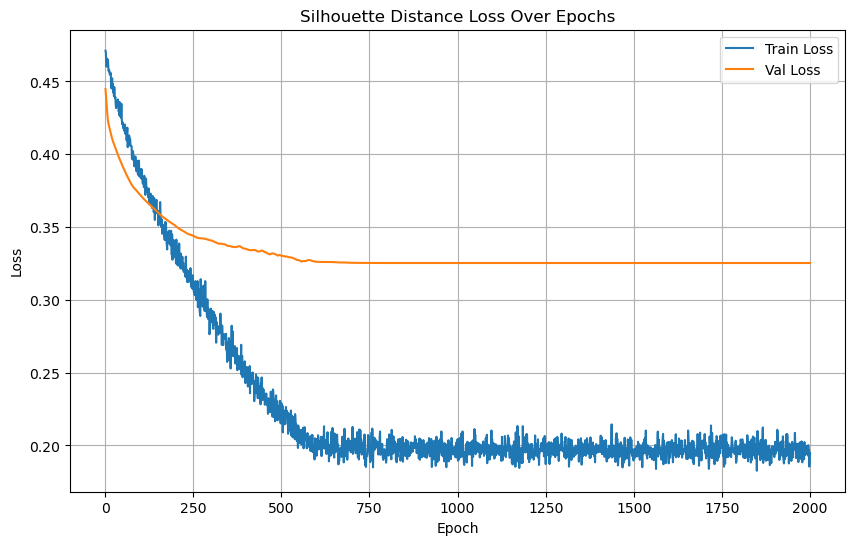

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/667], Loss: 0.3317


Test Batch [20/667], Loss: 0.2287
Test Batch [30/667], Loss: 0.3333


Test Batch [40/667], Loss: 0.3671


Test Batch [50/667], Loss: 0.3095
Test Batch [60/667], Loss: 0.2085
Test Batch [70/667], Loss: 0.2605


Test Batch [80/667], Loss: 0.1959


Test Batch [90/667], Loss: 0.1254
Test Batch [100/667], Loss: 0.2489
Test Batch [110/667], Loss: 0.1567
Test Batch [120/667], Loss: 0.1923


Test Batch [130/667], Loss: 0.2489
Test Batch [140/667], Loss: 0.2464
Test Batch [150/667], Loss: 0.2681
Test Batch [160/667], Loss: 0.5000
Test Batch [170/667], Loss: 0.5000
Test Batch [180/667], Loss: 0.1931
Test Batch [190/667], Loss: 0.2189


Test Batch [200/667], Loss: 0.2204
Test Batch [210/667], Loss: 0.2327
Test Batch [220/667], Loss: 0.5000
Test Batch [230/667], Loss: 0.1978
Test Batch [240/667], Loss: 0.5000
Test Batch [250/667], Loss: 0.5000
Test Batch [260/667], Loss: 0.5000
Test Batch [270/667], Loss: 0.5000
Test Batch [280/667], Loss: 0.5000
Test Batch [290/667], Loss: 0.5000
Test Batch [300/667], Loss: 0.5000
Test Batch [310/667], Loss: 0.3037


Test Batch [320/667], Loss: 0.2413
Test Batch [330/667], Loss: 0.2169
Test Batch [340/667], Loss: 0.2436


Test Batch [350/667], Loss: 0.2139
Test Batch [360/667], Loss: 0.2854
Test Batch [370/667], Loss: 0.1926


Test Batch [380/667], Loss: 0.2354
Test Batch [390/667], Loss: 0.1528
Test Batch [400/667], Loss: 0.1301


Test Batch [410/667], Loss: 0.2193
Test Batch [420/667], Loss: 0.2020
Test Batch [430/667], Loss: 0.1873


Test Batch [440/667], Loss: 0.3990
Test Batch [450/667], Loss: 0.2606
Test Batch [460/667], Loss: 0.4243


Test Batch [470/667], Loss: 0.3996
Test Batch [480/667], Loss: 0.3676
Test Batch [490/667], Loss: 0.2597


Test Batch [500/667], Loss: 0.3087
Test Batch [510/667], Loss: 0.1646
Test Batch [520/667], Loss: 0.2439


Test Batch [530/667], Loss: 0.2544
Test Batch [540/667], Loss: 0.2189
Test Batch [550/667], Loss: 0.3822


Test Batch [560/667], Loss: 0.2881
Test Batch [570/667], Loss: 0.2651
Test Batch [580/667], Loss: 0.2831
Test Batch [590/667], Loss: 0.2358


Test Batch [600/667], Loss: 0.3708
Test Batch [610/667], Loss: 0.4117
Test Batch [620/667], Loss: 0.3954
Test Batch [630/667], Loss: 0.3456


Test Batch [640/667], Loss: 0.2197
Test Batch [650/667], Loss: 0.4016
Test Batch [660/667], Loss: 0.3942

Test Loss: 0.3073


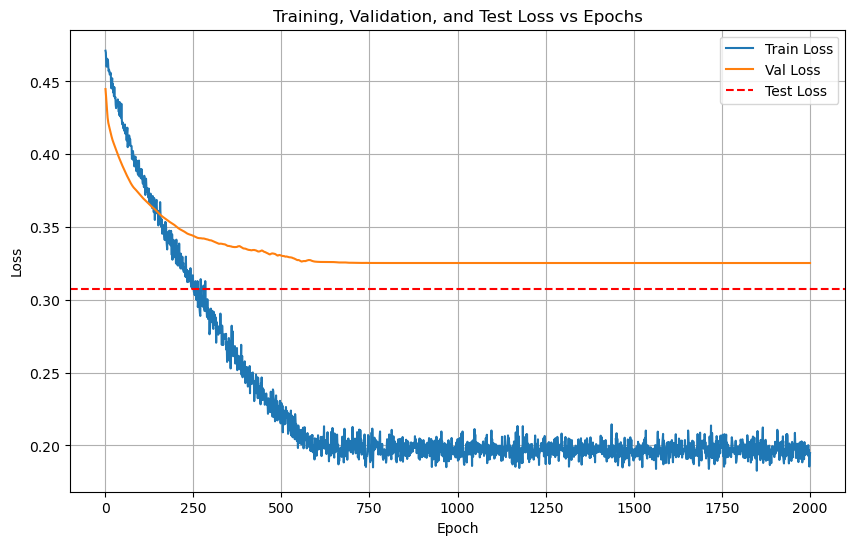

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/667 for test dataset.
  Processed batch 20/667 for test dataset.
  Processed batch 30/667 for test dataset.


  Processed batch 40/667 for test dataset.
  Processed batch 50/667 for test dataset.
  Processed batch 60/667 for test dataset.
  Processed batch 70/667 for test dataset.


  Processed batch 80/667 for test dataset.
  Processed batch 90/667 for test dataset.
  Processed batch 100/667 for test dataset.
  Processed batch 110/667 for test dataset.


  Processed batch 120/667 for test dataset.
  Processed batch 130/667 for test dataset.
  Processed batch 140/667 for test dataset.


  Processed batch 150/667 for test dataset.
  Processed batch 160/667 for test dataset.
  Processed batch 170/667 for test dataset.


  Processed batch 180/667 for test dataset.
  Processed batch 190/667 for test dataset.
  Processed batch 200/667 for test dataset.
  Processed batch 210/667 for test dataset.


  Processed batch 220/667 for test dataset.
  Processed batch 230/667 for test dataset.
  Processed batch 240/667 for test dataset.
  Processed batch 250/667 for test dataset.


  Processed batch 260/667 for test dataset.
  Processed batch 270/667 for test dataset.
  Processed batch 280/667 for test dataset.


  Processed batch 290/667 for test dataset.
  Processed batch 300/667 for test dataset.
  Processed batch 310/667 for test dataset.
  Processed batch 320/667 for test dataset.


  Processed batch 330/667 for test dataset.
  Processed batch 340/667 for test dataset.
  Processed batch 350/667 for test dataset.
  Processed batch 360/667 for test dataset.


  Processed batch 370/667 for test dataset.
  Processed batch 380/667 for test dataset.
  Processed batch 390/667 for test dataset.
  Processed batch 400/667 for test dataset.


  Processed batch 410/667 for test dataset.
  Processed batch 420/667 for test dataset.
  Processed batch 430/667 for test dataset.


  Processed batch 440/667 for test dataset.
  Processed batch 450/667 for test dataset.
  Processed batch 460/667 for test dataset.


  Processed batch 470/667 for test dataset.
  Processed batch 480/667 for test dataset.
  Processed batch 490/667 for test dataset.
  Processed batch 500/667 for test dataset.


  Processed batch 510/667 for test dataset.
  Processed batch 520/667 for test dataset.
  Processed batch 530/667 for test dataset.


  Processed batch 540/667 for test dataset.
  Processed batch 550/667 for test dataset.
  Processed batch 560/667 for test dataset.
  Processed batch 570/667 for test dataset.


  Processed batch 580/667 for test dataset.
  Processed batch 590/667 for test dataset.
  Processed batch 600/667 for test dataset.
  Processed batch 610/667 for test dataset.


  Processed batch 620/667 for test dataset.
  Processed batch 630/667 for test dataset.
  Processed batch 640/667 for test dataset.
  Processed batch 650/667 for test dataset.


  Processed batch 660/667 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 77.78%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.38      0.60      0.46         5
           2       0.80      0.80      0.80         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.00      0.00      0.00         5
           6       1.00      0.80      0.89         5
           7       0.83      1.00      0.91         5
           8       1.00      1.00      1.00         5

    accuracy                           0.78        45
   macro avg       0.76      0.78      0.76        45
weighted avg       0.76      0.78      0.76        45


LOG: Evaluating on the test set...
Test Accuracy: 64.79%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.0236  |  Val Loss: 1.9691
Validation loss improved from inf to 1.9691.
[Epoch 2/1000] Train Loss: 1.9804  |  Val Loss: 1.9316
Validation loss improved from 1.9691 to 1.9316.
[Epoch 3/1000] Train Loss: 1.9426  |  Val Loss: 1.8979
Validation loss improved from 1.9316 to 1.8979.
[Epoch 4/1000] Train Loss: 1.9069  |  Val Loss: 1.8690
Validation loss improved from 1.8979 to 1.8690.
[Epoch 5/1000] Train Loss: 1.8760  |  Val Loss: 1.8431
Validation loss improved from 1.8690 to 1.8431.
[Epoch 6/1000] Train Loss: 1.8488  |  Val Loss: 1.8195
Validation loss improved from 1.8431 to 1.8195.
[Epoch 7/1000] Train Loss: 1.8220  |  Val Loss: 1.7984
Validation loss improved from 1.8195 to 1.7984.
[Epoch 8/1000] Train Loss: 1.7999  |  Val Loss: 1.7807
Validation loss improved from 1.7984 to 1.7807.
[Epoch 9/1000] Train Loss: 1.7795  |  Val Loss: 1.7646
Validation loss improved from 1.7807 to 1.7646.
[Epoch 10/1000] Train Loss: 1.7596  |  Val Loss: 1.7500
Validation loss impr

[Epoch 37/1000] Train Loss: 1.4496  |  Val Loss: 1.5285
Validation loss improved from 1.5345 to 1.5285.


[Epoch 38/1000] Train Loss: 1.4410  |  Val Loss: 1.5227
Validation loss improved from 1.5285 to 1.5227.
[Epoch 39/1000] Train Loss: 1.4326  |  Val Loss: 1.5169
Validation loss improved from 1.5227 to 1.5169.
[Epoch 40/1000] Train Loss: 1.4243  |  Val Loss: 1.5112
Validation loss improved from 1.5169 to 1.5112.
[Epoch 41/1000] Train Loss: 1.4158  |  Val Loss: 1.5055
Validation loss improved from 1.5112 to 1.5055.
[Epoch 42/1000] Train Loss: 1.4079  |  Val Loss: 1.4998
Validation loss improved from 1.5055 to 1.4998.
[Epoch 43/1000] Train Loss: 1.3996  |  Val Loss: 1.4941
Validation loss improved from 1.4998 to 1.4941.
[Epoch 44/1000] Train Loss: 1.3915  |  Val Loss: 1.4885
Validation loss improved from 1.4941 to 1.4885.
[Epoch 45/1000] Train Loss: 1.3834  |  Val Loss: 1.4828
Validation loss improved from 1.4885 to 1.4828.
[Epoch 46/1000] Train Loss: 1.3753  |  Val Loss: 1.4771
Validation loss improved from 1.4828 to 1.4771.
[Epoch 47/1000] Train Loss: 1.3676  |  Val Loss: 1.4714
Validati

[Epoch 87/1000] Train Loss: 1.0481  |  Val Loss: 1.2492
Validation loss improved from 1.2551 to 1.2492.
[Epoch 88/1000] Train Loss: 1.0389  |  Val Loss: 1.2434
Validation loss improved from 1.2492 to 1.2434.
[Epoch 89/1000] Train Loss: 1.0301  |  Val Loss: 1.2375
Validation loss improved from 1.2434 to 1.2375.
[Epoch 90/1000] Train Loss: 1.0208  |  Val Loss: 1.2315
Validation loss improved from 1.2375 to 1.2315.
[Epoch 91/1000] Train Loss: 1.0117  |  Val Loss: 1.2255
Validation loss improved from 1.2315 to 1.2255.
[Epoch 92/1000] Train Loss: 1.0027  |  Val Loss: 1.2196
Validation loss improved from 1.2255 to 1.2196.
[Epoch 93/1000] Train Loss: 0.9936  |  Val Loss: 1.2136
Validation loss improved from 1.2196 to 1.2136.
[Epoch 94/1000] Train Loss: 0.9845  |  Val Loss: 1.2076
Validation loss improved from 1.2136 to 1.2076.
[Epoch 95/1000] Train Loss: 0.9753  |  Val Loss: 1.2017
Validation loss improved from 1.2076 to 1.2017.
[Epoch 96/1000] Train Loss: 0.9658  |  Val Loss: 1.1957
Validati

[Epoch 127/1000] Train Loss: 0.6688  |  Val Loss: 1.0030
Validation loss improved from 1.0088 to 1.0030.
[Epoch 128/1000] Train Loss: 0.6595  |  Val Loss: 0.9973
Validation loss improved from 1.0030 to 0.9973.
[Epoch 129/1000] Train Loss: 0.6501  |  Val Loss: 0.9916
Validation loss improved from 0.9973 to 0.9916.
[Epoch 130/1000] Train Loss: 0.6414  |  Val Loss: 0.9860
Validation loss improved from 0.9916 to 0.9860.
[Epoch 131/1000] Train Loss: 0.6325  |  Val Loss: 0.9805
Validation loss improved from 0.9860 to 0.9805.
[Epoch 132/1000] Train Loss: 0.6234  |  Val Loss: 0.9751
Validation loss improved from 0.9805 to 0.9751.
[Epoch 133/1000] Train Loss: 0.6150  |  Val Loss: 0.9695
Validation loss improved from 0.9751 to 0.9695.
[Epoch 134/1000] Train Loss: 0.6062  |  Val Loss: 0.9640
Validation loss improved from 0.9695 to 0.9640.
[Epoch 135/1000] Train Loss: 0.5976  |  Val Loss: 0.9585
Validation loss improved from 0.9640 to 0.9585.
[Epoch 136/1000] Train Loss: 0.5893  |  Val Loss: 0.952

[Epoch 167/1000] Train Loss: 0.3723  |  Val Loss: 0.8015
Validation loss improved from 0.8055 to 0.8015.
[Epoch 168/1000] Train Loss: 0.3670  |  Val Loss: 0.7975
Validation loss improved from 0.8015 to 0.7975.
[Epoch 169/1000] Train Loss: 0.3616  |  Val Loss: 0.7936
Validation loss improved from 0.7975 to 0.7936.
[Epoch 170/1000] Train Loss: 0.3563  |  Val Loss: 0.7897
Validation loss improved from 0.7936 to 0.7897.
[Epoch 171/1000] Train Loss: 0.3509  |  Val Loss: 0.7860
Validation loss improved from 0.7897 to 0.7860.
[Epoch 172/1000] Train Loss: 0.3460  |  Val Loss: 0.7824
Validation loss improved from 0.7860 to 0.7824.
[Epoch 173/1000] Train Loss: 0.3411  |  Val Loss: 0.7787
Validation loss improved from 0.7824 to 0.7787.
[Epoch 174/1000] Train Loss: 0.3360  |  Val Loss: 0.7749
Validation loss improved from 0.7787 to 0.7749.
[Epoch 175/1000] Train Loss: 0.3314  |  Val Loss: 0.7710
Validation loss improved from 0.7749 to 0.7710.
[Epoch 176/1000] Train Loss: 0.3268  |  Val Loss: 0.767

[Epoch 210/1000] Train Loss: 0.2141  |  Val Loss: 0.6798
Validation loss improved from 0.6817 to 0.6798.
[Epoch 211/1000] Train Loss: 0.2118  |  Val Loss: 0.6780
Validation loss improved from 0.6798 to 0.6780.
[Epoch 212/1000] Train Loss: 0.2095  |  Val Loss: 0.6764
Validation loss improved from 0.6780 to 0.6764.
[Epoch 213/1000] Train Loss: 0.2074  |  Val Loss: 0.6749
Validation loss improved from 0.6764 to 0.6749.
[Epoch 214/1000] Train Loss: 0.2052  |  Val Loss: 0.6737
Validation loss improved from 0.6749 to 0.6737.
[Epoch 215/1000] Train Loss: 0.2031  |  Val Loss: 0.6725
Validation loss improved from 0.6737 to 0.6725.
[Epoch 216/1000] Train Loss: 0.2011  |  Val Loss: 0.6712
Validation loss improved from 0.6725 to 0.6712.
[Epoch 217/1000] Train Loss: 0.1990  |  Val Loss: 0.6699
Validation loss improved from 0.6712 to 0.6699.
[Epoch 218/1000] Train Loss: 0.1971  |  Val Loss: 0.6685
Validation loss improved from 0.6699 to 0.6685.
[Epoch 219/1000] Train Loss: 0.1951  |  Val Loss: 0.667

[Epoch 259/1000] Train Loss: 0.1375  |  Val Loss: 0.6409
Validation loss improved from 0.6417 to 0.6409.
[Epoch 260/1000] Train Loss: 0.1365  |  Val Loss: 0.6404
Validation loss improved from 0.6409 to 0.6404.
[Epoch 261/1000] Train Loss: 0.1354  |  Val Loss: 0.6399
Validation loss improved from 0.6404 to 0.6399.
[Epoch 262/1000] Train Loss: 0.1344  |  Val Loss: 0.6392
Validation loss improved from 0.6399 to 0.6392.
[Epoch 263/1000] Train Loss: 0.1334  |  Val Loss: 0.6386
Validation loss improved from 0.6392 to 0.6386.
[Epoch 264/1000] Train Loss: 0.1325  |  Val Loss: 0.6379
Validation loss improved from 0.6386 to 0.6379.
[Epoch 265/1000] Train Loss: 0.1315  |  Val Loss: 0.6373
Validation loss improved from 0.6379 to 0.6373.
[Epoch 266/1000] Train Loss: 0.1306  |  Val Loss: 0.6367
Validation loss improved from 0.6373 to 0.6367.
[Epoch 267/1000] Train Loss: 0.1297  |  Val Loss: 0.6362
Validation loss improved from 0.6367 to 0.6362.
[Epoch 268/1000] Train Loss: 0.1289  |  Val Loss: 0.635

[Epoch 304/1000] Train Loss: 0.1025  |  Val Loss: 0.6300
Validation loss improved from 0.6303 to 0.6300.
[Epoch 305/1000] Train Loss: 0.1019  |  Val Loss: 0.6299
Validation loss improved from 0.6300 to 0.6299.
[Epoch 306/1000] Train Loss: 0.1014  |  Val Loss: 0.6298
Validation loss improved from 0.6299 to 0.6298.
[Epoch 307/1000] Train Loss: 0.1009  |  Val Loss: 0.6297
Validation loss improved from 0.6298 to 0.6297.
[Epoch 308/1000] Train Loss: 0.1003  |  Val Loss: 0.6296
Validation loss improved from 0.6297 to 0.6296.
[Epoch 309/1000] Train Loss: 0.0999  |  Val Loss: 0.6297
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 310/1000] Train Loss: 0.0993  |  Val Loss: 0.6296
Validation loss improved from 0.6296 to 0.6296.
[Epoch 311/1000] Train Loss: 0.0988  |  Val Loss: 0.6296
Validation loss improved from 0.6296 to 0.6296.
[Epoch 312/1000] Train Loss: 0.0983  |  Val Loss: 0.6295
Validation loss improved from 0.6296 to 0.6295.
[Epoch 313/1000] Train Loss: 0.0978  |  Val Loss:

[Epoch 346/1000] Train Loss: 0.0825  |  Val Loss: 0.6387
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 347/1000] Train Loss: 0.0822  |  Val Loss: 0.6390
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 348/1000] Train Loss: 0.0818  |  Val Loss: 0.6395
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 349/1000] Train Loss: 0.0813  |  Val Loss: 0.6399
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 350/1000] Train Loss: 0.0811  |  Val Loss: 0.6403
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 351/1000] Train Loss: 0.0807  |  Val Loss: 0.6406
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 352/1000] Train Loss: 0.0803  |  Val Loss: 0.6406
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 353/1000] Train Loss: 0.0799  |  Val Loss: 0.6407
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 354/1000] Train Loss: 0.0795  |  Val Loss: 0.6411
!! Validation loss did NOT improve !! Patience:

[Epoch 384/1000] Train Loss: 0.0695  |  Val Loss: 0.6528
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 385/1000] Train Loss: 0.0692  |  Val Loss: 0.6535
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 386/1000] Train Loss: 0.0689  |  Val Loss: 0.6540
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 387/1000] Train Loss: 0.0686  |  Val Loss: 0.6543
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 388/1000] Train Loss: 0.0683  |  Val Loss: 0.6544
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 389/1000] Train Loss: 0.0680  |  Val Loss: 0.6546
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 390/1000] Train Loss: 0.0677  |  Val Loss: 0.6546
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 391/1000] Train Loss: 0.0674  |  Val Loss: 0.6546
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 392/1000] Train Loss: 0.0672  |  Val Loss: 0.6549
!! Validation loss did NOT improve !! Patience:

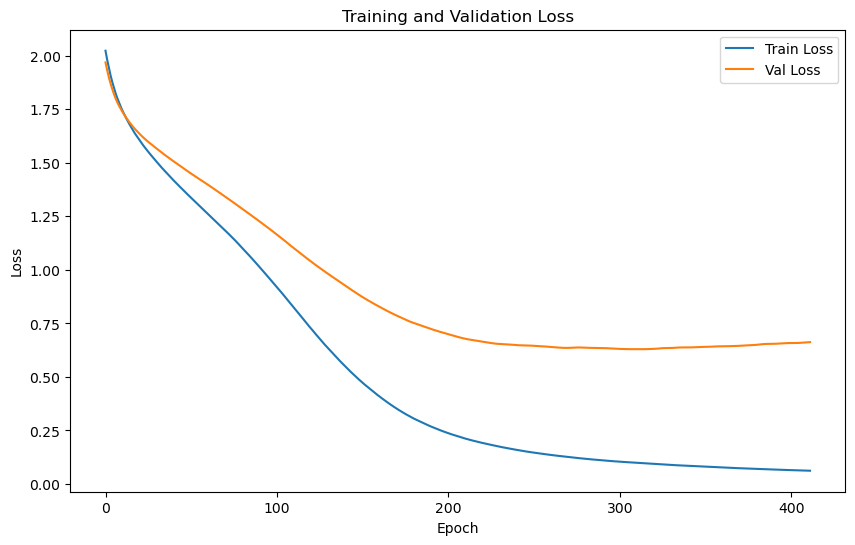

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.4591 | Test Accuracy: 66.01%


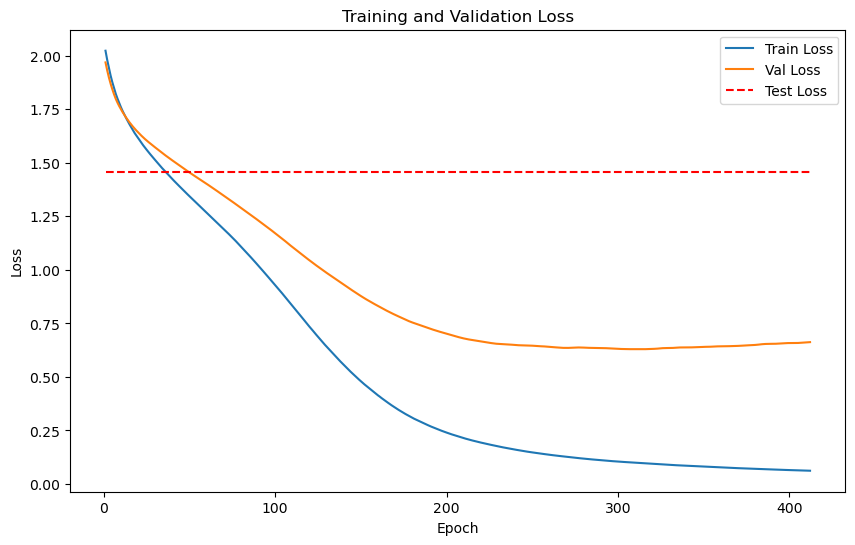

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


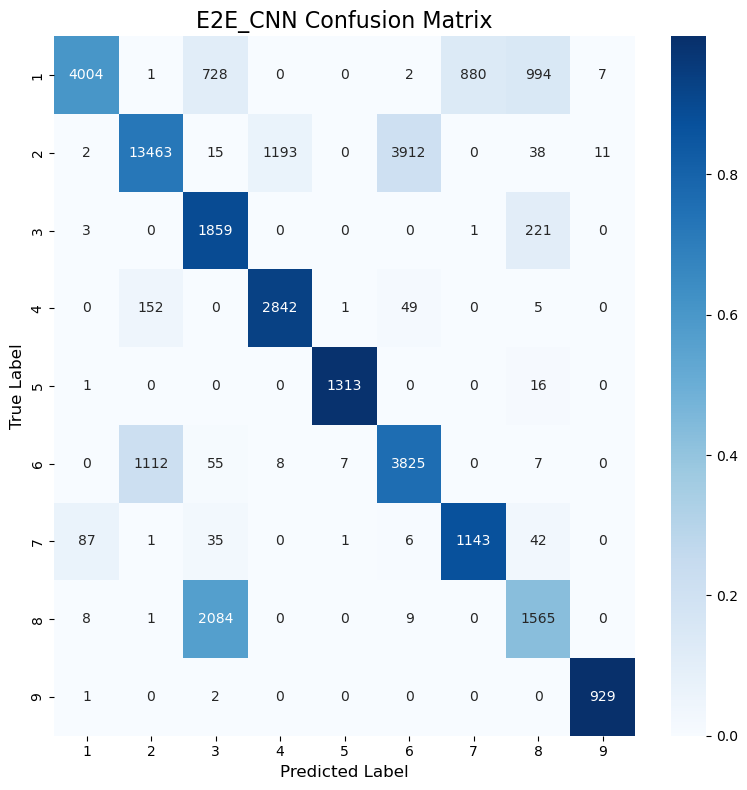

Classification Accuracy: 72.57%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


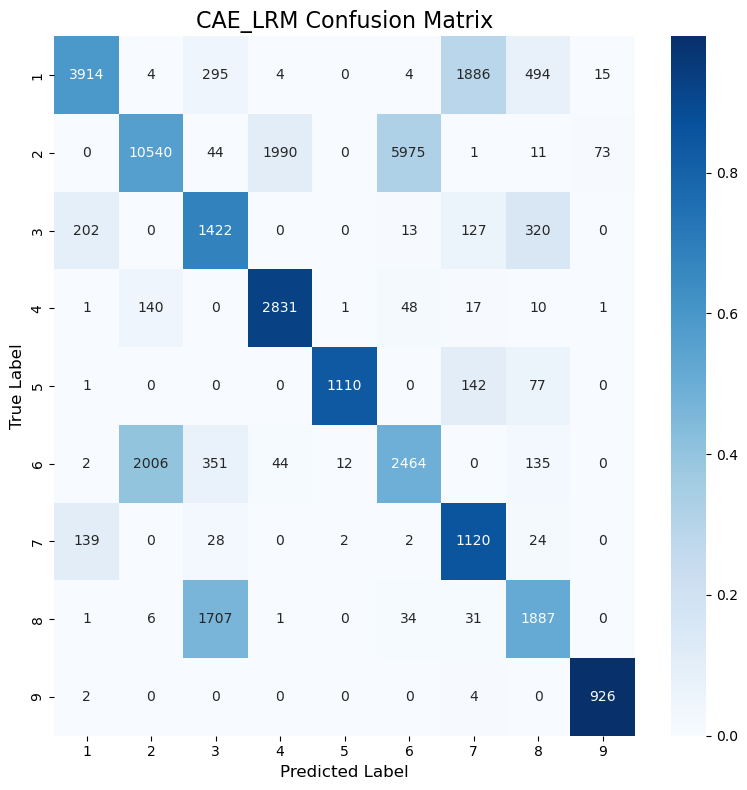

Classification Accuracy: 61.48%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


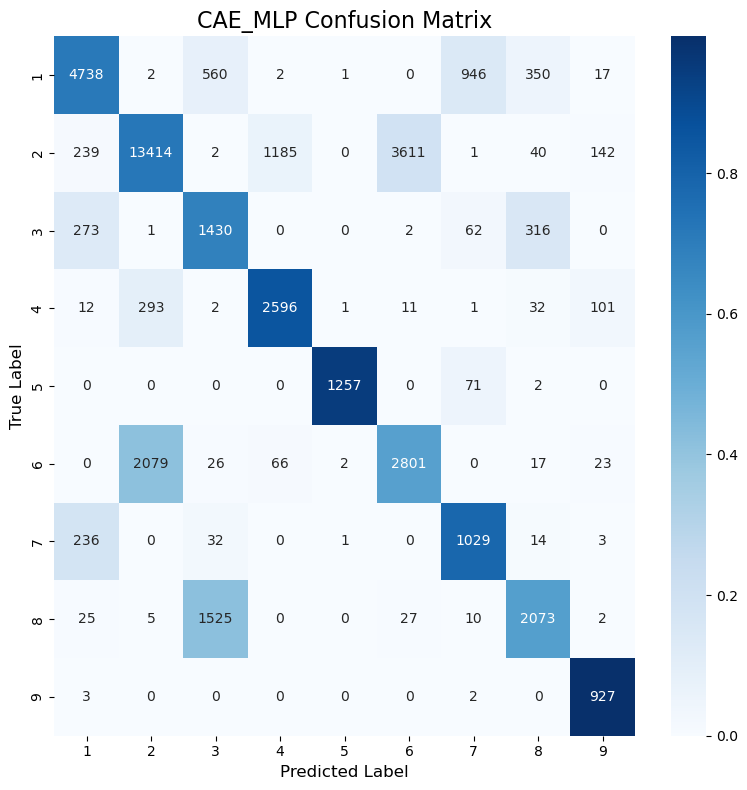

Classification Accuracy: 70.98%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


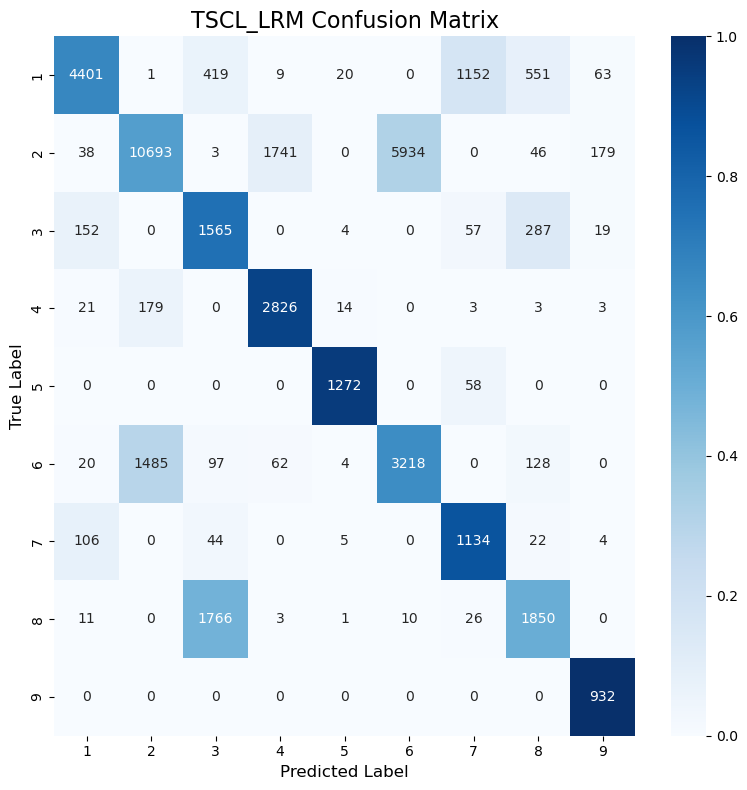

Classification Accuracy: 65.41%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


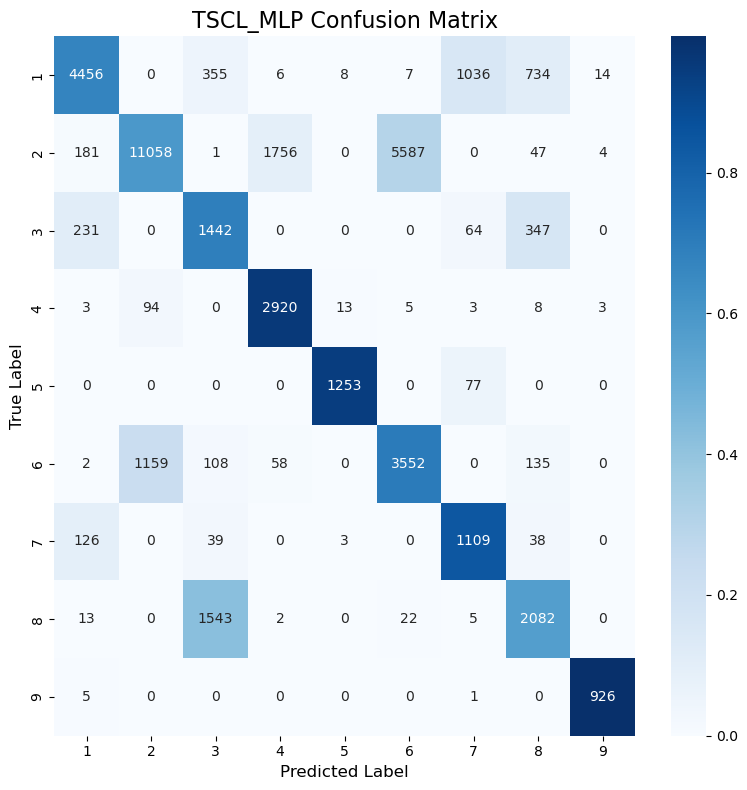

Classification Accuracy: 67.54%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


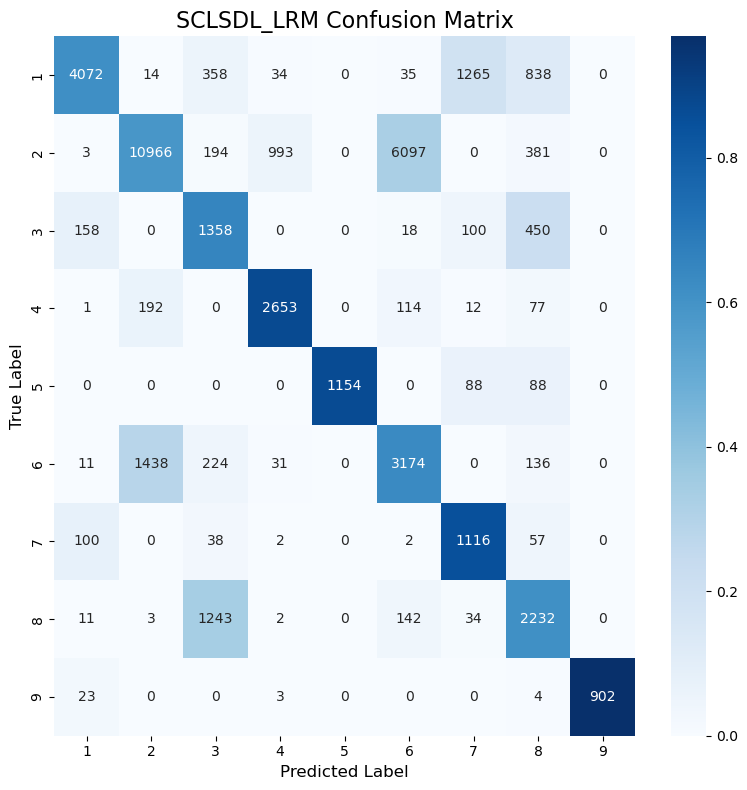

Classification Accuracy: 64.79%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


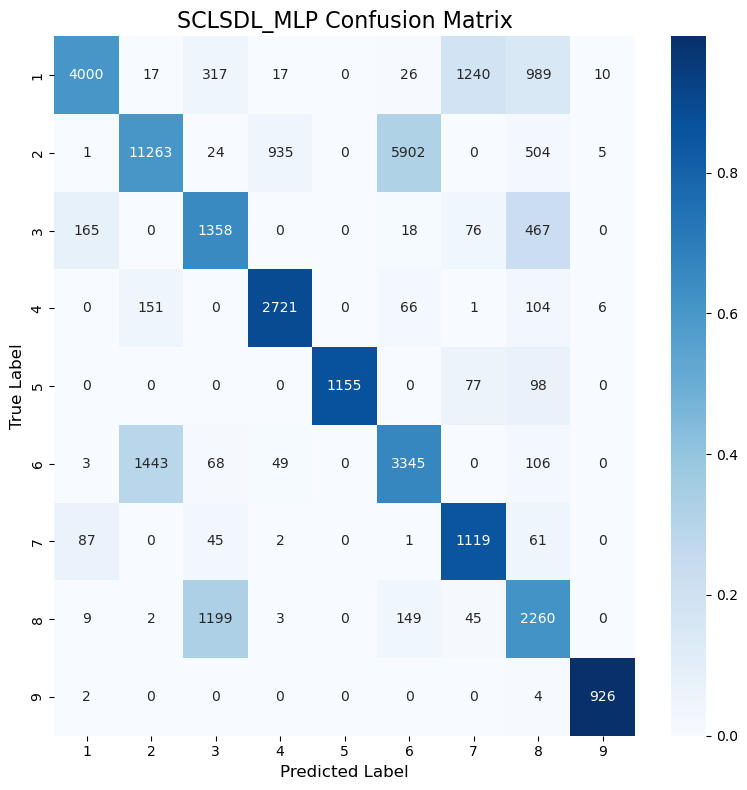

Classification Accuracy: 66.01%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          72.57
1    LRM (CAE)          61.48
2    MLP (CAE)          70.98
3     TSCL LRM          65.41
4     TSCL MLP          67.54
5  SCL_SDL LRM          64.79
6  SCL_SDL MLP          66.01

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          72.57
2    MLP (CAE)          70.98
4     TSCL MLP          67.54
6  SCL_SDL MLP          66.01
3     TSCL LRM          65.41
5  SCL_SDL LRM          64.79
1    LRM (CAE)          61.48
